### LSE Data Analytics Online Career Accelerator <a id="top"></a>

# DA301:  Advanced Analytics for Organisational Impact

### Table of Contents

#### 1. [Libraries](#1)
#### 2. [Defined Functions](#2)
#### 3. [Loading The Dataset](#3)
#### 4. [Cleaning The Data](#4)
                Renaming Columns
                Renaming dictionaries
                Creating Bins for Ages
                One-Hot Encoding
#### 5. [Exploring Duplicates](#5)
#### 6. [Exploring the Dataset](#6)
#### 7. [Power Transformers](#7)

### 8. [Simple Regression Models](#8)

#### 8a.   [spending score v. loyalty points](#8a)
#### 8b. [remuneration v. loyalty points](#8b)

### 9. [Multiple Linear Regression](#9)

#### 9a.   [no transformation](#9a)
#### 9b.   [yeo-johnson transformer](#9a)

### 10. [Decision Trees & Random Forests](#10)

#### 10a.   [no pruning](#10a)
#### 10b.   [Decision Trees w/ pruning (SearchGridCV)](#10b)
#### 10c.   [Random Forests w/ pruning (SearchGridCV)](#10c)

### 11. [SVR Model](#11)

### 12. [Gradient Boosting - XGRBoost](#12)

#### 12a.   [SHAP Explainer](#12a)

### 13. [Cross Validation](#13)

### 14. [All Models Plotted](#14)

### 15. [Clustering with k-means](#15)
#### 15a.   [Elbow Method](#15a)
#### 15b.   [Siloutette Method](#15b)
#### 15c. [Silouette Plots](#15c)
#### 15d.   [Cluster Plot](#15d)

### 16. [Sentiment Analysis](#16)
#### 16a. [Word Frequency](#16a)
#### 16b. [VADER & TextBlob Analysis ](#16b)
#### 16c. [Comparing NLP Outputs](#16c)

### 17. [Recommendations](#17)
#### 17a. [Product Score](#17a)
#### 17b. [Provide Recommendations by Cluster](#17b)

### 1. Libraries <a id="1"></a>

In [122]:
'''
pip install numpy pandas statsmodels matplotlib seaborn scikit-learn scipy xgboost 
wordcloud nltk textblob advertools autocorrect plotly shap
'''

'\npip install numpy pandas statsmodels matplotlib seaborn scikit-learn scipy xgboost \nwordcloud nltk textblob advertools autocorrect plotly shap\n'

In [123]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn import linear_model, metrics, tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, silhouette_score, silhouette_samples
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.svm import SVR
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.inspection import PartialDependenceDisplay
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
from scipy.stats import shapiro, normaltest, kstest, yeojohnson, norm
import scipy.stats as stats
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import advertools as adv
from collections import Counter

from autocorrect import Speller
import plotly.graph_objects as go
import re
import shap
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px
import json

questrial_font = dict(family="Questrial, sans-serif")

pio.templates["custom"] = pio.templates["plotly_white"]
pio.templates["custom"].layout.font.family = "Questrial, sans-serif"
pio.templates["custom"].layout.font.size = 16
pio.templates.default = "custom"

# Set font sizes for specific elements
pio.templates["custom"].layout.title.font.size = 24  # Larger size for main title
pio.templates["custom"].layout.xaxis.title.font.size = 18  # Size for x-axis title
pio.templates["custom"].layout.yaxis.title.font.size = 18  # Size for y-axis title
pio.templates["custom"].layout.legend.font.size = 16  # Size for legend text

# Ensure tick labels are also at least 16
pio.templates["custom"].layout.xaxis.tickfont.size = 16
pio.templates["custom"].layout.yaxis.tickfont.size = 16

# Set the custom template as the default
pio.templates.default = "custom"


SEED = 42

### 2. Defined Functions: <a id="2"></a>

[create_simple_model](#8)

[create_and_evaluate_regression_model](#9)

[decision_forest_regression_models](#10)

[GridSearchCV](#10b)

[Cross Validation](#13)

[K-Means](#14)

[Product_Score](#17a)

[get_top_products_by_cluster & get_recommendations](#17b)



In [124]:
def validate_assumptions(X, y, model, model_type='OLS', feature_names=None):
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X, columns=feature_names if feature_names is not None else [f'Feature_{i}' for i in range(X.shape[1])])
    else:
        X_df = X

    if model_type == 'OLS':
        X_with_const = sm.add_constant(X_df)
        residuals = y - model.predict(X_with_const)
        fitted_values = model.predict(X_with_const)
    elif model_type == 'BLR':
        residuals = y - model.predict(X)
        fitted_values = model.predict(X)
        X_with_const = sm.add_constant(X_df)
    else:
        raise ValueError("Model type must be either 'OLS' or 'BLR'.")

    # Ensure residuals and fitted_values are 1D numpy arrays
    residuals = np.ravel(residuals)
    fitted_values = np.ravel(fitted_values)

    results = {}

    # Linearity and Homoscedasticity
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    sns.regplot(x=fitted_values, y=residuals, lowess=True, ax=axes[0, 0], scatter_kws={'alpha': 0.5})
    axes[0, 0].set_title('Residuals vs Fitted')
    axes[0, 0].set_xlabel('Fitted values')
    axes[0, 0].set_ylabel('Residuals')

    sns.scatterplot(x=fitted_values, y=np.abs(residuals), ax=axes[0, 1], alpha=0.5)
    axes[0, 1].set_title('Scale-Location')
    axes[0, 1].set_xlabel('Fitted values')
    axes[0, 1].set_ylabel('|Residuals|')

    # Normality of Residuals
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Normal Q-Q')

    sns.histplot(residuals, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Residuals Distribution')

    plt.tight_layout()
    plt.show()

    # Statistical tests
    # Normality test (Shapiro-Wilk)
    _, normality_p = stats.shapiro(residuals)
    results['normality'] = {
        'test': 'Shapiro-Wilk',
        'p_value': normality_p,
        'pass': normality_p > 0.05,
        'explanation': 'p-value > 0.05' if normality_p > 0.05 else 'p-value <= 0.05'
    }

    # Homoscedasticity test (Breusch-Pagan)
    try:
        _, homoscedasticity_p, _, _ = sm.stats.diagnostic.het_breuschpagan(residuals, X_with_const)
        results['homoscedasticity'] = {
            'test': 'Breusch-Pagan',
            'p_value': homoscedasticity_p,
            'pass': homoscedasticity_p > 0.05,
            'explanation': 'p-value > 0.05' if homoscedasticity_p > 0.05 else 'p-value <= 0.05'
        }
    except ValueError as e:
        print(f"Warning: Breusch-Pagan test failed. Error: {str(e)}")
        results['homoscedasticity'] = {
            'test': 'Breusch-Pagan',
            'error': str(e),
            'pass': False,
            'explanation': f'Test failed due to error: {str(e)}'
        }

    # Multicollinearity (VIF)
    if X_df.shape[1] > 1:
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X_df.columns
        vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
        print("Variance Inflation Factors:")
        print(vif_data)
        max_vif = vif_data["VIF"].max()
        results['multicollinearity'] = {
            'test': 'VIF',
            'max_vif': max_vif,
            'pass': max_vif < 10,
            'explanation': 'All VIF < 10' if max_vif < 10 else f'Max VIF = {max_vif:.2f} > 10'
        }
    else:
        results['multicollinearity'] = {
            'test': 'VIF',
            'message': "Not applicable for single feature",
            'pass': True,
            'explanation': 'Only one feature present'
        }

    # Print summary
    print("\nAssumption Test Results:")
    for assumption, result in results.items():
        status = 'Passed' if result['pass'] else 'Failed'
        explanation = result.get('explanation', '')
        print(f"{assumption.capitalize()}: {status} - {explanation}")
        if 'p_value' in result:
            print(f"  p-value: {result['p_value']}")
        elif 'max_vif' in result:
            print(f"  Max VIF: {result['max_vif']:.2f}")
        elif 'message' in result:
            print(f"  {result['message']}")
        elif 'error' in result:
            print(f"  Error: {result['error']}")

    return results

def create_simple_model(feature, target, model_type='OLS', model_name=None):
    global df_cust  # Use the global df_cust
    df_local = df_cust.copy()  # Create a local copy to avoid modifying the global df_cust
    global model_metrics  # Use a global dictionary to store metrics for each model

    # Specify the independent (X) and dependent (y) variables
    X = df_local[[feature]]
    y = df_local[target]

    # Create train and test data sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

    if model_type == 'OLS':
        # Create the OLS model
        model = sm.OLS(y_train, sm.add_constant(x_train)).fit()
        y_pred = model.predict(sm.add_constant(x_test))

        # Extract estimated parameters (coefficients)
        params = model.params
        # Extract standard errors
        std_errors = model.bse
        # Generate the regression table
        regression_table = pd.DataFrame({
            "Coefficient": params,
            "Standard Error": std_errors
        })
        # Print the regression table and summary
        print(f"Regression Table for {feature} (OLS):")
        print(regression_table)
        print(model.summary())

    elif model_type == 'BLR':
        # Create the Bayesian Linear Regression model
        model = BayesianRidge()
        model.fit(x_train.values.reshape(-1, 1), y_train.values)
        y_pred = model.predict(x_test.values.reshape(-1, 1))

        # Coefficients and standard errors can be extracted
        # from the BayesianRidge attributes
        params = np.concatenate(([model.intercept_], model.coef_))
        std_errors = np.sqrt(np.diag(model.sigma_))

        regression_table = pd.DataFrame({
            "Coefficient": params,
            "Standard Error": std_errors
        }, index=['const', feature])

        # Print the regression table
        print(f"Regression Table for {feature} (Bayesian Linear Regression):")
        print(regression_table)

        # Create a custom summary for BLR
        print("\nBayesian Linear Regression Summary:")
        print(f"Number of samples: {len(x_train)}")
        print(f"Number of features: {x_train.shape[1]}")
        print(f"Alpha: {model.alpha_}")
        print(f"Lambda: {model.lambda_}")

    else:
        raise ValueError("Invalid model type specified.")

    # Calculate and print R-squared and Mean Squared Error
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"R-squared for {model_type}: {r_squared}")
    print(f"Mean Squared Error for {model_type}: {mse}")

    # Store metrics in the global dictionary
    if model_name is None:
        model_name = model_type
    
    model_metrics[model_name] = {'R-squared': r_squared, 'MSE': mse}

    # Plot the graph with a regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(x_test[feature], y_test, color='blue', label='Actual')
    plt.scatter(x_test[feature], y_pred, color='red', label='Predicted')
    plt.plot(x_test[feature], y_pred, color='red', linewidth=2)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target} ({feature} - {model_type})')
    plt.legend()
    plt.show()

    # Return the model, training data, and R-squared value
    return model, x_train, y_train, r_squared

def create_and_evaluate_regression_model(features, target, model_type='OLS', target_transformer=None, model_name=None):
    global df_cust
    global model_metrics
    
    X = df_cust[features].copy()
    y = df_cust[target].copy()
    
    # Convert bool columns to int (0 or 1)
    bool_columns = X.select_dtypes(include=['bool']).columns
    X[bool_columns] = X[bool_columns].astype(int)
    
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print(f"Shape of x_train: {x_train.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    
    if target_transformer:
        y_train_transformed = target_transformer.fit_transform(np.array(y_train).reshape(-1, 1)).flatten()
        y_test_transformed = target_transformer.transform(np.array(y_test).reshape(-1, 1)).flatten()
    else:
        y_train_transformed = y_train
        y_test_transformed = y_test
    
    if model_type == 'OLS':
        x_train_const = sm.add_constant(x_train)
        x_test_const = sm.add_constant(x_test)
        model = sm.OLS(y_train_transformed, x_train_const).fit()
        y_pred_transformed = model.predict(x_test_const)
        
        params = model.params
        std_errors = model.bse
        regression_table = pd.DataFrame({
            "Coefficient": params,
            "Standard Error": std_errors
        })
        print(f"Regression Table for Multiple Linear Regression (OLS):")
        print(regression_table)
        print(model.summary())
        
    elif model_type == 'BLR':
        model = BayesianRidge(fit_intercept=True)
        model.fit(x_train, y_train_transformed)
        y_pred_transformed = model.predict(x_test)
        
        print(f"Number of features: {x_train.shape[1]}")
        print(f"Number of coefficients: {len(model.coef_)}")
        print(f"Intercept: {model.intercept_}")
        
        params = np.concatenate(([model.intercept_], model.coef_))
        std_errors = np.sqrt(np.diag(model.sigma_))
        
        feature_names = ['const'] + list(x_train.columns)
        
        # Create a dictionary to store coefficients and standard errors
        coef_dict = {'Coefficient': {}, 'Standard Error': {}}
        
        # Assign coefficients and standard errors to corresponding features
        for i, feature in enumerate(feature_names):
            if i < len(params):
                coef_dict['Coefficient'][feature] = params[i]
            if i < len(std_errors):
                coef_dict['Standard Error'][feature] = std_errors[i]
        
        regression_table = pd.DataFrame(coef_dict)
        
        print(f"Regression Table for Multiple Linear Regression (Bayesian Linear Regression):")
        print(regression_table)
    
    else:
        raise ValueError("Invalid model type specified.")
    
    # Validate assumptions
    print("\nValidating model assumptions...")
    assumption_results = validate_assumptions(x_train, y_train_transformed, model, model_type, feature_names=x_train.columns)
    
    # Inverse transform the predictions if target_transformer is provided
    if target_transformer:
        y_pred = target_transformer.inverse_transform(np.array(y_pred_transformed).reshape(-1, 1)).flatten()
        y_test = target_transformer.inverse_transform(np.array(y_test_transformed).reshape(-1, 1)).flatten()
    else:
        y_pred = y_pred_transformed
        y_test = y_test_transformed
    
    # Calculate performance metrics
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"R-squared: {r_squared}")
    print(f"Mean Squared Error: {mse}")
    
    # Store metrics in the global dictionary
    if model_name is None:
        model_name = model_type
    
    model_metrics[model_name] = {'R-squared': r_squared, 'MSE': mse}
    
    return model, x_train, y_train, r_squared, assumption_results

def decision_forest_regression_models(features, target, model_type='DecisionTree', max_depth=None, n_estimators=100, target_transformer=None, model_name=None):
    global df_cust
    global model_metrics  # Global dictionary to store metrics for each model
    df_local = df_cust.copy()
    X = df_local[features]
    y = df_local[target]
    X = pd.get_dummies(X, drop_first=True)
    if X.isnull().any().any() or y.isnull().any():
        X = X.fillna(X.mean())
        y = y.fillna(y.mean())
    X = X.apply(pd.to_numeric, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    X = X.dropna()
    y = y.loc[X.index]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
    
    # Transform target if transformer is provided
    if target_transformer:
        y_train_transformed = target_transformer.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        y_test_transformed = target_transformer.transform(y_test.values.reshape(-1, 1)).flatten()
    else:
        y_train_transformed = y_train
        y_test_transformed = y_test
    
    # Train the model
    if model_type == 'DecisionTree':
        model = DecisionTreeRegressor(max_depth=max_depth, random_state=SEED)
    elif model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=SEED)
    else:
        raise ValueError("Invalid model type specified.")
    
    model.fit(x_train, y_train_transformed)
    y_pred_transformed = model.predict(x_test)
    
    # Inverse transform predictions if transformer was used
    if target_transformer:
        y_pred = target_transformer.inverse_transform(y_pred_transformed.reshape(-1, 1)).flatten()
    else:
        y_pred = y_pred_transformed
    
    # Model performance
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"R-squared for {model_type}: {r_squared}")
    print(f"Mean Squared Error for {model_type}: {mse}")
    print(f"Mean Absolute Error: {mae}")
    
    # Store metrics in the global dictionary
    if model_name is None:
        model_name = model_type
    
    model_metrics[model_name] = {'R-squared': r_squared, 'MSE': mse}
    
    # Plot results
    plot_feature_importance_and_residuals(model, X, y_test, y_pred, model_type, target)
    return model, x_train, y_train, r_squared

def plot_feature_importance_and_residuals(model, X, y_test, y_pred, model_type, target, is_xgboost=False):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Feature Importance
    if is_xgboost:
        feature_importances = pd.Series(model.get_score(importance_type='weight'), index=X.columns)
    else:
        feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    
    feature_importances = feature_importances / feature_importances.sum()  # Normalize
    feature_importances.sort_values(ascending=False).plot(kind='bar', color='skyblue', ax=axes[0])
    axes[0].set_title(f'Normalised Feature Importance - {model_type}')
    axes[0].set_ylabel('Importance')
    
    # Plot Actual vs. Predicted
    axes[1].scatter(y_test, y_test, color='blue', label='Actual=Predicted', alpha=0.5)
    axes[1].scatter(y_test, y_pred, color='red', label='Predicted', alpha=0.5)
    axes[1].set_xlabel('Actual Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].set_title(f'Actual vs Predicted {target} ({model_type})')
    axes[1].legend()
    
    # Add a diagonal line
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    
    plt.tight_layout()
    plt.show()


def perform_grid_search_cv(model_type, X_train, y_train, param_grid, target_transformer=None, cv=5):
    if model_type == 'DecisionTree':
        model = DecisionTreeRegressor(random_state=SEED)
    elif model_type == 'RandomForest':
        model = RandomForestRegressor(random_state=SEED)
    elif model_type == 'XGBoost':
        model = XGBRegressor(random_state=SEED, objective='reg:squarederror')
    elif model_type == 'SVR':
        model = SVR()
    else:
        raise ValueError("Unsupported model type. Choose from 'DecisionTree', 'RandomForest', 'XGBoost', 'SVR'.")

    if target_transformer:
        y_train = target_transformer.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print(f"Best parameters found for {model_type}: {best_params}")
    return grid_search, best_params

# Function to perform cross-validation and print results
def perform_cv(model, X_train, y_train, X_test, y_test, model_name, transformer=None):
    global model_metrics  # Declare model_metrics as global
    # Cross-validation on training set
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores_train = -scores  # Convert to positive MSE
    r2_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    # Fit the model on the entire training set
    model.fit(X_train, y_train)
    
    # Evaluate on the testing set
    y_pred_test = model.predict(X_test)
    
    # Inverse transform if transformer is provided
    if transformer:
        y_pred_test = transformer.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
        y_test = transformer.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Store metrics in the global dictionary
    model_metrics[model_name] = {'R-squared': r2_test, 'MSE': mse_test}
    
    results = {
        'model_name': model_name,
        'mean_mse_train': np.mean(mse_scores_train),
        'std_mse_train': np.std(mse_scores_train) * 2,
        'mean_r2_train': np.mean(r2_scores_train),
        'std_r2_train': np.std(r2_scores_train) * 2,
        'mse_test': mse_test,
        'r2_test': r2_test
    }
    
    print(f"{model_name} Results:")
    print(f"Training - Mean MSE: {results['mean_mse_train']:.2f} (+/- {results['std_mse_train']:.2f})")
    print(f"Training - Mean R-squared: {results['mean_r2_train']:.4f} (+/- {results['std_r2_train'] * 2:.4f})")
    print(f"Testing - MSE: {results['mse_test']:.2f}")
    print(f"Testing - R-squared: {results['r2_test']:.4f}")
    print()
    
    return results, model

# Learning Curves
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 5))
    plt.title(f"Learning Curves ({type(estimator).__name__})")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        return_times=True, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def train_kmeans(X):
    ks = np.linspace(2, 8, 7, dtype=np.int64)
    inertias = []
    silhouettes = []
    kmeans_k = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=SEED)
        kmeans.fit(X)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))
        kmeans_k.append(kmeans)

    return kmeans_k, inertias, silhouettes, ks

# Function to clean and autocorrect review text
def clean_review(review):
    if isinstance(review, (np.float64, float)):  # Checks for float which might indicate NaN values
        return ""
    r = review.lower()
    r = re.sub("'", "", r)  # Remove contractions in English
    r = re.sub("@[A-Za-z0-9_]+","", r)  # Remove mentions
    r = re.sub("#[A-Za-z0-9_]+","", r)  # Remove hashtags
    r = re.sub(r'http\S+', '', r)  # Remove URLs
    r = re.sub('[()!?]', ' ', r)  # Replace certain punctuation with space
    r = re.sub('\[.*?\]',' ', r)  # Remove text within brackets
    r = re.sub("[^a-z0-9]", " ", r)  # Remove non-alphanumeric characters
    r = r.split()  # Tokenize the text into words
    r = [spell(word) for word in r]  # Autocorrect spelling
    r = [word for word in r if word not in stop_words]  # Remove stopwords
    r = " ".join(word for word in r)  # Rejoin words to form the cleaned review
    return r

def calculate_product_score(df, df_cust):
    # Group by product and calculate metrics
    product_scores = df.groupby('product').agg({
        'VADER_review_compound': ['mean', 'count', 'std']
    })
    
    # Flatten column names
    product_scores.columns = ['avg_sentiment', 'review_count', 'sentiment_std']
    
    # Normalise sentiment to 0-100 scale
    product_scores['normalised_sentiment'] = (product_scores['avg_sentiment'] + 1) * 50
    
    # Adjust score based on sentiment consistency (inverse of standard deviation)
    product_scores['consistency_score'] = (1 - product_scores['sentiment_std']) * 10
    
    # Calculate average loyalty points for each product
    product_loyalty = df_cust.groupby('product')['loyalty_points'].mean().rename('avg_loyalty_points')
    
    # Merge loyalty points info with product scores
    product_scores = product_scores.join(product_loyalty)
    
    # Normalise loyalty points to 0-100 scale
    product_scores['normalised_loyalty'] = (product_scores['avg_loyalty_points'] - product_scores['avg_loyalty_points'].min()) / \
                                           (product_scores['avg_loyalty_points'].max() - product_scores['avg_loyalty_points'].min()) * 100
    
    # Calculate final score 
    product_scores['final_score'] = (
        product_scores['normalised_sentiment'] * 0.3 +
        product_scores['consistency_score'] * 0.1 +
        product_scores['normalised_loyalty'] * 0.6
    )
    
    # Normalize final score to 0-100
    product_scores['final_score'] = stats.rankdata(product_scores['final_score'], method='max') / len(product_scores) * 100
    
    return product_scores[['final_score', 'normalised_sentiment', 'review_count', 'consistency_score', 'avg_loyalty_points', 'normalised_loyalty']]

def get_top_products_by_cluster(df_cust, product_scores, n_top=5):
    # Merge customer data with product scores
    df_merged = pd.merge(df_cust, product_scores, left_on='product', right_index=True, how='left')

    # Group by cluster and product, then calculate mean score and count
    cluster_product_stats = df_merged.groupby(['cluster', 'product']).agg({
        'final_score': 'mean',
        'product': 'count'
    }).rename(columns={'product': 'purchase_count'}).reset_index()

    # Sort products within each cluster by score and then by purchase count
    cluster_product_stats = cluster_product_stats.sort_values(
        ['cluster', 'final_score', 'purchase_count'], 
        ascending=[True, False, False]
    )

    # Get top N products for each cluster
    top_products = cluster_product_stats.groupby('cluster').head(n_top)
    return top_products

def get_recommendations(cluster, top_products, n_rec=5):
    if cluster == 0:
        rec_cluster = 4
    elif cluster == 1:
        rec_cluster = 3
    else:
        rec_cluster = cluster
    
    return top_products[top_products['cluster'] == rec_cluster].head(n_rec)

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        return super(NumpyEncoder, self).default(obj)



<>:511: SyntaxWarning:

invalid escape sequence '\['

<>:511: SyntaxWarning:

invalid escape sequence '\['

C:\Users\willi\AppData\Local\Temp\ipykernel_16308\1859613917.py:511: SyntaxWarning:

invalid escape sequence '\['



#### Exploring The Dataset <a id="3"></a>

In [125]:
# Load the CSV file(s) as reviews.

# Import the data set.
df = pd.read_csv('turtle_reviews.csv')

# View the DataFrame.
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  2000 non-null   object 
 1   age                     2000 non-null   int64  
 2   remuneration (k£)       2000 non-null   float64
 3   spending_score (1-100)  2000 non-null   int64  
 4   loyalty_points          2000 non-null   int64  
 5   education               2000 non-null   object 
 6   language                2000 non-null   object 
 7   platform                2000 non-null   object 
 8   product                 2000 non-null   int64  
 9   review                  2000 non-null   object 
 10  summary                 2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 172.0+ KB
None


gender  age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
0    Male   18              12.30                      39             210   
1    Male   23              12.30                      81             524   
2  Female   22              13.12                       6              40   
3  Female   25              13.12                      77             562   
4  Female   33              13.94                      40             366   

  education language platform  product  \
0  graduate       EN      Web      453   
1  graduate       EN      Web      466   
2  graduate       EN      Web      254   
3  graduate       EN      Web      263   
4  graduate       EN      Web      291   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  When it comes to a DM's screen, the space on the screen itself is at an absolute premium. The fact that 50% of this space is wasted on art (and not terribly informative or needed art as well) makes it completely useless. The only reason that I gave it 2 stars and not 1 was that, technically speaking, it can at least still stand up to block your notes and dice rolls. Other than that, it drops the ball completely.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [126]:
# Any missing values?
df.isnull().sum()

gender                    0
age                       0
remuneration (k£)         0
spending_score (1-100)    0
loyalty_points            0
education                 0
language                  0
platform                  0
product                   0
review                    0
summary                   0
dtype: int64

###  Data Cleaning <a id="4"></a>

In [127]:
# Reshape the DataFrame into a long format
selected_columns = ['gender', 'education', 'language', 'platform']
melted_df = pd.melt(df[selected_columns])

# Apply value_counts
value_counts = melted_df['value'].value_counts()

print(value_counts)

value
EN              2000
Web             2000
Female          1120
graduate         900
Male             880
PhD              460
postgraduate     400
diploma          190
Basic             50
Name: count, dtype: int64


In [128]:
dropped_columns = ['language', 'platform']
df = df.drop(df[dropped_columns], axis = 1)
df

gender  age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
0       Male   18              12.30                      39             210   
1       Male   23              12.30                      81             524   
2     Female   22              13.12                       6              40   
3     Female   25              13.12                      77             562   
4     Female   33              13.94                      40             366   
...      ...  ...                ...                     ...             ...   
1995  Female   37              84.46                      69            4031   
1996  Female   43              92.66                       8             539   
1997    Male   34              92.66                      91            5614   
1998    Male   34              98.40                      16            1048   
1999    Male   32              92.66                       8             479   

     education  product  \
0     graduate      453   
1     graduate      466   
2     graduate      254   
3     graduate      263   
4     graduate      291   
...        ...      ...   
1995       PhD      977   
1996       PhD      979   
1997  graduate     1012   
1998       PhD     1031   
1999       PhD      453   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     When it comes to a DM's screen, the space on the screen itself is at an absolute premium. The fact that 50% of this space is wasted on art (and not terribly informative or needed art as well) makes it completely useless. The only reason that I gave it 2 stars and not 1 was

In [129]:
df.describe()

age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
count  2000.000000        2000.000000             2000.000000     2000.000000   
mean     39.495000          48.079060               50.000000     1578.032000   
std      13.573212          23.123984               26.094702     1283.239705   
min      17.000000          12.300000                1.000000       25.000000   
25%      29.000000          30.340000               32.000000      772.000000   
50%      38.000000          47.150000               50.000000     1276.000000   
75%      49.000000          63.960000               73.000000     1751.250000   
max      72.000000         112.340000               99.000000     6847.000000   

            product  
count   2000.000000  
mean    4320.521500  
std     3148.938839  
min      107.000000  
25%     1589.250000  
50%     3624.000000  
75%     6654.000000  
max    11086.000000

#### Rename Columns & Bin Ages

In [130]:
# Create a dictionary for renaming columns
rename_dict = {
    'remuneration (k£)': 'remuneration_k',
    'spending_score (1-100)': 'spending_score',
}

# Create a mapping for education column renaming
education_mapping = {
    'PhD': 'phd',
    'diploma': 'dpl',
    'graduate': 'grd',
    'postgraduate': 'pgd',
    'Basic': 'bsc'
}
# Create a mapping for gender column renaming
gender_mapping = {
    'Male': 'male',
    'Female': 'female',
}

# Update the column headers
df.rename(columns=rename_dict, inplace=True)

# Update the values within the education column
df['education'].replace(education_mapping, inplace=True)
# Update the values within the gender column
df['gender'].replace(gender_mapping, inplace=True)
df

C:\Users\willi\AppData\Local\Temp\ipykernel_16308\842633457.py:25: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\willi\AppData\Local\Temp\ipykernel_16308\842633457.py:27: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

gender  age  remuneration_k  spending_score  loyalty_points education  \
0       male   18           12.30              39             210       grd   
1       male   23           12.30              81             524       grd   
2     female   22           13.12               6              40       grd   
3     female   25           13.12              77             562       grd   
4     female   33           13.94              40             366       grd   
...      ...  ...             ...             ...             ...       ...   
1995  female   37           84.46              69            4031       phd   
1996  female   43           92.66               8             539       phd   
1997    male   34           92.66              91            5614       grd   
1998    male   34           98.40              16            1048       phd   
1999    male   32           92.66               8             479       phd   

      product  \
0         453   
1         466   
2         254   
3         263   
4         291   
...       ...   
1995      977   
1996      979   
1997     1012   
1998     1031   
1999      453   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     When it comes to a DM's screen, the space on the screen itself is at an absolute premium. The fact that 50% of this space is wasted on art (and not terribly informative or needed art as well) makes it completely useless. The only reason that I gave it 2 stars and not 1 was that, technically speaking, it can at least still stand up to block your notes and dice rolls. Other than that, it drops the ball c

In [131]:
# Extracting the relevant subset
pgd_subset = df[(df['education'] == 'pgd') & (df['age'] <= 22)]
phd_subset = df[(df['education'] == 'phd') & (df['age'] <= 25)]

# Concatenating the subsets to get the final list
final_subset = pd.concat([pgd_subset, phd_subset])

# Display the result
final_subset

gender  age  remuneration_k  spending_score  loyalty_points education  \
61      male   18           37.72              55             909       pgd   
114   female   17           53.30              48            1071       pgd   
261     male   18           37.72              55             909       pgd   
314   female   17           53.30              48            1071       pgd   
461     male   18           37.72              55             909       pgd   
...      ...  ...             ...             ...             ...       ...   
1835  female   23           27.06              14             199       phd   
1868    male   18          103.32              28            1267       phd   
1891    male   17           18.86              98             774       phd   
1899    male   22           22.96              61             713       phd   
1900  female   25           23.78              31             410       phd   

      product  \
61       4459   
114      2324   
261       999   
314      2326   
461       999   
...       ...   
1835      815   
1868     6815   
1891     5429   
1899     2849   
1900     2870   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         review  \
61                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      We had a robot themed first birthday party for our son, and had a really tough time finding little robot items for the guest thank-you bags. Stumbled upon this and took a chance. They were perfect! The book is small, maybe 4x6, and includes stickers of robot arms, legs, heads, etc. that the children can use to build a robot. They were a hit!   
114                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#### One-Hot Encoding

In [132]:
# First, remove any existing encoded columns
columns_to_keep = [col for col in df.columns if not (col.startswith('gender_') or col.startswith('age_group_') or col.startswith('education_'))]
df = df[columns_to_keep]

# Creating age groups (bins)
age_bins = [1, 25, 35, 45, 55, 65, 75]
age_labels = ['17-24', '25-34', '35-44', '45-54', '55-64', '65-75']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# One-hot encode age_group, education, and gender
age_group_encoded = pd.get_dummies(df['age_group'], prefix='age_group', drop_first=True)
education_encoded = pd.get_dummies(df['education'], prefix='education', drop_first=True)
gender_encoded = pd.get_dummies(df['gender'], prefix='gender', drop_first=True)

# Add these new columns to your dataframe
df = pd.concat([df, gender_encoded, age_group_encoded, education_encoded], axis=1)

# Print column names to check
print("Encoded column names:")
print(list(gender_encoded.columns) + list(age_group_encoded.columns) + list(education_encoded.columns))

# Print the first few rows of the dataframe, including the new columns
print("\nFirst few rows of the encoded dataframe:")
encoded_columns = ['age', 'age_group'] + list(gender_encoded.columns) + list(age_group_encoded.columns) + list(education_encoded.columns)
print(df[encoded_columns].head(10))

# Print the value counts of age_group to verify it's been created correctly
print("\nAge Group Distribution:")
print(df['age_group'].value_counts(normalize=True).sort_index())

# Print the new column names after renaming
print("\nNew column names:")
print(df.columns.tolist())

Encoded column names:
['gender_male', 'age_group_25-34', 'age_group_35-44', 'age_group_45-54', 'age_group_55-64', 'age_group_65-75', 'education_dpl', 'education_grd', 'education_pgd', 'education_phd']

First few rows of the encoded dataframe:
   age age_group  gender_male  age_group_25-34  age_group_35-44  \
0   18     17-24         True            False            False   
1   23     17-24         True            False            False   
2   22     17-24        False            False            False   
3   25     25-34        False             True            False   
4   33     25-34        False             True            False   
5   24     17-24        False            False            False   
6   37     35-44        False            False             True   
7   25     25-34        False             True            False   
8   66     65-75         True            False            False   
9   32     25-34        False             True            False   

   age_group_45-54 

### Check for Duplicates <a id="5"></a>

In [133]:
# Group by customer attributes and product, then check for varying spending scores
customer_product_groups = df.groupby(['age', 'gender', 'remuneration_k', 'education', 'product'])

# Find customers with multiple products and different spending scores
multiple_products = customer_product_groups.filter(lambda x: len(x) > 1 and x['spending_score'].nunique() > 1)

# If there are such customers, display some examples
if not multiple_products.empty:
    print("Examples of customers with multiple products and different spending scores:")
    for (age, gender, remuneration_k, education), group in multiple_products.groupby(['age', 'gender', 'remuneration_k', 'education']):
        print(f"\nCustomer: Age {age}, Gender {gender}, Remuneration {remuneration_k}, Education {education}")
        print(group[['product', 'spending_score', 'loyalty_points']])
        if len(group) >= 5:  # If we've shown at least one example with multiple rows, break the loop
            break
else:
    print("No customers found with multiple products and different spending scores.")

# Check if spending score is consistent for the same product across different customers
product_spending_scores = df.groupby('product')['spending_score'].nunique()
products_with_varying_scores = product_spending_scores[product_spending_scores > 1]

print("\nNumber of products with varying spending scores across customers:", len(products_with_varying_scores))

if len(products_with_varying_scores) > 0:
    print("\nExamples of products with varying spending scores:")
    for product in products_with_varying_scores.index[:5]:  # Show up to 5 examples
        print(f"\nProduct {product}:")
        print(df[df['product'] == product][['age', 'gender', 'remuneration_k', 'education', 'spending_score', 'loyalty_points']])

# Calculate correlation between spending_score and loyalty_points
correlation = df['spending_score'].corr(df['loyalty_points'])
print(f"\nCorrelation between spending_score and loyalty_points: {correlation:.2f}")

# Return the multiple_products dataframe for further examination if needed
multiple_products

Examples of customers with multiple products and different spending scores:

Customer: Age 36, Gender male, Remuneration 63.96, Education pgd
      product  spending_score  loyalty_points
758     11003               1              44
1149    11003              90            3935

Customer: Age 38, Gender male, Remuneration 71.34, Education grd
     product  spending_score  loyalty_points
173     5740              92            4588
372     5740              10             499
572     5740              10             499

Number of products with varying spending scores across customers: 200

Examples of products with varying spending scores:

Product 107:
      age  gender  remuneration_k education  spending_score  loyalty_points
39     22  female           30.34       grd              75            1159
238    38  female           30.34       phd              26             551
438    38  female           30.34       phd              26             551
635    23  female           27.06

gender  age  remuneration_k  spending_score  loyalty_points education  \
173    male   38           71.34              92            4588       grd   
372    male   38           71.34              10             499       grd   
572    male   38           71.34              10             499       grd   
758    male   36           63.96               1              44       pgd   
1149   male   36           63.96              90            3935       pgd   

      product  \
173      5740   
372      5740   
572      5740   
758     11003   
1149    11003   

                                                                                                                                                                                                                                                                                                                     review  \
173                                                                                                                                                                                                                                                       Horrible!\nNothing more to say\nWould give zero stars if possible   
372                                                                                                                                                                                                                                           Great game for anger awareness and discussing coping strategies in a fun way.   
572                                                                                                                                                                                                                                                                                          It's too small and too pricey!   
758   This is not an actual Judy clock, which should have "visible functioning gears maintain correct hour-hand and minute-hand relationships." This clock has a single brad for the hour- and minute-hands, so they move independently of each other. It's fine as a simple, non-geared clock; it's just not a Judy clock.   
1149                                                                                                                                                                                                                                                                   Tons of tile selections and look great on the table.   

                                                      summary age_group  \
173   Horrible! Nothing more to say Would give zero stars ...     35-44   
372                             helpful tool and fun to boot!     35-44   
572                                                  One Star     35-44   
758                                  Not an actual Judy clock     35-44   
1149                                               Five Stars     35-44   

      gender_male  age_group_25-34  age_group_35-44  age_group_45-54  \
173          True            False             True            False   
372          True            False             True            False   
572          True            False             True            False   
758          True            False             True            False   
1149         True            False             True            False   

      age_group_55-64  age_group_65-75  education_dpl  education_grd  \
173             False            False          False           True   
372             False            False          False           True   
572             False            False          False           True   
758             False            False          False          False   
1149            False            False          False          False   

      education_pgd  education_phd  
173           False          False  
372           False          False  
572           False          False  
758            True          False  
1149           T

####  Tally Number of Purchases per customer, and create a cust_id based on demographics

In [134]:
# Step 1: Define customer attributes
customer_attributes = ['gender', 'age', 'remuneration_k', 'spending_score', 'education']

# Step 2: Create a dataframe of unique customers and add cust_id
df_cust = df.drop_duplicates(subset=customer_attributes).copy()
df_cust['cust_id'] = range(1, len(df_cust) + 1)

# Step 3: Count the number of purchases per unique customer combination
purchase_counts_df = df.groupby(customer_attributes).size().reset_index(name='purchase_counts')

# Step 4: Merge purchase counts with df_cust
df_cust = pd.merge(df_cust, purchase_counts_df, on=customer_attributes, how='left')

# Step 5: Merge cust_id and purchase_counts back to the main dataframe
df = pd.merge(df, df_cust[customer_attributes + ['cust_id', 'purchase_counts']], 
              on=customer_attributes, 
              how='left')

# Display the results
print("Main dataframe (df):")
print(df.head())
print("\nUnique customers dataframe (df_cust):")
print(df_cust.head())

# Verify the results
print(f"\nTotal rows in main dataframe: {len(df)}")
print(f"Number of unique cust_ids: {df['cust_id'].nunique()}")
print(f"Number of unique combinations in df_cust: {len(df_cust)}")

# Return both dataframes for further use
df, df_cust

Main dataframe (df):
   gender  age  remuneration_k  spending_score  loyalty_points education  \
0    male   18           12.30              39             210       grd   
1    male   23           12.30              81             524       grd   
2  female   22           13.12               6              40       grd   
3  female   25           13.12              77             562       grd   
4  female   33           13.94              40             366       grd   

   product  \
0      453   
1      466   
2      254   
3      263   
4      291   

                                                                                                                                                                                                                                                                                                                                                                                                                                                     

(      gender  age  remuneration_k  spending_score  loyalty_points education  \
 0       male   18           12.30              39             210       grd   
 1       male   23           12.30              81             524       grd   
 2     female   22           13.12               6              40       grd   
 3     female   25           13.12              77             562       grd   
 4     female   33           13.94              40             366       grd   
 ...      ...  ...             ...             ...             ...       ...   
 1995  female   37           84.46              69            4031       phd   
 1996  female   43           92.66               8             539       phd   
 1997    male   34           92.66              91            5614       grd   
 1998    male   34           98.40              16            1048       phd   
 1999    male   32           92.66               8             479       phd   
 
       product  \
 0         453   
 1

In [135]:
duplicates_product = df[df.duplicated(subset=['product'], keep=False)]
# Count the occurrences of each duplicate
duplicate_product_counts = duplicates_product.groupby(['product']).size().reset_index(name='count')

# Filter out the groups with more than one occurrence
duplicate_product_counts = duplicate_product_counts[duplicate_product_counts['count'] > 1]
# Sort the resulting DataFrame alphabetically by 'review' and 'summary'
sorted_product_duplicates = duplicate_product_counts.sort_values(by=['product'])
print(sorted_product_duplicates)
print(sorted_product_duplicates.describe())

     product  count
0        107     10
1        123     10
2        195     10
3        231     10
4        249     10
..       ...    ...
195    11004     10
196    11025     10
197    11056     10
198    11084     10
199    11086     10

[200 rows x 2 columns]
            product       count
count    200.000000  200.000000
mean    4318.755000   10.000000
std     3158.176564    0.436984
min      107.000000    8.000000
25%     1589.250000   10.000000
50%     3624.000000   10.000000
75%     6654.000000   10.000000
max    11086.000000   13.000000


In [136]:
# Check for duplicate rows based on 'review' and 'summary' columns
duplicates_reviews = df[df.duplicated(subset=['review'], keep=False)]

# Count the occurrences of each duplicate
duplicate_counts = duplicates_reviews.groupby(['review']).size().reset_index(name='count')

# Filter out the groups with more than one occurrence
duplicate_counts = duplicate_counts[duplicate_counts['count'] > 1]

# Sort the resulting DataFrame alphabetically by 'review' and 'summary'
sorted_duplicates = duplicate_counts.sort_values(by=['review'])
# Set display option to show the full width of the column
pd.set_option('display.max_colwidth', None)
print(sorted_duplicates)

                                                                                                                                                                              review  \
0                                                                                                                                                                        As expected   
1                                                                                                                                                                            Awesome   
2                                                                                                                                                                               Good   
3                                                                                                                                                   Great expansion to a great game.   
4                                                                               

In [137]:
# Check for duplicate rows based on 'review' and 'summary' columns
duplicates_reviews = df[df.duplicated(subset=['summary'], keep=False)]

# Count the occurrences of each duplicate
duplicate_counts = duplicates_reviews.groupby(['summary']).size().reset_index(name='count')

# Filter out the groups with more than one occurrence
duplicate_counts = duplicate_counts[duplicate_counts['count'] > 1]

# Sort the resulting DataFrame alphabetically by 'review' and 'summary'
sorted_duplicates = duplicate_counts.sort_values(by=['summary'])
# Set display option to show the full width of the column
pd.set_option('display.max_colwidth', None)
print(sorted_duplicates)

                     summary  count
0                    Acquire      2
1               Acquire Game      2
2                    Awesome      8
3             Ball of Whacks      3
4                       Cute      3
5               Disappointed      3
6              Disappointing      3
7             Excellent Game      2
8                 Excellent!      2
9                 Five Stars    378
10                Four Stars     57
11                       Fun      6
12                  Fun game     10
13                   Fun toy      3
14             Fun word game      3
15                      Fun!      6
16                      Gift      2
17           Great Expansion      5
18                Great Game      3
19           Great expansion      4
20                Great game     11
21               Great game!      5
22            Great pictures      2
23            Great product!      2
24                 Great toy      2
25                    Great!      7
26          I love this game

In [138]:
# Check for any non-numeric values
print(df_cust[['remuneration_k', 'spending_score']].applymap(lambda x: isinstance(x, (int, float))).all())

# Ensure all entries are numeric
df_cust = df_cust[pd.to_numeric(df_cust['remuneration_k'], errors='coerce').notnull()]
df_cust = df_cust[pd.to_numeric(df_cust['spending_score'], errors='coerce').notnull()]

# Confirm data types are correct
df['remuneration_k'] = df_cust['remuneration_k'].astype(float)
df_cust['spending_score'] = df_cust['spending_score'].astype(float)

# Confirm no missing values
print(df_cust[['remuneration_k', 'spending_score']].isnull().sum())

remuneration_k    True
spending_score    True
dtype: bool
remuneration_k    0
spending_score    0
dtype: int64


C:\Users\willi\AppData\Local\Temp\ipykernel_16308\3899085064.py:2: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [139]:
# List of features for modeling
features = ['remuneration_k', 'spending_score', 'purchase_counts'] + \
           [col for col in df_cust.columns if col.startswith('age_group_') or col.startswith('education_')+col.startswith('gender_')]

print("\nFeatures for modeling:")
print(features)


Features for modeling:
['remuneration_k', 'spending_score', 'purchase_counts', 'gender_male', 'age_group_25-34', 'age_group_35-44', 'age_group_45-54', 'age_group_55-64', 'age_group_65-75', 'education_dpl', 'education_grd', 'education_pgd', 'education_phd']


#### Exploring the Dataset <a id="6"></a>

In [140]:
df.describe()

age  remuneration_k  spending_score  loyalty_points  \
count  2000.000000      782.000000     2000.000000     2000.000000   
mean     39.495000       46.058414       50.000000     1578.032000   
std      13.573212       25.249759       26.094702     1283.239705   
min      17.000000       12.300000        1.000000       25.000000   
25%      29.000000       23.165000       32.000000      772.000000   
50%      38.000000       44.280000       50.000000     1276.000000   
75%      49.000000       63.960000       73.000000     1751.250000   
max      72.000000      112.340000       99.000000     6847.000000   

            product      cust_id  purchase_counts  
count   2000.000000  2000.000000      2000.000000  
mean    4320.521500   216.219000         5.261000  
std     3148.938839   206.131767         2.751484  
min      107.000000     1.000000         1.000000  
25%     1589.250000    71.750000         1.000000  
50%     3624.000000   142.500000         7.000000  
75%     6654.000000   291.250000         7.000000  
max    11086.000000   782.000000         9.000000

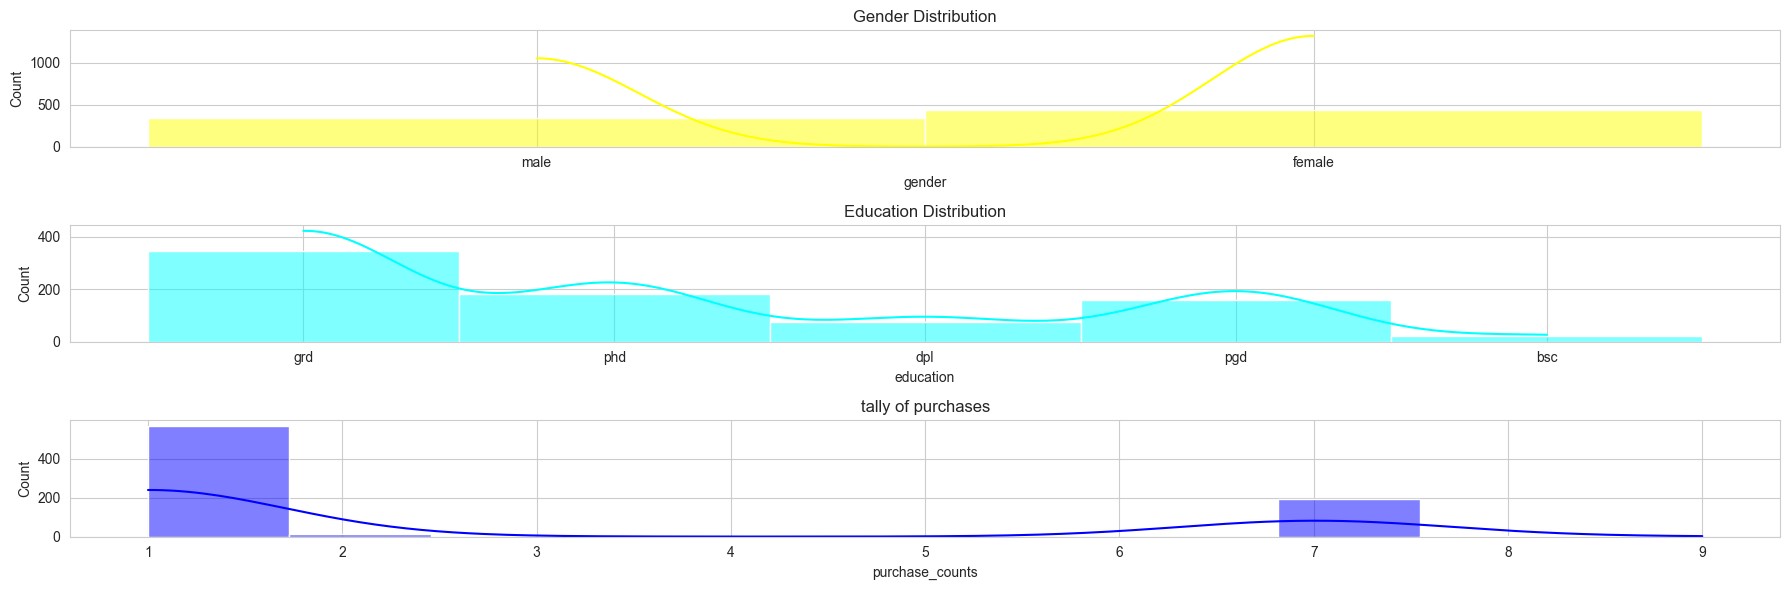

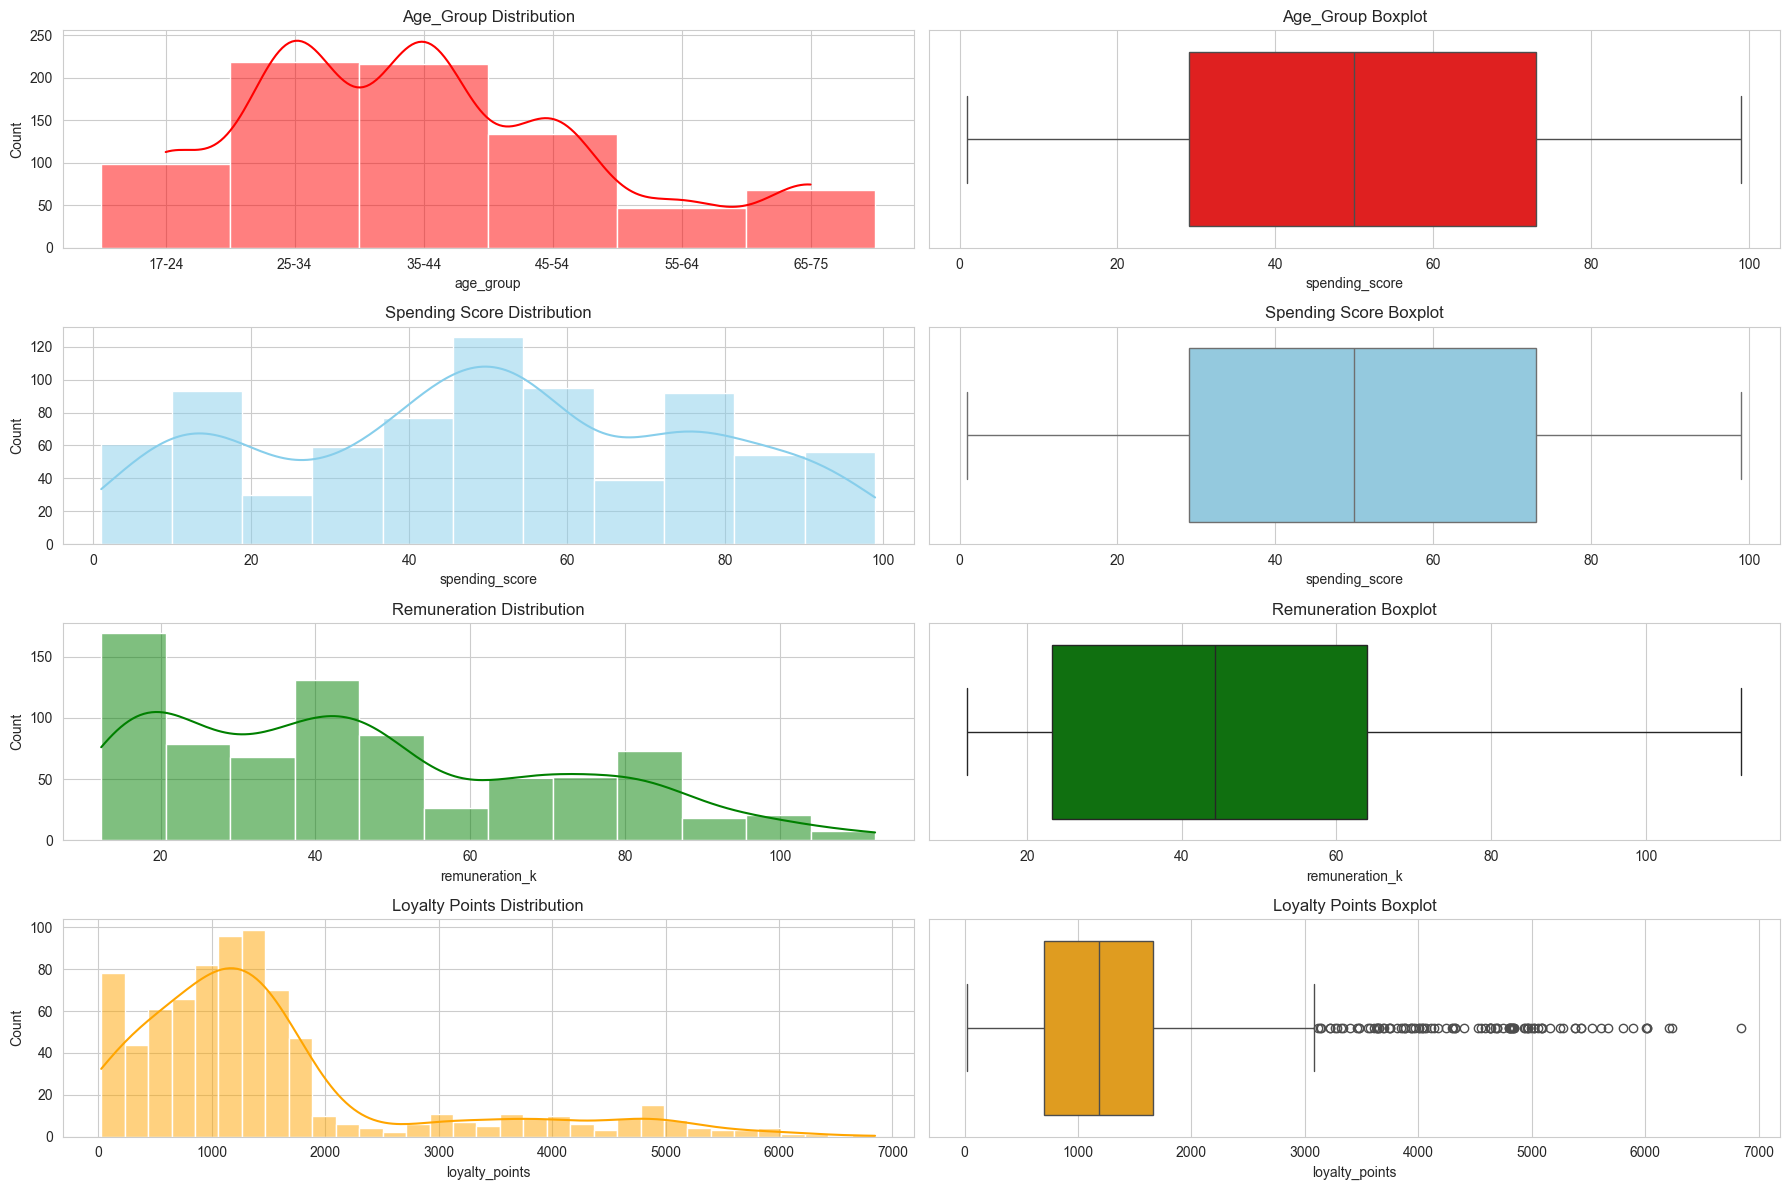

In [141]:
# Plot histograms for Education & Gender
fig, axes = plt.subplots(3, 1, figsize=(18, 6))
# Gender
sns.histplot(df_cust['gender'], kde=True, color='yellow', ax=axes[0])
axes[0].set_title('Gender Distribution')

# Education
sns.histplot(df_cust['education'], kde=True, color='cyan',  ax=axes[1])
axes[1].set_title('Education Distribution')

# Purchases
sns.histplot(df_cust['purchase_counts'], kde=True, color='blue',  ax=axes[2])
axes[2].set_title('tally of purchases')
plt.tight_layout()
plt.show()

# Plot histograms with KDE for age_group, spending_score, remuneration_k, and loyalty_points
fig, axes = plt.subplots(4, 2, figsize=(18, 12))
# Age Group
sns.histplot(df_cust['age_group'], kde=True, ax=axes[0, 0], color='red')
axes[0, 0].set_title('Age_Group Distribution')
sns.boxplot(x=df_cust['spending_score'], ax=axes[0, 1], color='red')
axes[0, 1].set_title('Age_Group Boxplot')

# Spending Score
sns.histplot(df_cust['spending_score'], kde=True, ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Spending Score Distribution')
sns.boxplot(x=df_cust['spending_score'], ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title('Spending Score Boxplot')

# Remuneration
sns.histplot(df_cust['remuneration_k'], kde=True, ax=axes[2, 0], color='green')
axes[2, 0].set_title('Remuneration Distribution')
sns.boxplot(x=df_cust['remuneration_k'], ax=axes[2, 1], color='green')
axes[2, 1].set_title('Remuneration Boxplot')

# Loyalty Points
sns.histplot(df_cust['loyalty_points'], kde=True, ax=axes[3, 0], color='orange')
axes[3, 0].set_title('Loyalty Points Distribution')
sns.boxplot(x=df_cust['loyalty_points'], ax=axes[3, 1], color='orange')
axes[3, 1].set_title('Loyalty Points Boxplot')

plt.tight_layout()
plt.show()

### Power Transformations on Loyalty Points (Log, SqRt, Yeo-Johnson, Box-Cox) <a id="7"></a>

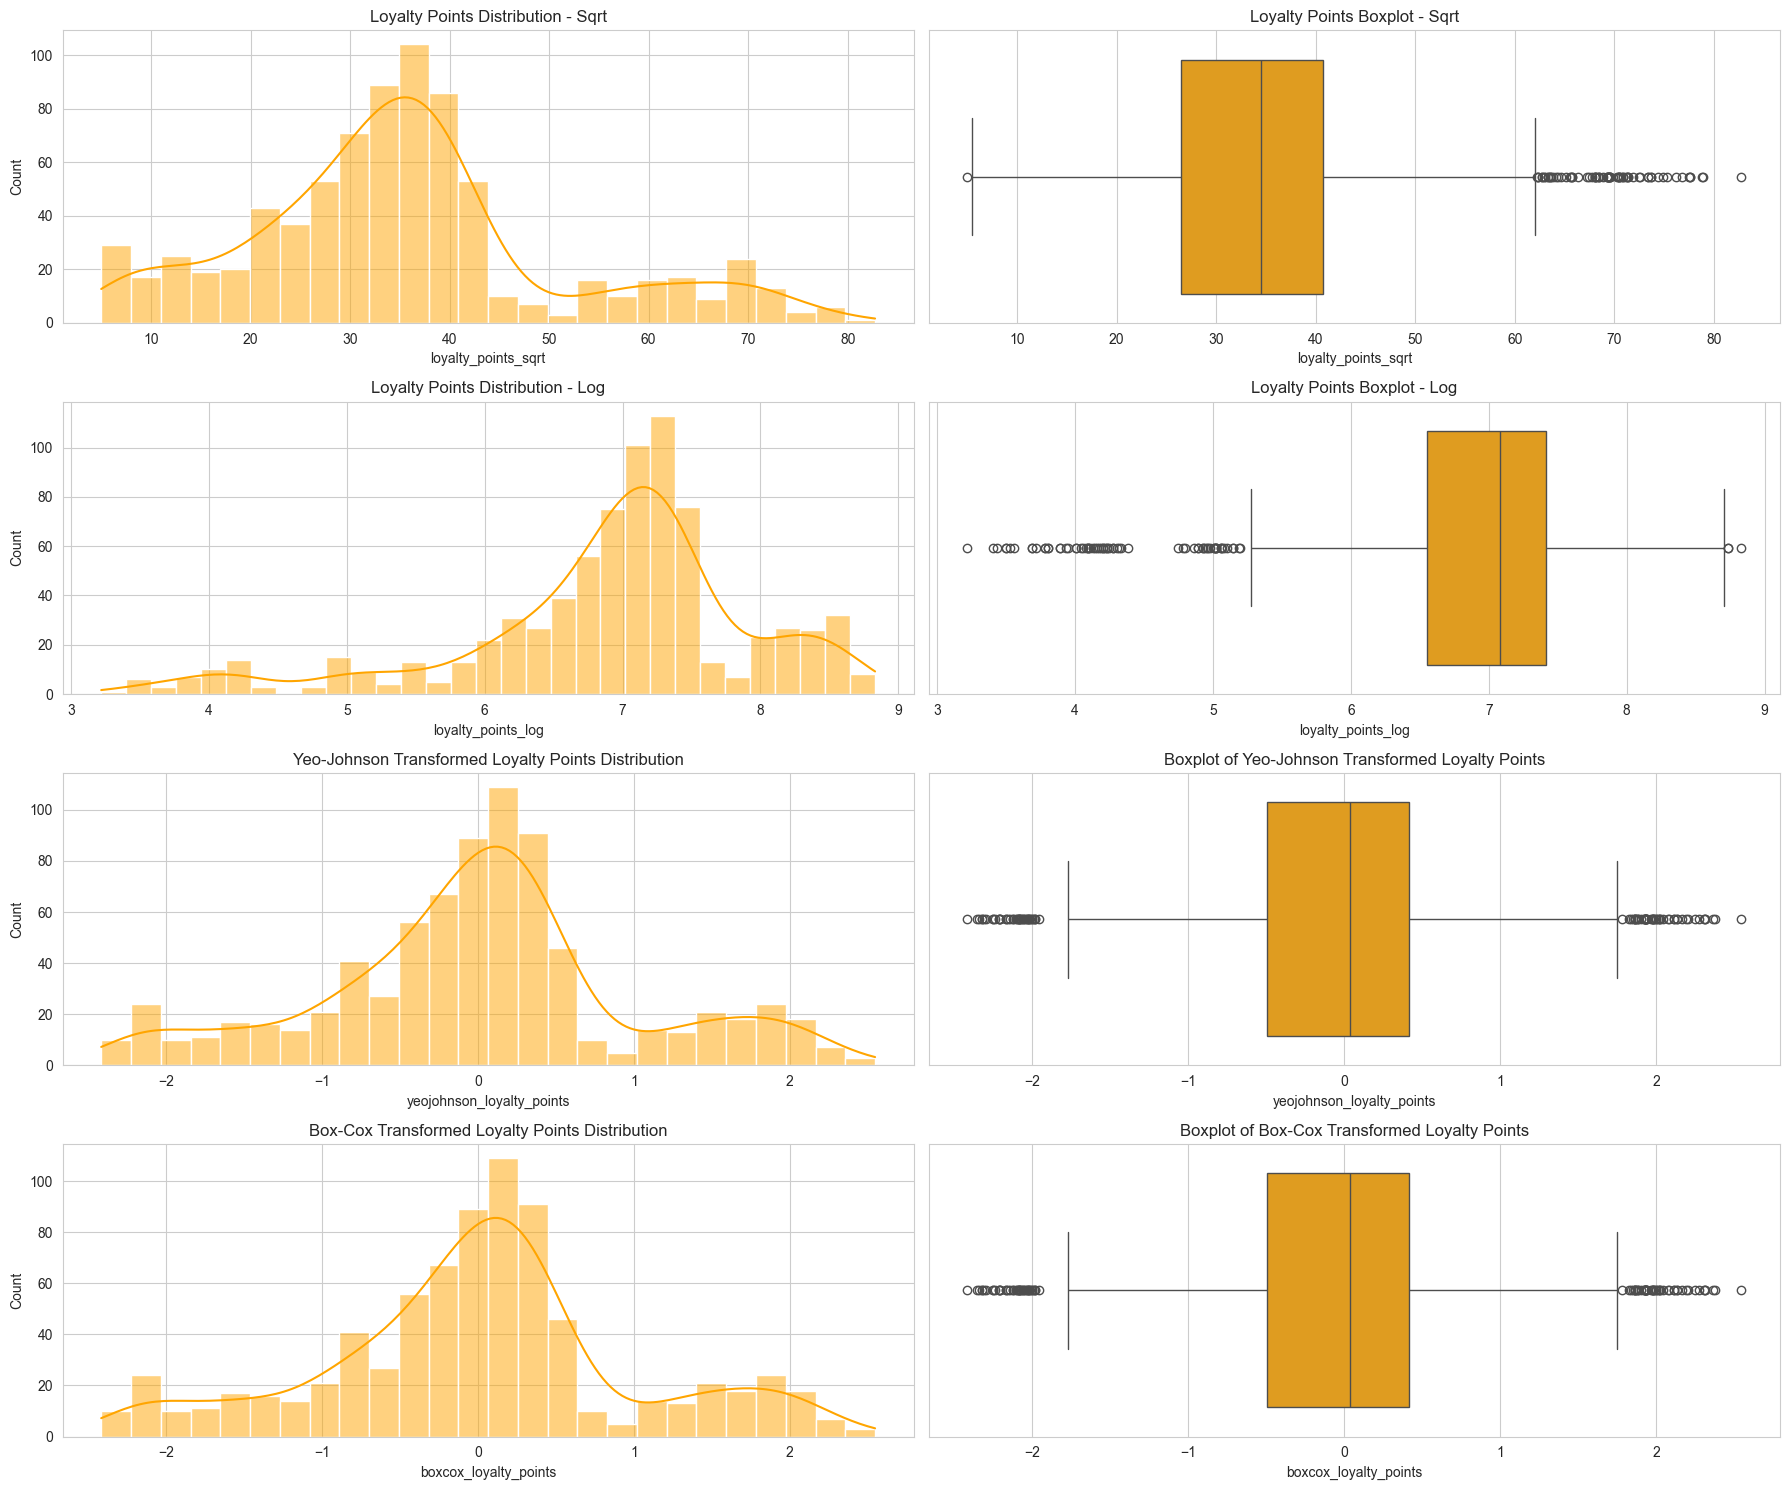

In [142]:
#Apply Log and SqRt power transformations
df_cust['loyalty_points_log'] = np.log(df_cust['loyalty_points'])
df_cust['loyalty_points_sqrt'] = np.sqrt(df_cust['loyalty_points'])
# Apply Yeo-Johnson transformation

# Create and fit the PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
pt_box = PowerTransformer(method='box-cox')
pt.fit(df_cust[['loyalty_points']])
pt_box.fit(df_cust[['loyalty_points']])
# Transform the target variable
df_cust['yeojohnson_loyalty_points'] = pt.transform(df_cust[['loyalty_points']])
df_cust['boxcox_loyalty_points'] = pt.transform(df_cust[['loyalty_points']])



fig, axes = plt.subplots(4, 2, figsize=(18, 15))

# Loyalty Points Histogram & Boxplot - Sqrt
sns.histplot(df_cust['loyalty_points_sqrt'], kde=True, color='orange', ax=axes[0, 0])
axes[0, 0].set_title('Loyalty Points Distribution - Sqrt')
sns.boxplot(x=df_cust['loyalty_points_sqrt'], color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Loyalty Points Boxplot - Sqrt')

# Loyalty Points Histogram & Boxplot - Log
sns.histplot(df_cust['loyalty_points_log'], kde=True, color='orange', ax=axes[1, 0])
axes[1, 0].set_title('Loyalty Points Distribution - Log')
sns.boxplot(x=df_cust['loyalty_points_log'], color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Loyalty Points Boxplot - Log')

# Loyalty Points Histogram & Boxplot - Yeo-Johnson
sns.histplot(df_cust['yeojohnson_loyalty_points'], kde=True, color='orange', ax=axes[2, 0])
axes[2, 0].set_title('Yeo-Johnson Transformed Loyalty Points Distribution')
sns.boxplot(x=df_cust['yeojohnson_loyalty_points'], color='orange', ax=axes[2, 1])
axes[2, 1].set_title('Boxplot of Yeo-Johnson Transformed Loyalty Points')

# Loyalty Points Histogram & Boxplot - Box-Cox
sns.histplot(df_cust['boxcox_loyalty_points'], kde=True, color='orange', ax=axes[3, 0])
axes[3, 0].set_title('Box-Cox Transformed Loyalty Points Distribution')
sns.boxplot(x=df_cust['boxcox_loyalty_points'], color='orange', ax=axes[3, 1])
axes[3, 1].set_title('Boxplot of Box-Cox Transformed Loyalty Points')

plt.tight_layout()
plt.show()

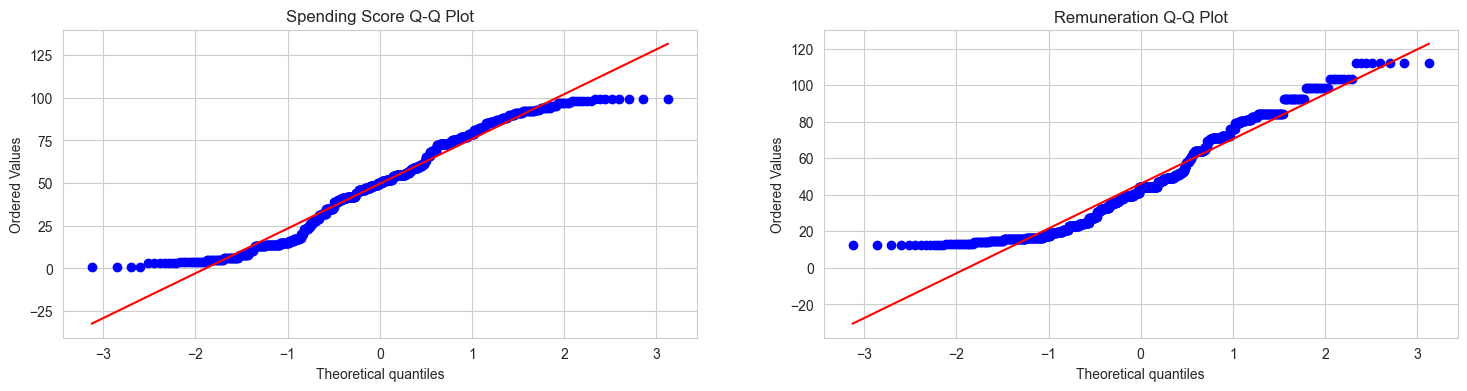

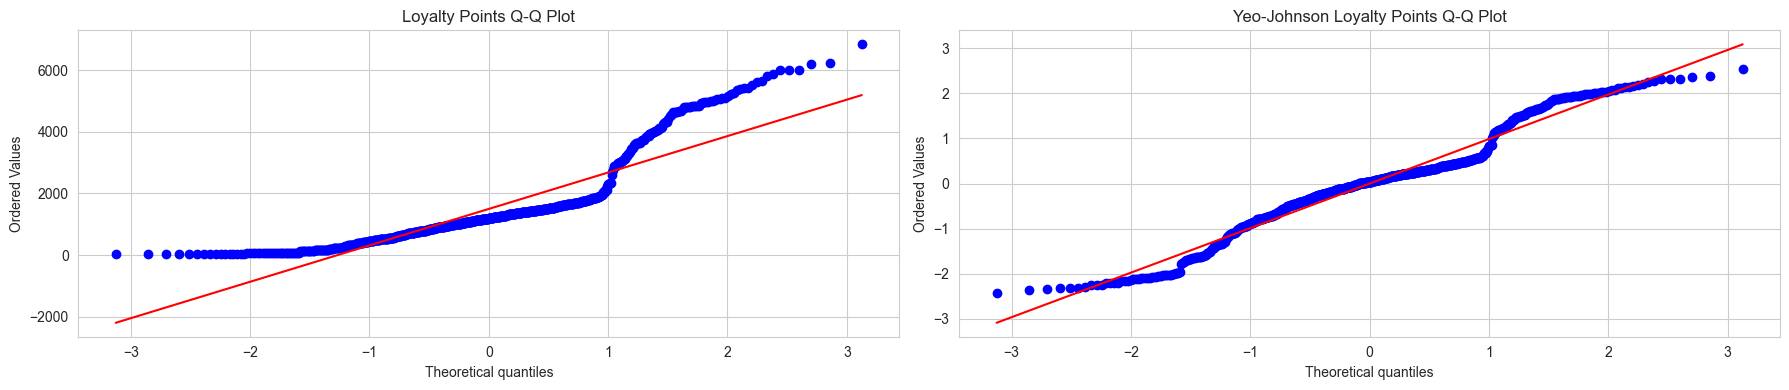

In [143]:
# Plot Q-Q plots
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

# Spending Score Q-Q Plot
stats.probplot(df_cust['spending_score'], dist="norm", plot=axes[0])
axes[0].set_title('Spending Score Q-Q Plot')

# Remuneration Q-Q Plot
stats.probplot(df_cust['remuneration_k'], dist="norm", plot=axes[1])
axes[1].set_title('Remuneration Q-Q Plot')

# Plot Q-Q plots
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
# Loyalty Points Q-Q Plot
stats.probplot(df_cust['loyalty_points'], dist="norm", plot=axes[0])
axes[0].set_title('Loyalty Points Q-Q Plot')

# Loyalty Points Q-Q Plot
stats.probplot(df_cust['yeojohnson_loyalty_points'], dist="norm", plot=axes[1])
axes[1].set_title('Yeo-Johnson Loyalty Points Q-Q Plot')

plt.tight_layout()
plt.show()

## 8. Simple Regression Analysis <a id="create_simple_model"></a> <a id="8"></a> 

### Ordinary Least Squares & Bayesian Linear Regression
### 8a. Spending Score <a id="8a"></a>
###### [Return to Functions](#2)

In [144]:
# Initialize the global dictionary to store metrics
model_metrics = {}

Regression Table for spending_score (OLS):
                Coefficient  Standard Error
const            -55.734423       91.211592
spending_score    31.017918        1.641485
                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     357.1
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           1.26e-61
Time:                        15:13:19   Log-Likelihood:                -4555.1
No. Observations:                 547   AIC:                             9114.
Df Residuals:                     545   BIC:                             9123.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std er

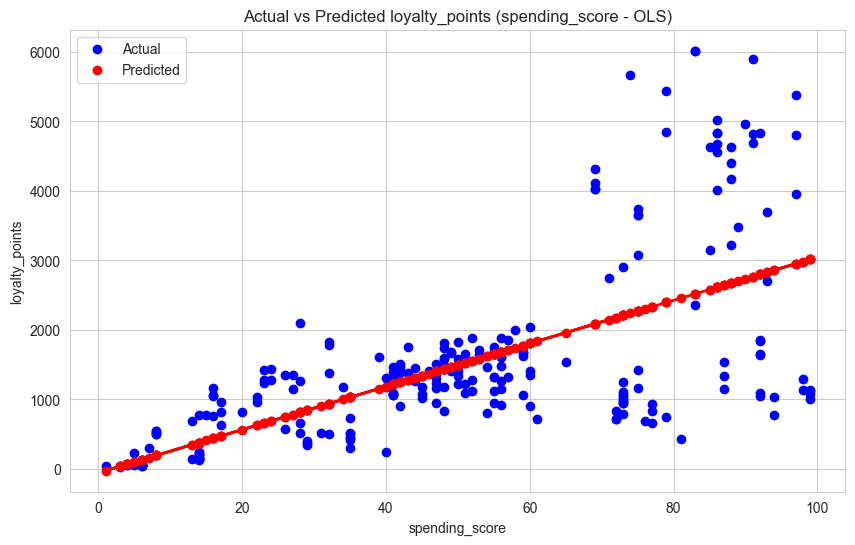

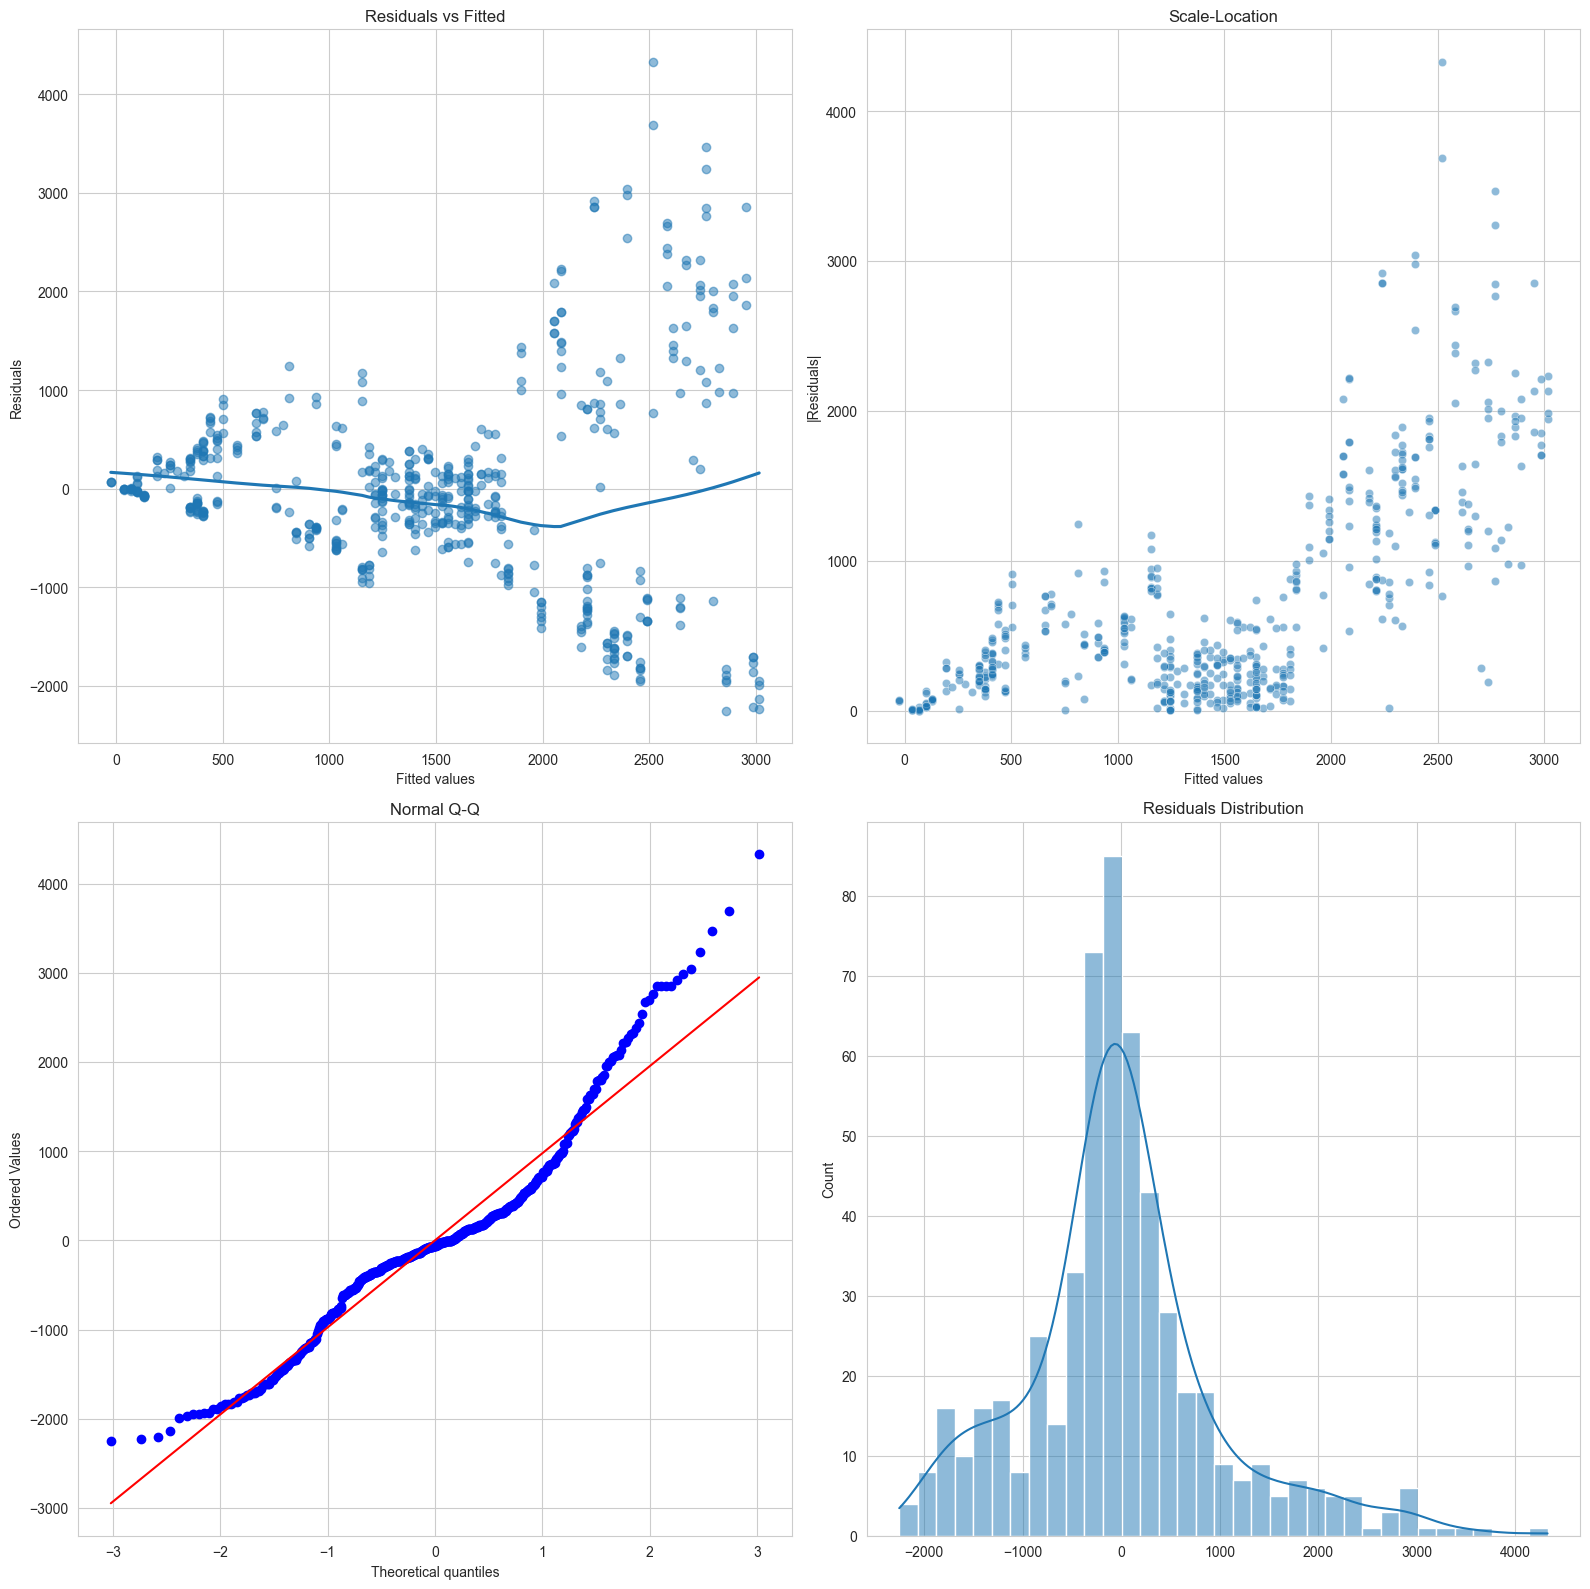


Assumption Test Results:
Normality: Failed - p-value <= 0.05
  p-value: 1.3957206226981428e-13
Homoscedasticity: Failed - p-value <= 0.05
  p-value: 1.2647833781545975e-40
Multicollinearity: Passed - Only one feature present
  Not applicable for single feature
Regression Table for spending_score (Bayesian Linear Regression):
                Coefficient  Standard Error
const            -51.481542        1.637687
spending_score    30.931209        1.637687

Bayesian Linear Regression Summary:
Number of samples: 547
Number of features: 1
Alpha: 9.967033183068092e-07
Lambda: 0.0010422966187628108
R-squared for BLR: 0.4043099123423841
Mean Squared Error for BLR: 1111187.1589429274


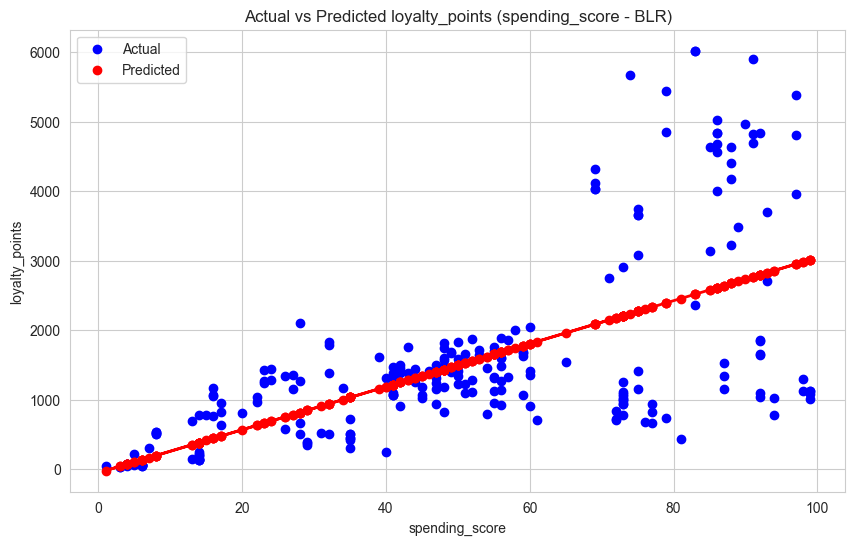

c:\Users\willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but BayesianRidge was fitted without feature names

c:\Users\willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but BayesianRidge was fitted without feature names



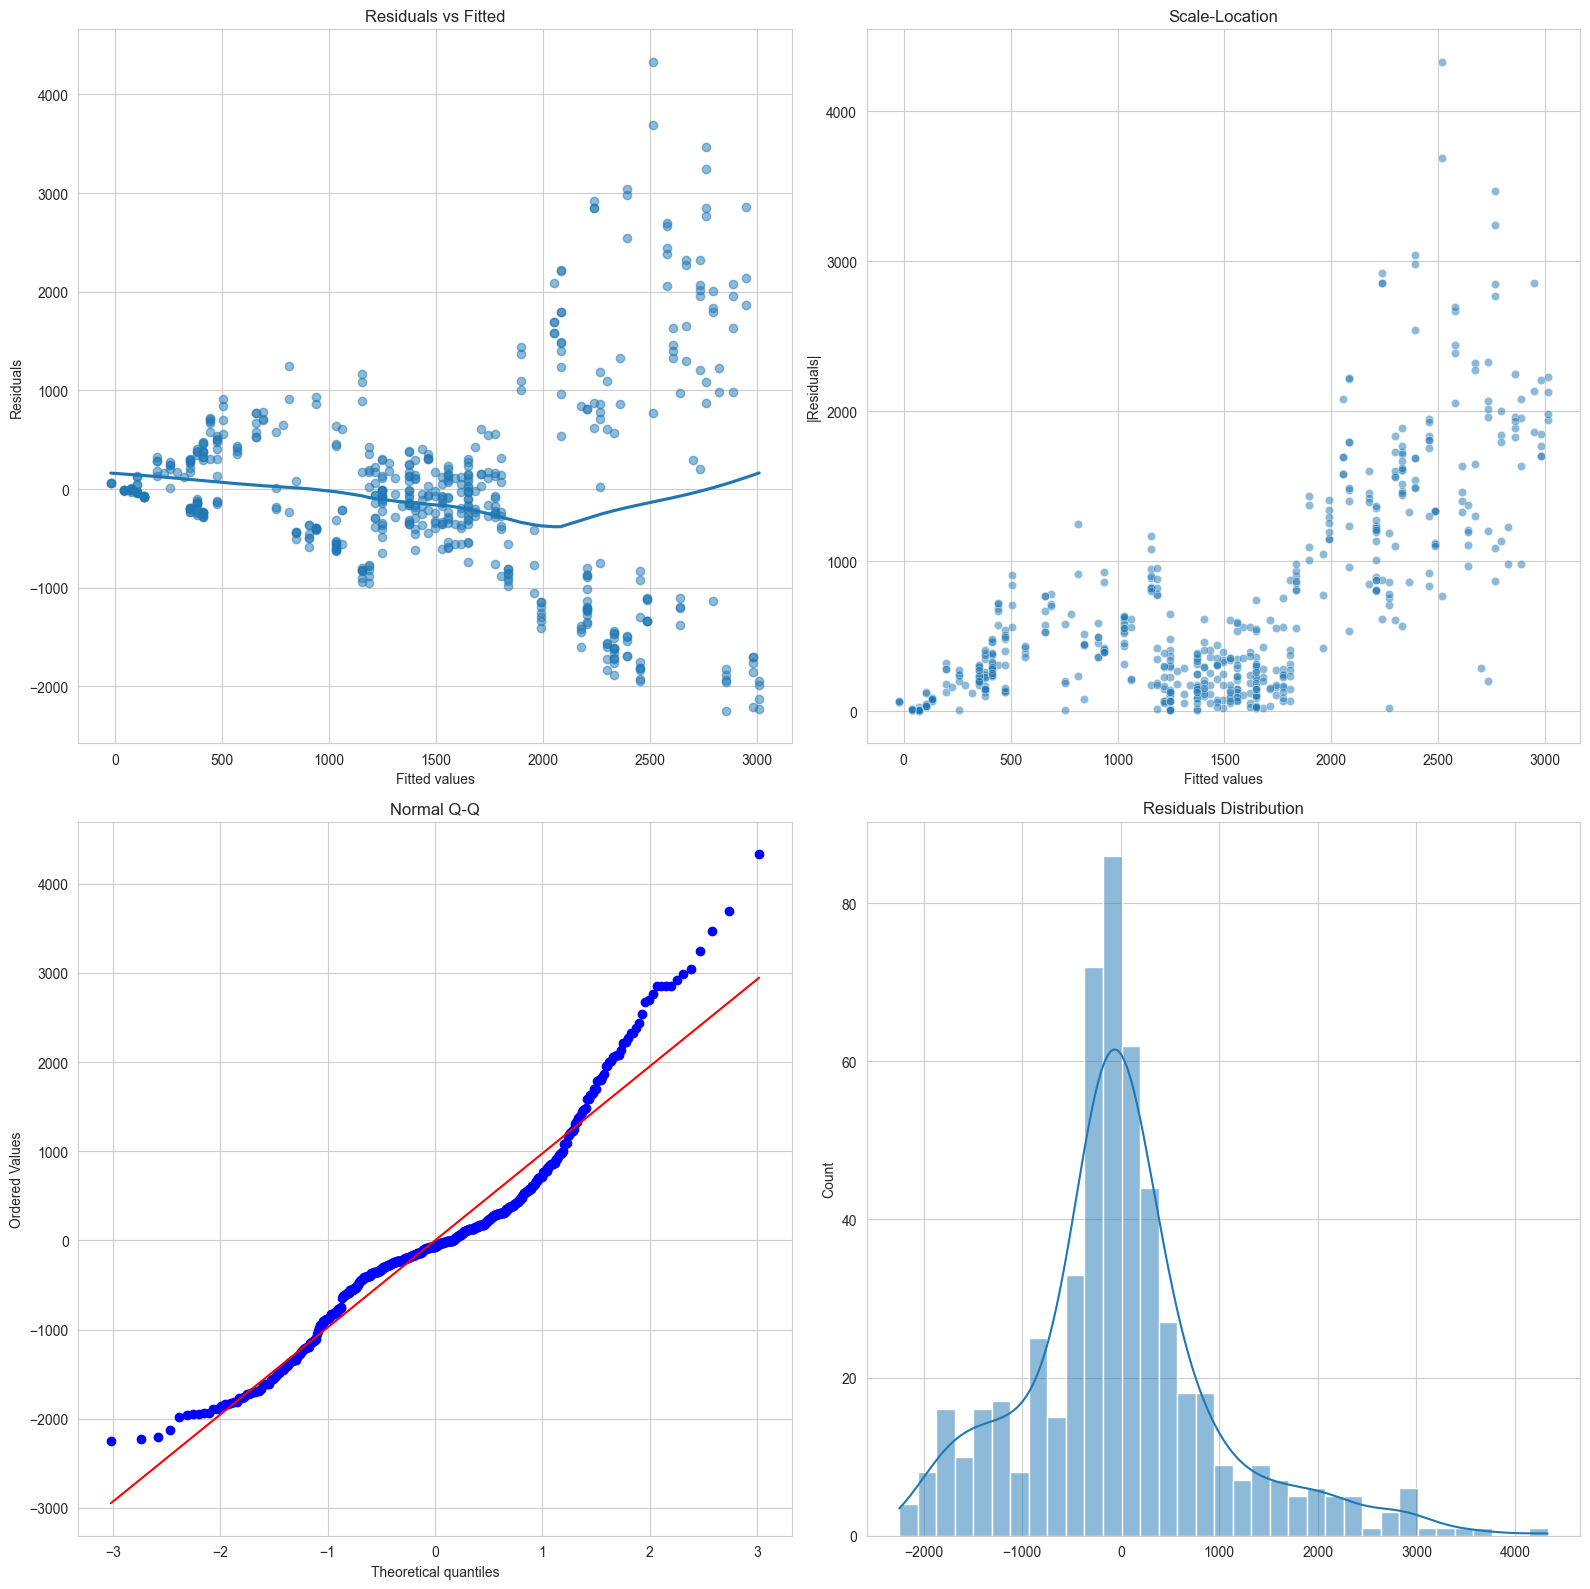


Assumption Test Results:
Normality: Failed - p-value <= 0.05
  p-value: 1.2130992765658982e-13
Homoscedasticity: Failed - p-value <= 0.05
  p-value: 1.4346580572458813e-40
Multicollinearity: Passed - Only one feature present
  Not applicable for single feature


In [145]:
model, x_train, y_train, r_squared = create_simple_model('spending_score', 'loyalty_points', 'OLS', model_name='SRM-OLS-Spend')
results = validate_assumptions(x_train, y_train, model, model_type='OLS')

model, x_train, y_train, r_squared = create_simple_model('spending_score', 'loyalty_points', 'BLR', model_name = 'SRM-BLR-Spend')
results = validate_assumptions(x_train, y_train, model, model_type='BLR')

### 8b. Renumeration <a id="8b"></a>

Regression Table for remuneration_k (OLS):
                Coefficient  Standard Error
const              1.524251        89.87383
remuneration_k    32.067823         1.72667
                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     344.9
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           5.10e-60
Time:                        15:13:20   Log-Likelihood:                -4558.8
No. Observations:                 547   AIC:                             9122.
Df Residuals:                     545   BIC:                             9130.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std er

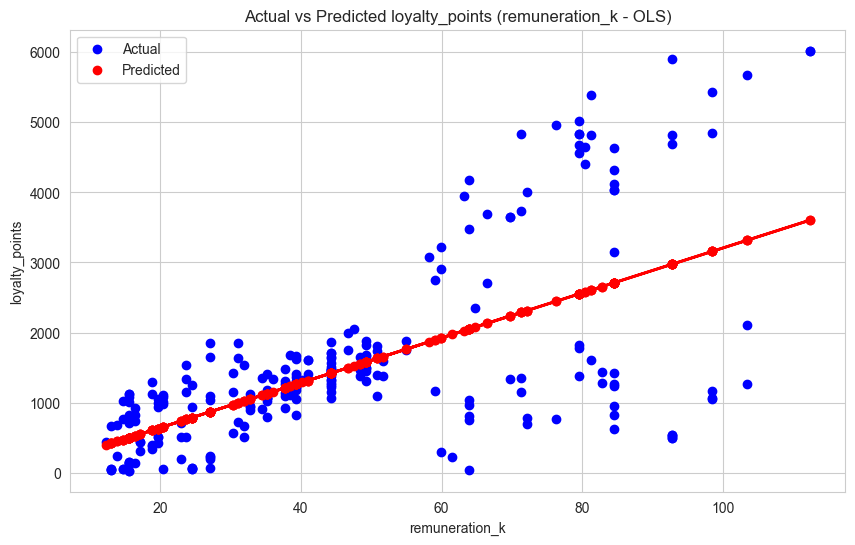

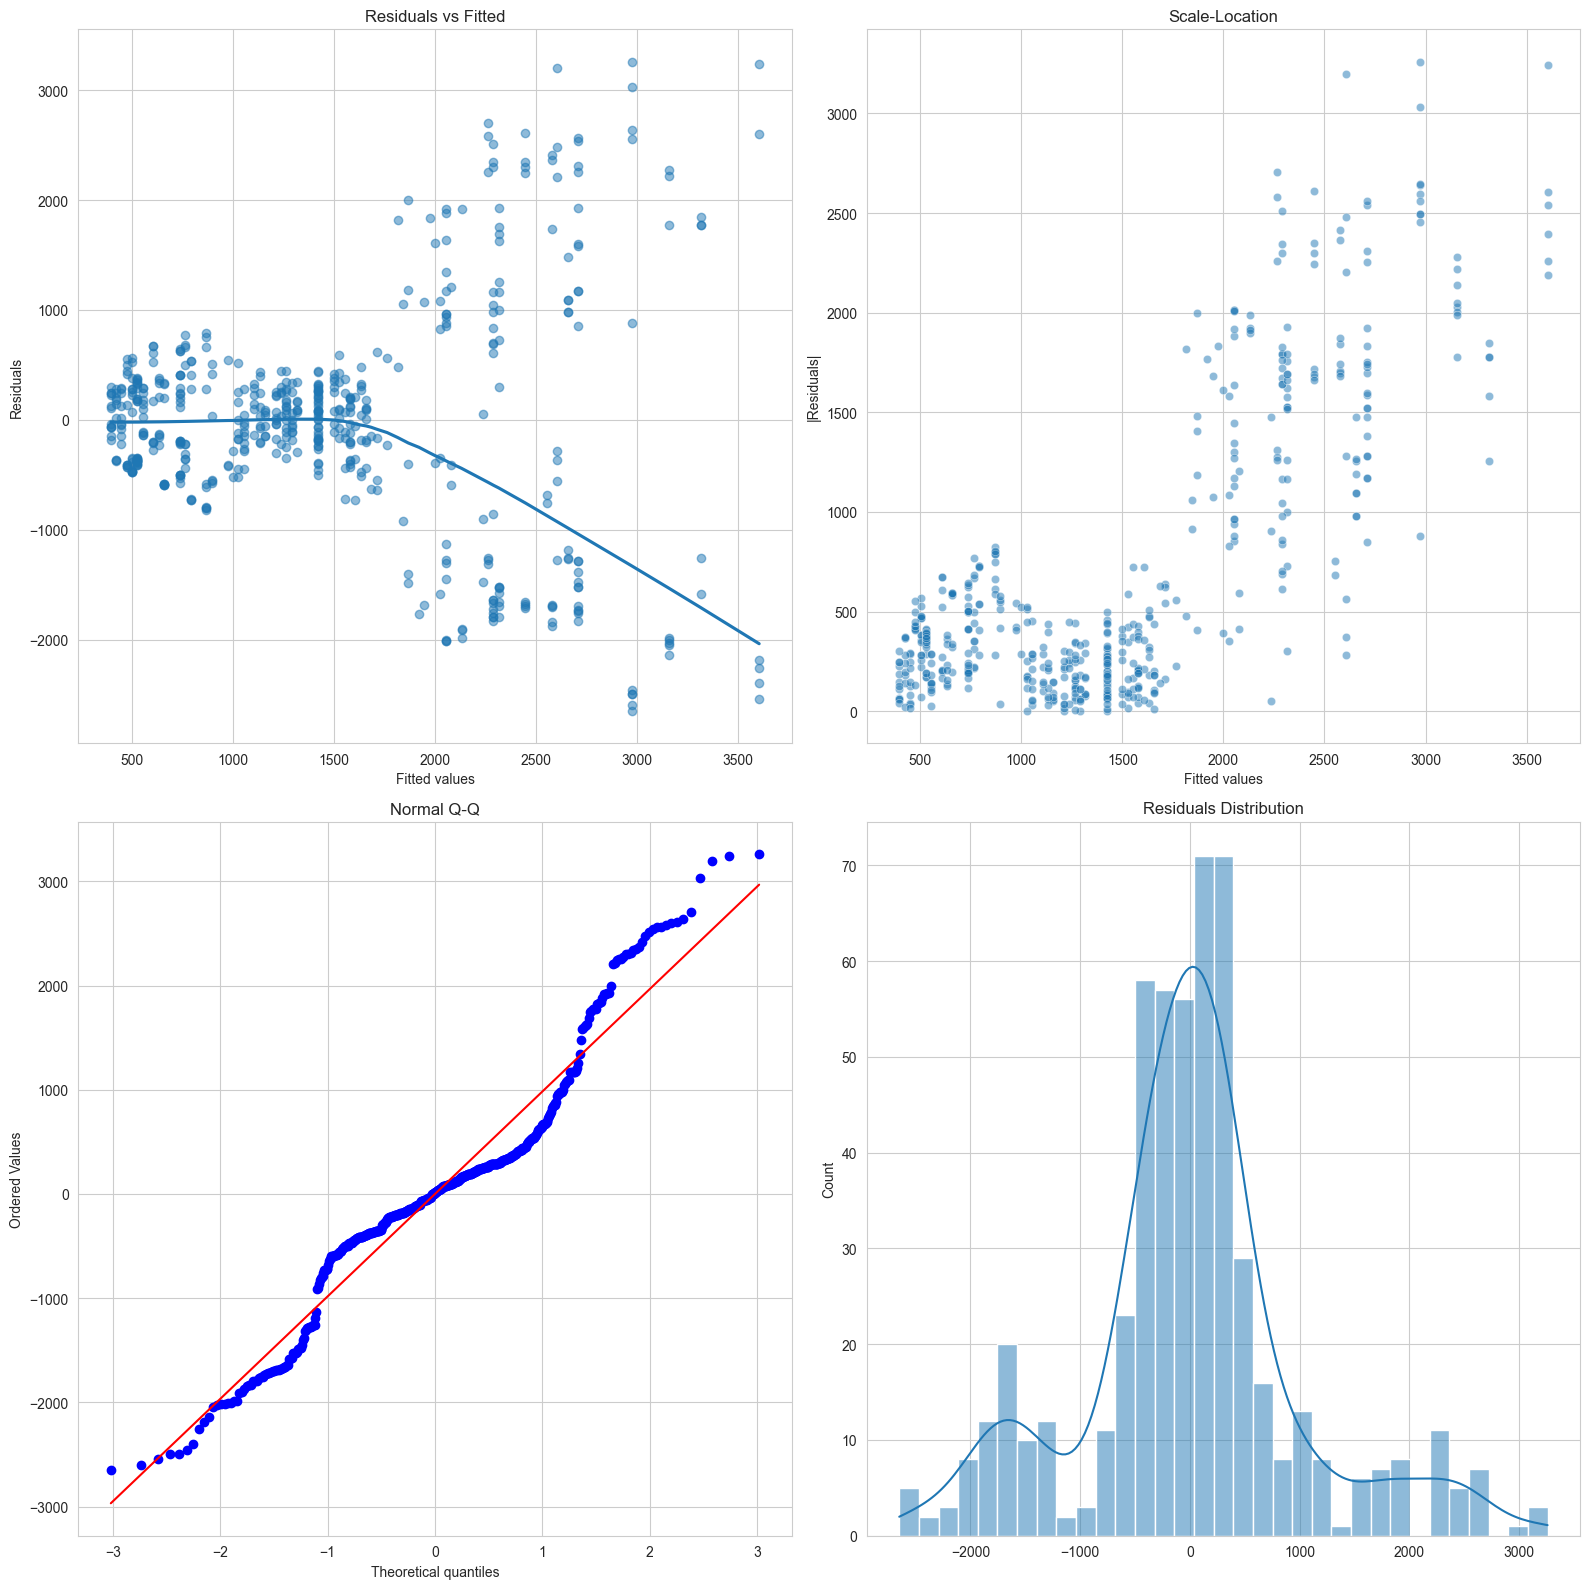


Assumption Test Results:
Normality: Failed - p-value <= 0.05
  p-value: 1.0266892999281185e-13
Homoscedasticity: Failed - p-value <= 0.05
  p-value: 2.856837918905898e-63
Multicollinearity: Passed - Only one feature present
  Not applicable for single feature
Regression Table for remuneration_k (Bayesian Linear Regression):
                Coefficient  Standard Error
const              5.761199         1.72259
remuneration_k    31.975021         1.72259

Bayesian Linear Regression Summary:
Number of samples: 547
Number of features: 1
Alpha: 9.832823408115034e-07
Lambda: 0.0009752603233511115
R-squared for BLR: 0.4156941945503756
Mean Squared Error for BLR: 1089951.1698516107


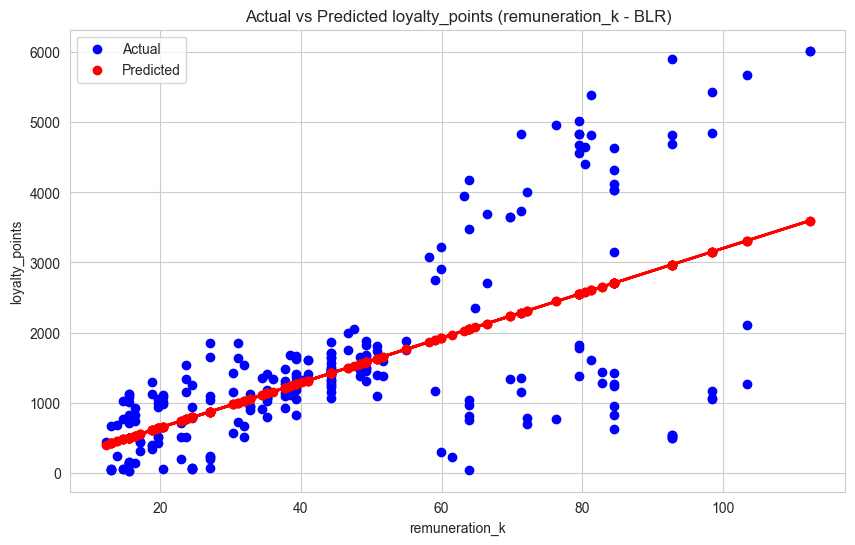

c:\Users\willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but BayesianRidge was fitted without feature names

c:\Users\willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but BayesianRidge was fitted without feature names



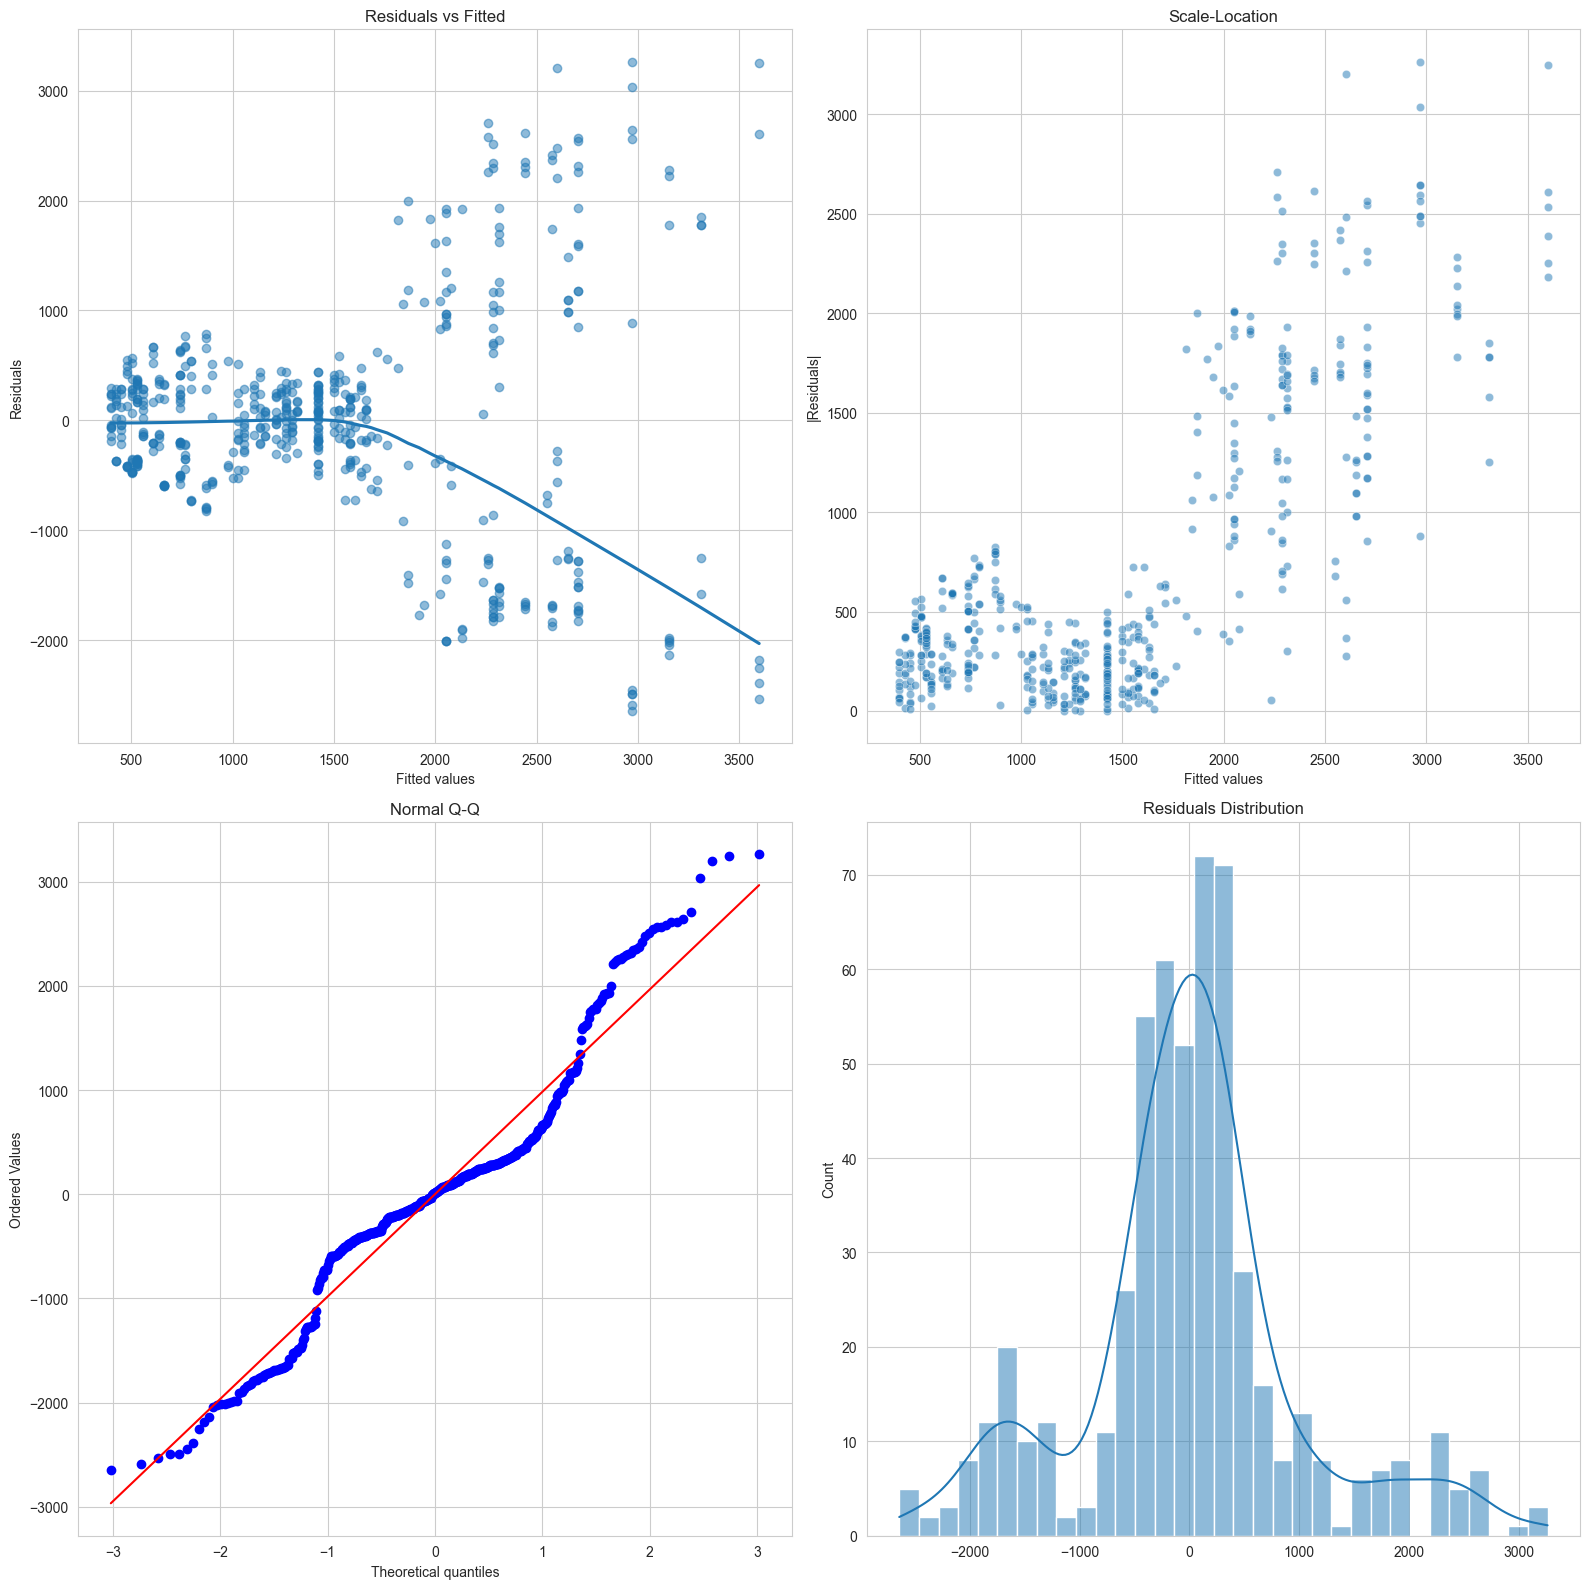


Assumption Test Results:
Normality: Failed - p-value <= 0.05
  p-value: 9.893625367964991e-14
Homoscedasticity: Failed - p-value <= 0.05
  p-value: 3.5400273165954347e-63
Multicollinearity: Passed - Only one feature present
  Not applicable for single feature


In [146]:
model, x_train, y_train, r_squared = create_simple_model('remuneration_k', 'loyalty_points', 'OLS',  model_name='SRM-OLS-Renum')
results = validate_assumptions(x_train, y_train, model, model_type='OLS')

model, x_train, y_train, r_squared = create_simple_model('remuneration_k', 'loyalty_points', 'BLR', model_name='SRM-BLR-Renum')
results = validate_assumptions(x_train, y_train, model, model_type='BLR')

# 9. Multiple Linear Regression <a id="9"></a> 
## w/ OLS & BLR
###### [Return to Top](#top)

#### 9a. No Transformation <a id="9a"></a> 

Shape of X: (782, 12)
Shape of y: (782,)
Shape of x_train: (547, 12)
Shape of y_train: (547,)
Regression Table for Multiple Linear Regression (OLS):
                 Coefficient  Standard Error
const           -2089.567327      197.557627
remuneration_k     32.464220        0.948672
spending_score     32.110578        0.917669
gender_male       -33.632045       48.582947
age_group_25-34   328.567343       80.415620
age_group_35-44   495.342413       80.480492
age_group_45-54   632.703701       90.722952
age_group_55-64   555.774376      116.799629
age_group_65-75   451.181725      109.584207
education_dpl     232.134416      191.291997
education_grd     127.524727      180.669778
education_pgd      78.663992      184.889195
education_phd      37.868009      185.380450
                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:        

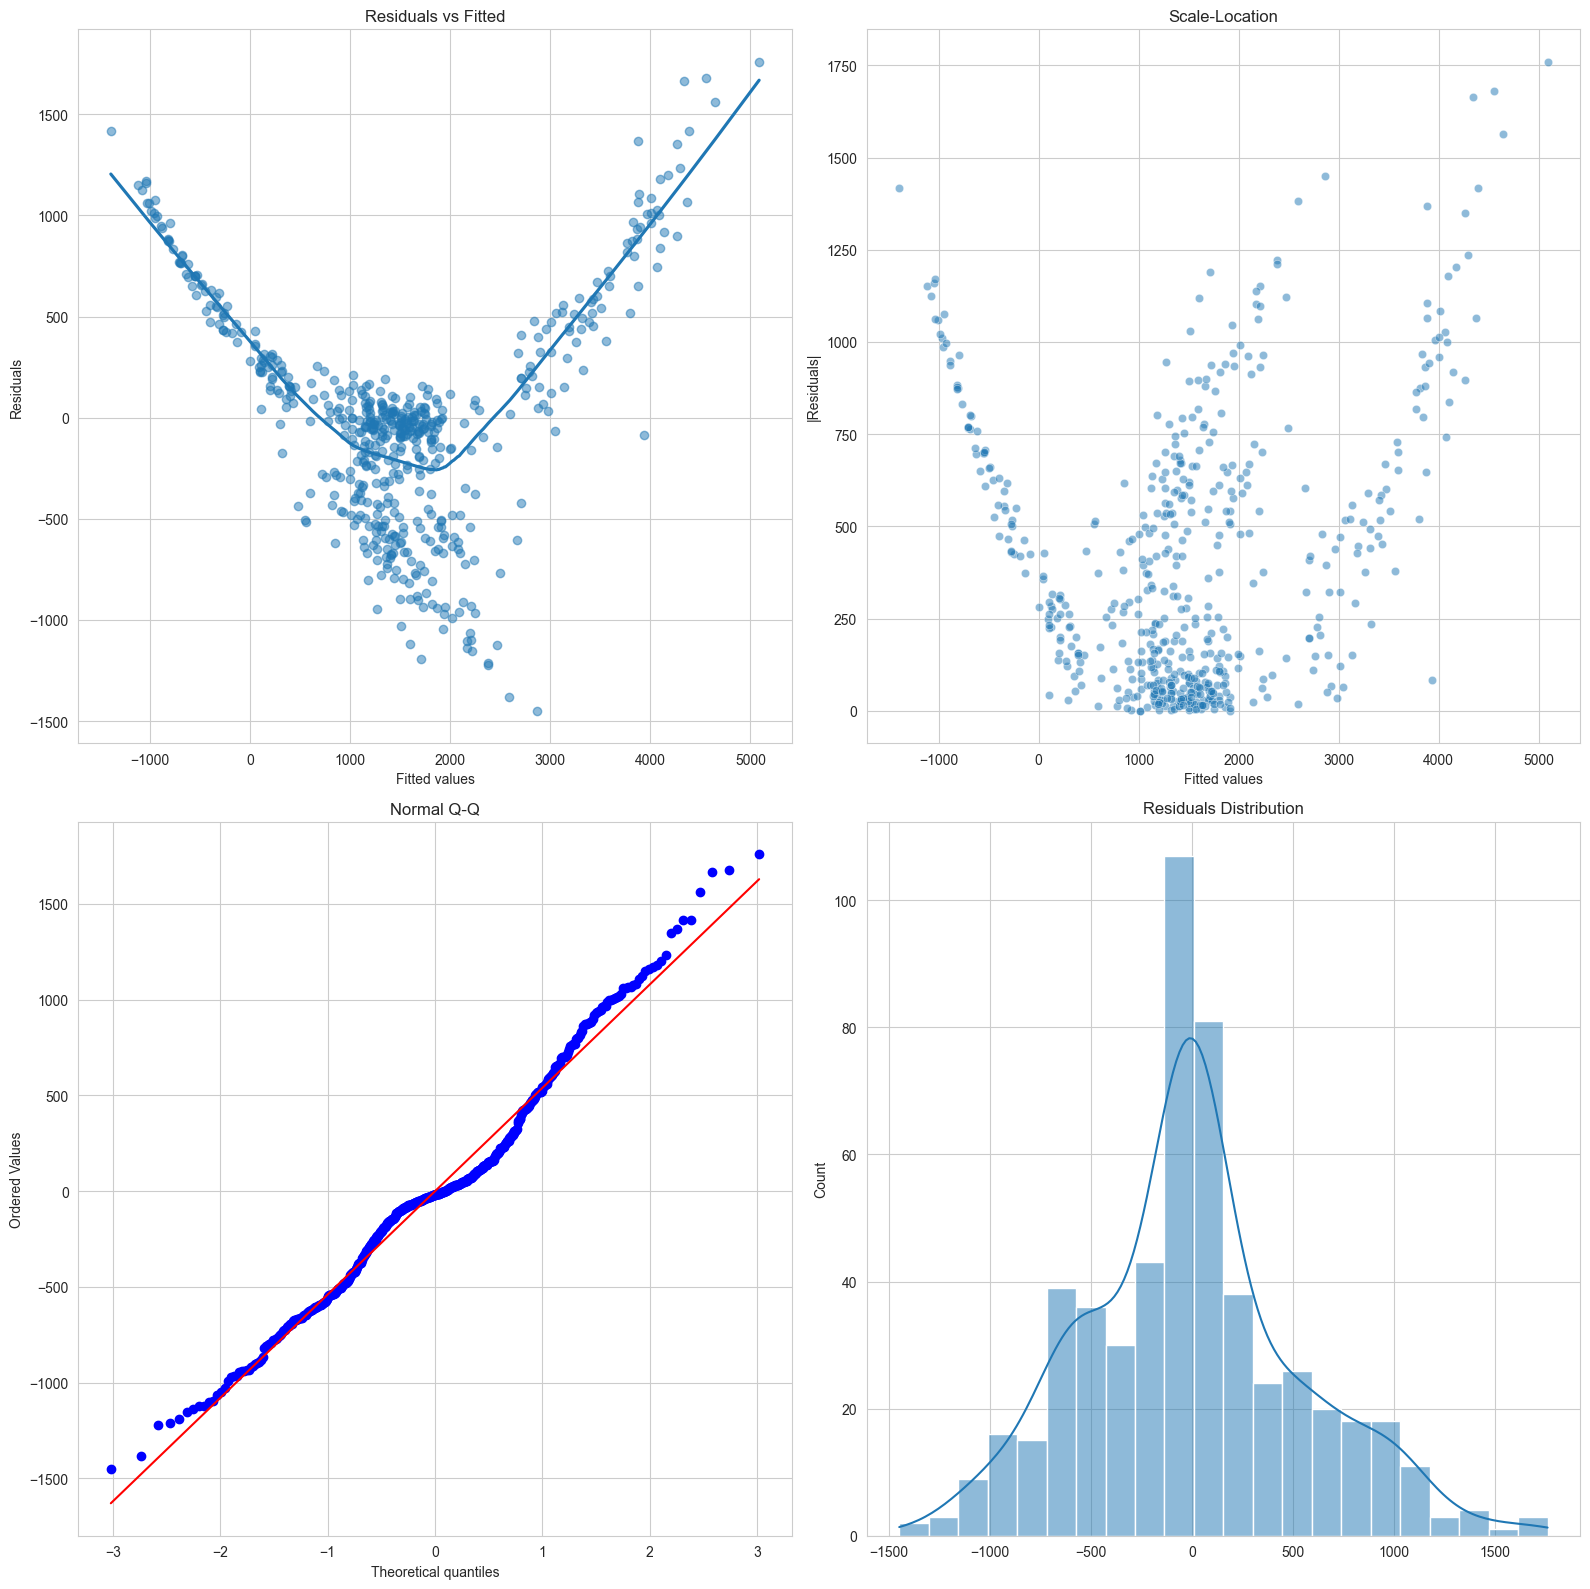

Variance Inflation Factors:
            Feature       VIF
0    remuneration_k  4.285590
1    spending_score  4.632821
2       gender_male  1.929848
3   age_group_25-34  3.070992
4   age_group_35-44  2.977793
5   age_group_45-54  2.226335
6   age_group_55-64  1.445263
7   age_group_65-75  1.569263
8     education_dpl  2.198737
9     education_grd  6.433333
10    education_pgd  3.505630
11    education_phd  3.472141

Assumption Test Results:
Normality: Failed - p-value <= 0.05
  p-value: 4.373784124978795e-06
Homoscedasticity: Failed - p-value <= 0.05
  p-value: 1.0455818713367733e-06
Multicollinearity: Passed - All VIF < 10
  Max VIF: 6.43
R-squared: 0.8163090068196356
Mean Squared Error: 342653.1296468589
Shape of X: (782, 12)
Shape of y: (782,)
Shape of x_train: (547, 12)
Shape of y_train: (547,)
Number of features: 12
Number of coefficients: 12
Intercept: -1884.8643607400295
Regression Table for Multiple Linear Regression (Bayesian Linear Regression):
                 Coefficient  St

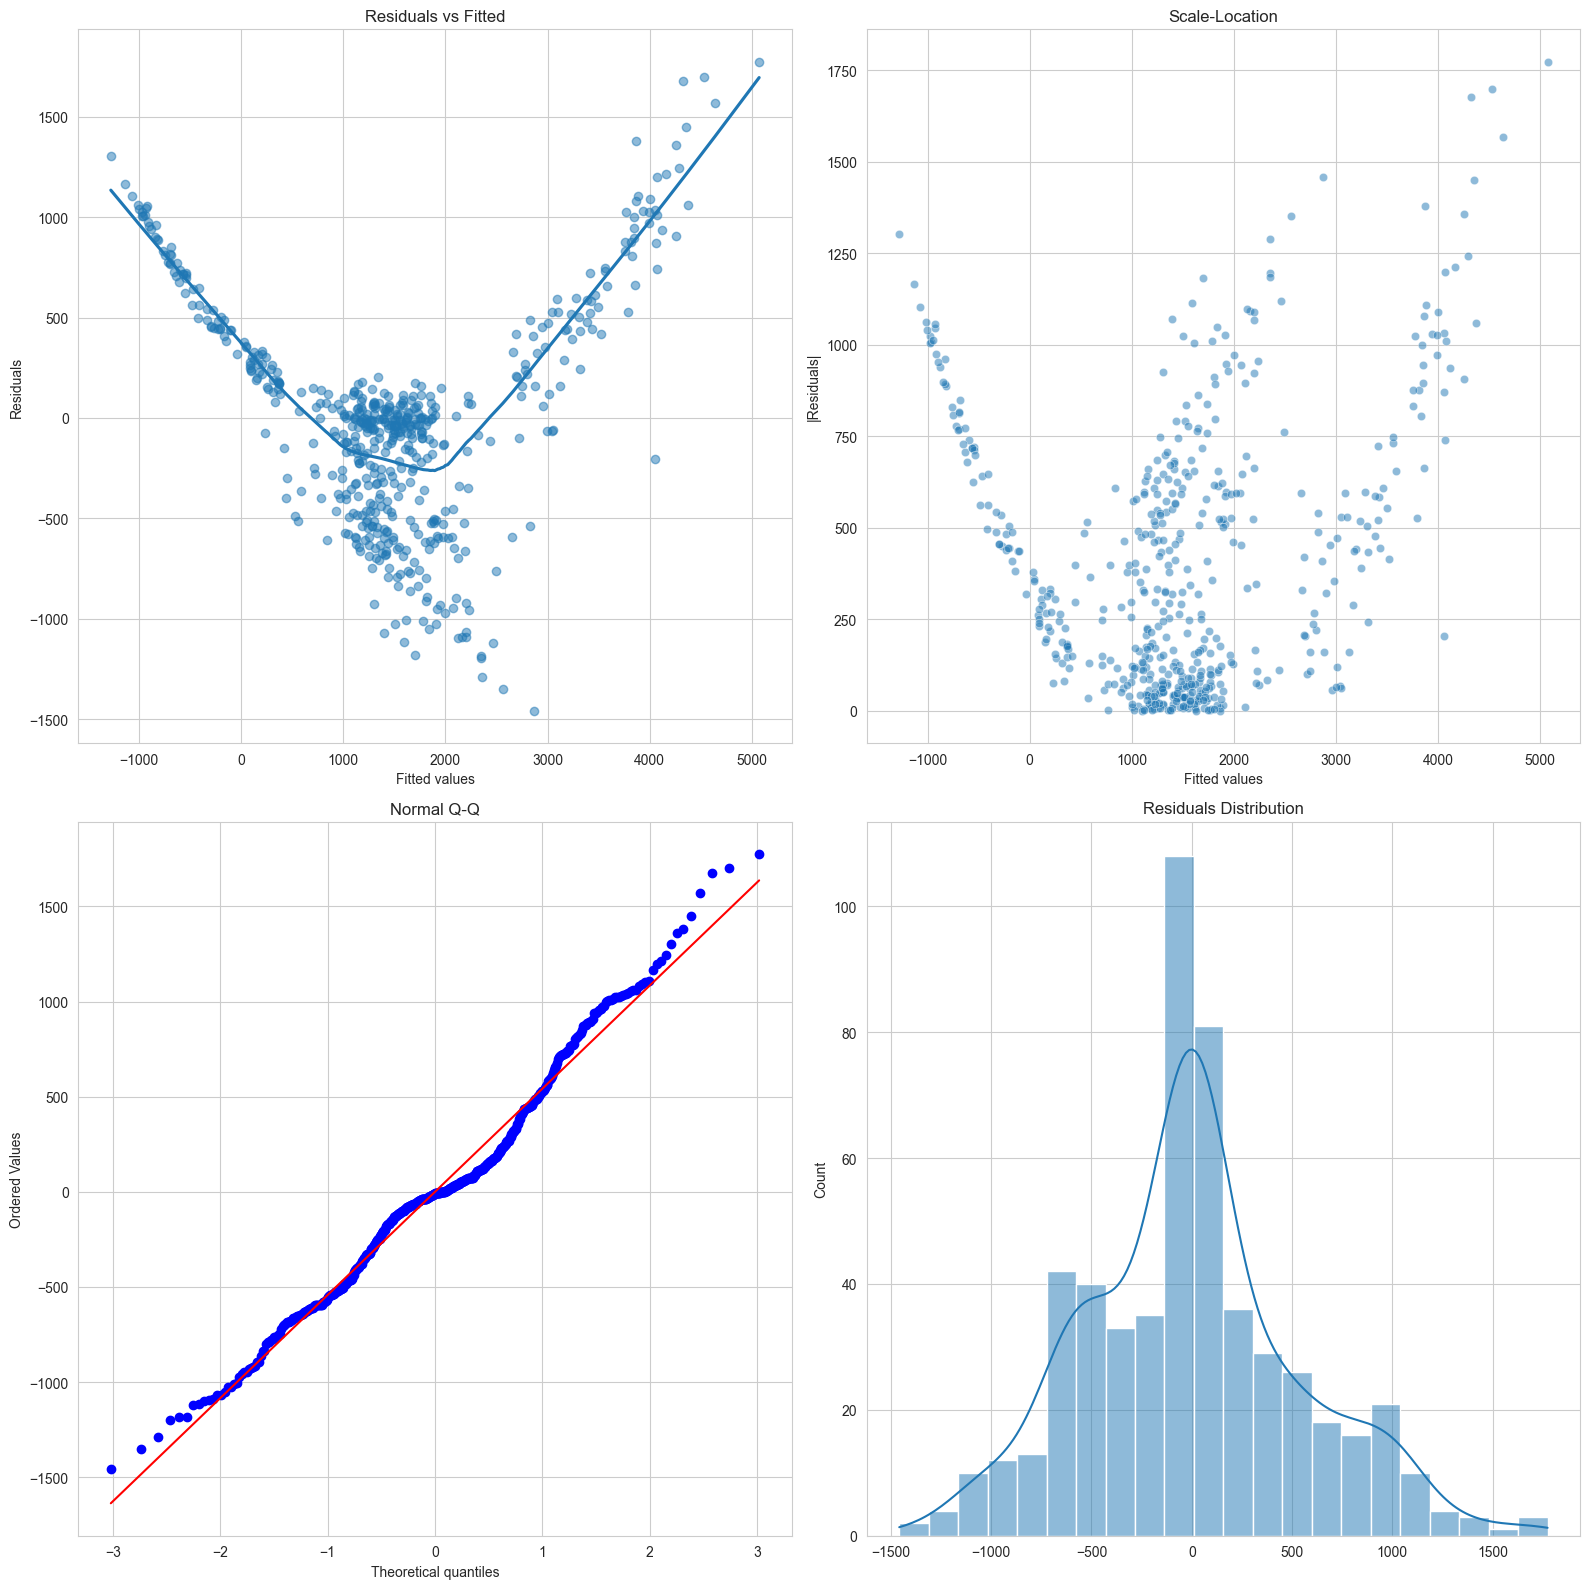

Variance Inflation Factors:
            Feature       VIF
0    remuneration_k  4.285590
1    spending_score  4.632821
2       gender_male  1.929848
3   age_group_25-34  3.070992
4   age_group_35-44  2.977793
5   age_group_45-54  2.226335
6   age_group_55-64  1.445263
7   age_group_65-75  1.569263
8     education_dpl  2.198737
9     education_grd  6.433333
10    education_pgd  3.505630
11    education_phd  3.472141

Assumption Test Results:
Normality: Failed - p-value <= 0.05
  p-value: 5.981704987342549e-06
Homoscedasticity: Failed - p-value <= 0.05
  p-value: 1.4986519240492514e-07
Multicollinearity: Passed - All VIF < 10
  Max VIF: 6.43
R-squared: 0.8159810229881153
Mean Squared Error: 343264.943456552


In [147]:
features = ['remuneration_k', 'spending_score', 'gender_male', 'age_group_25-34', 
            'age_group_35-44', 'age_group_45-54', 'age_group_55-64', 'age_group_65-75', 
            'education_dpl', 'education_grd', 'education_pgd', 'education_phd']
target = 'loyalty_points'

model, x_train, y_train, r_squared, assumption_results = create_and_evaluate_regression_model(
    features, target, model_type='OLS', target_transformer=None, model_name='MLR-OLS'
)

model, x_train, y_train, r_squared, assumption_results = create_and_evaluate_regression_model(
    features, target, model_type='BLR', target_transformer=None, model_name='MLR-BLR'
)

### 9b. Yeo-Johnson Power Transformation <a id="9b"></a> 

Shape of X: (782, 12)
Shape of y: (782,)
Shape of x_train: (547, 12)
Shape of y_train: (547,)
Regression Table for Multiple Linear Regression (OLS):
                 Coefficient  Standard Error
const              -2.822234        0.109205
remuneration_k      0.024608        0.000524
spending_score      0.027940        0.000507
gender_male        -0.052081        0.026855
age_group_25-34     0.251897        0.044452
age_group_35-44     0.370356        0.044488
age_group_45-54     0.525772        0.050149
age_group_55-64     0.504920        0.064564
age_group_65-75     0.293368        0.060575
education_dpl       0.077498        0.105741
education_grd       0.040732        0.099870
education_pgd       0.032981        0.102202
education_phd       0.005581        0.102473
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:        

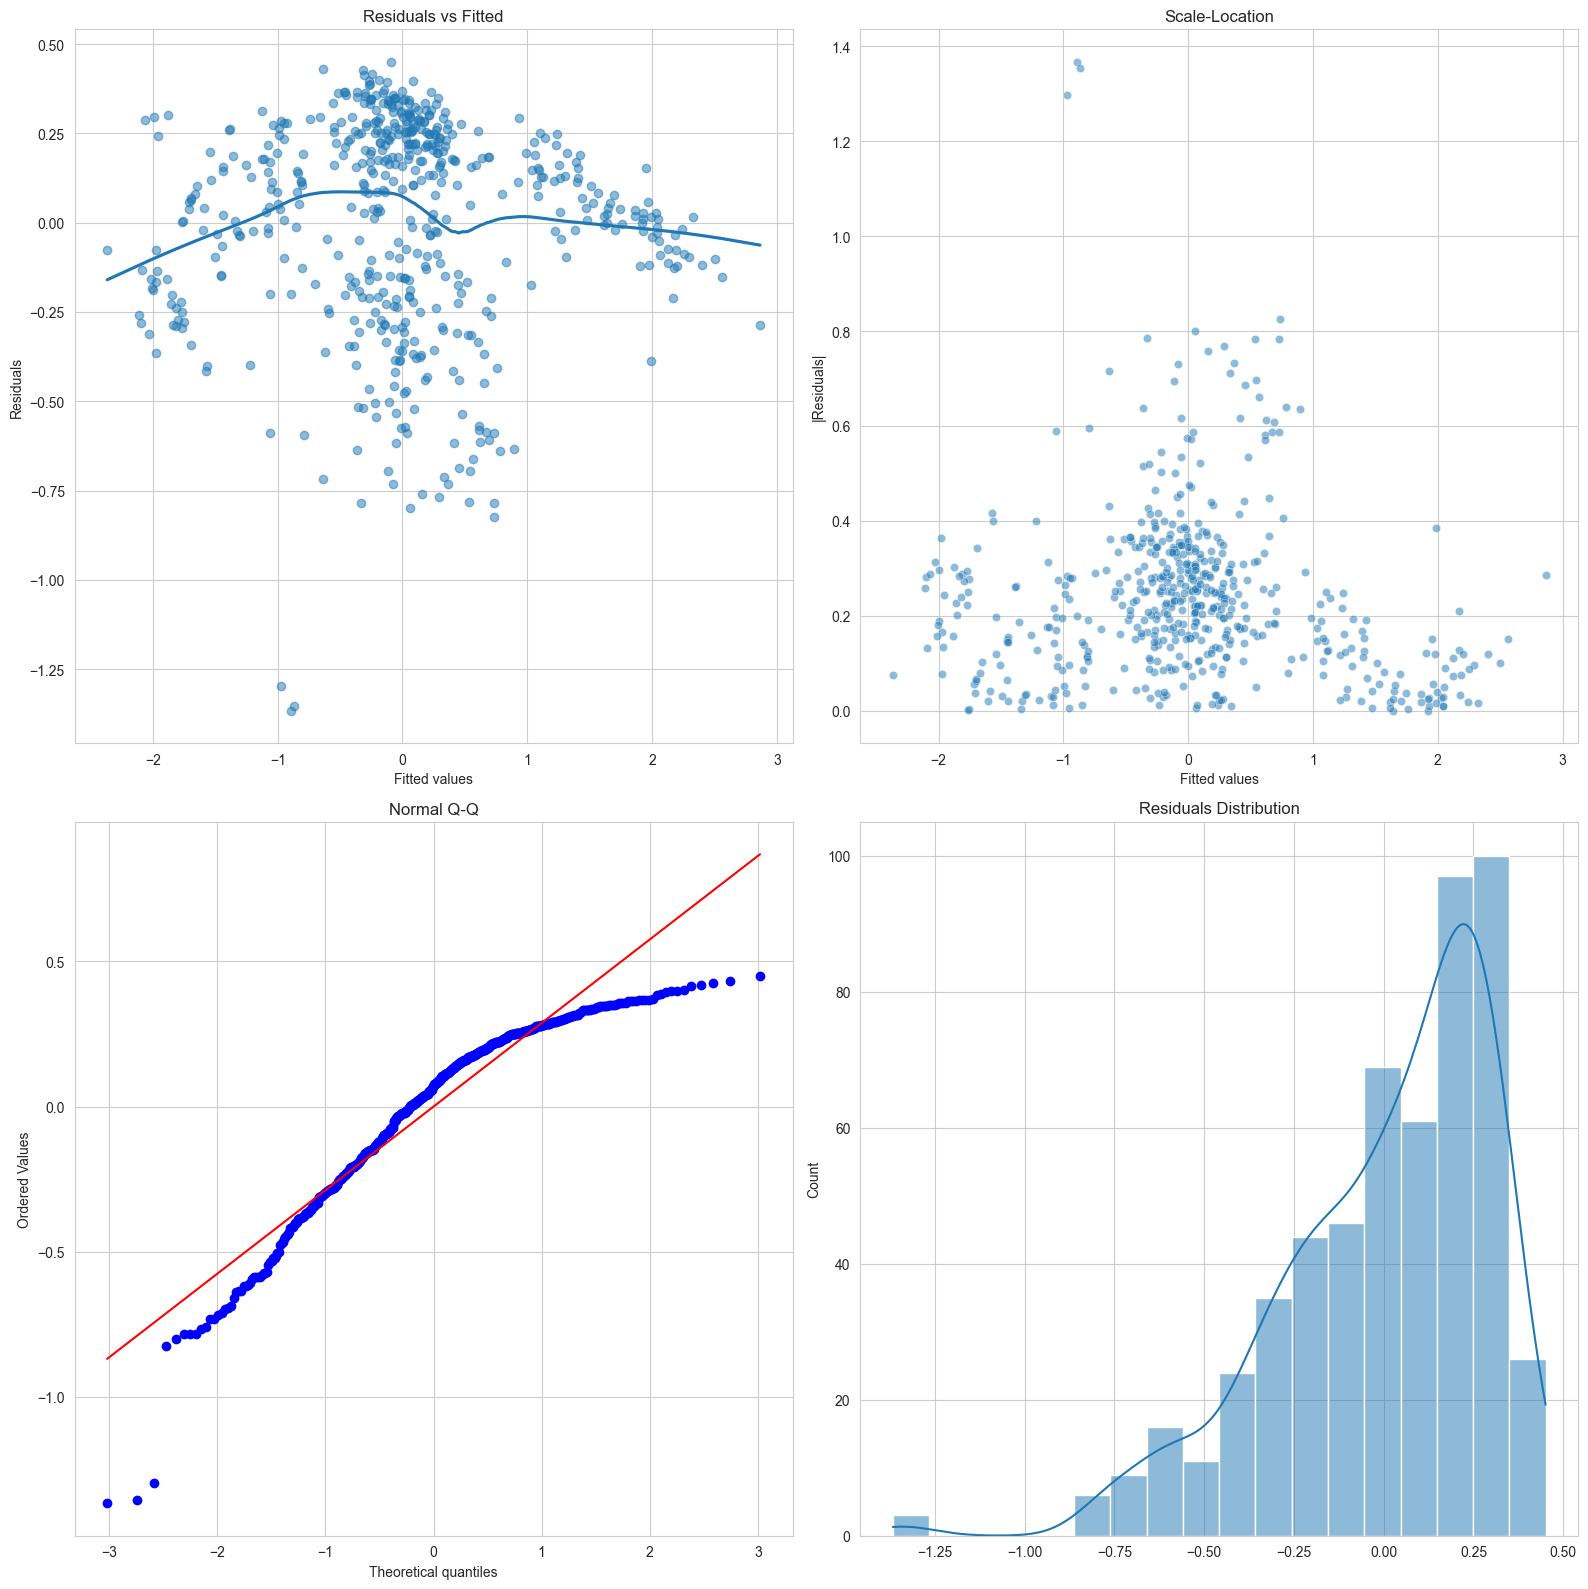

Variance Inflation Factors:
            Feature       VIF
0    remuneration_k  4.285590
1    spending_score  4.632821
2       gender_male  1.929848
3   age_group_25-34  3.070992
4   age_group_35-44  2.977793
5   age_group_45-54  2.226335
6   age_group_55-64  1.445263
7   age_group_65-75  1.569263
8     education_dpl  2.198737
9     education_grd  6.433333
10    education_pgd  3.505630
11    education_phd  3.472141

Assumption Test Results:
Normality: Failed - p-value <= 0.05
  p-value: 6.643095953406566e-17
Homoscedasticity: Passed - p-value > 0.05
  p-value: 0.08535507608033568
Multicollinearity: Passed - All VIF < 10
  Max VIF: 6.43
R-squared: 0.9299139673130394
Mean Squared Error: 130736.94049407629
Shape of X: (782, 12)
Shape of y: (782,)
Shape of x_train: (547, 12)
Shape of y_train: (547,)
Number of features: 12
Number of coefficients: 12
Intercept: -2.7625249852913574
Regression Table for Multiple Linear Regression (Bayesian Linear Regression):
                 Coefficient  Stand

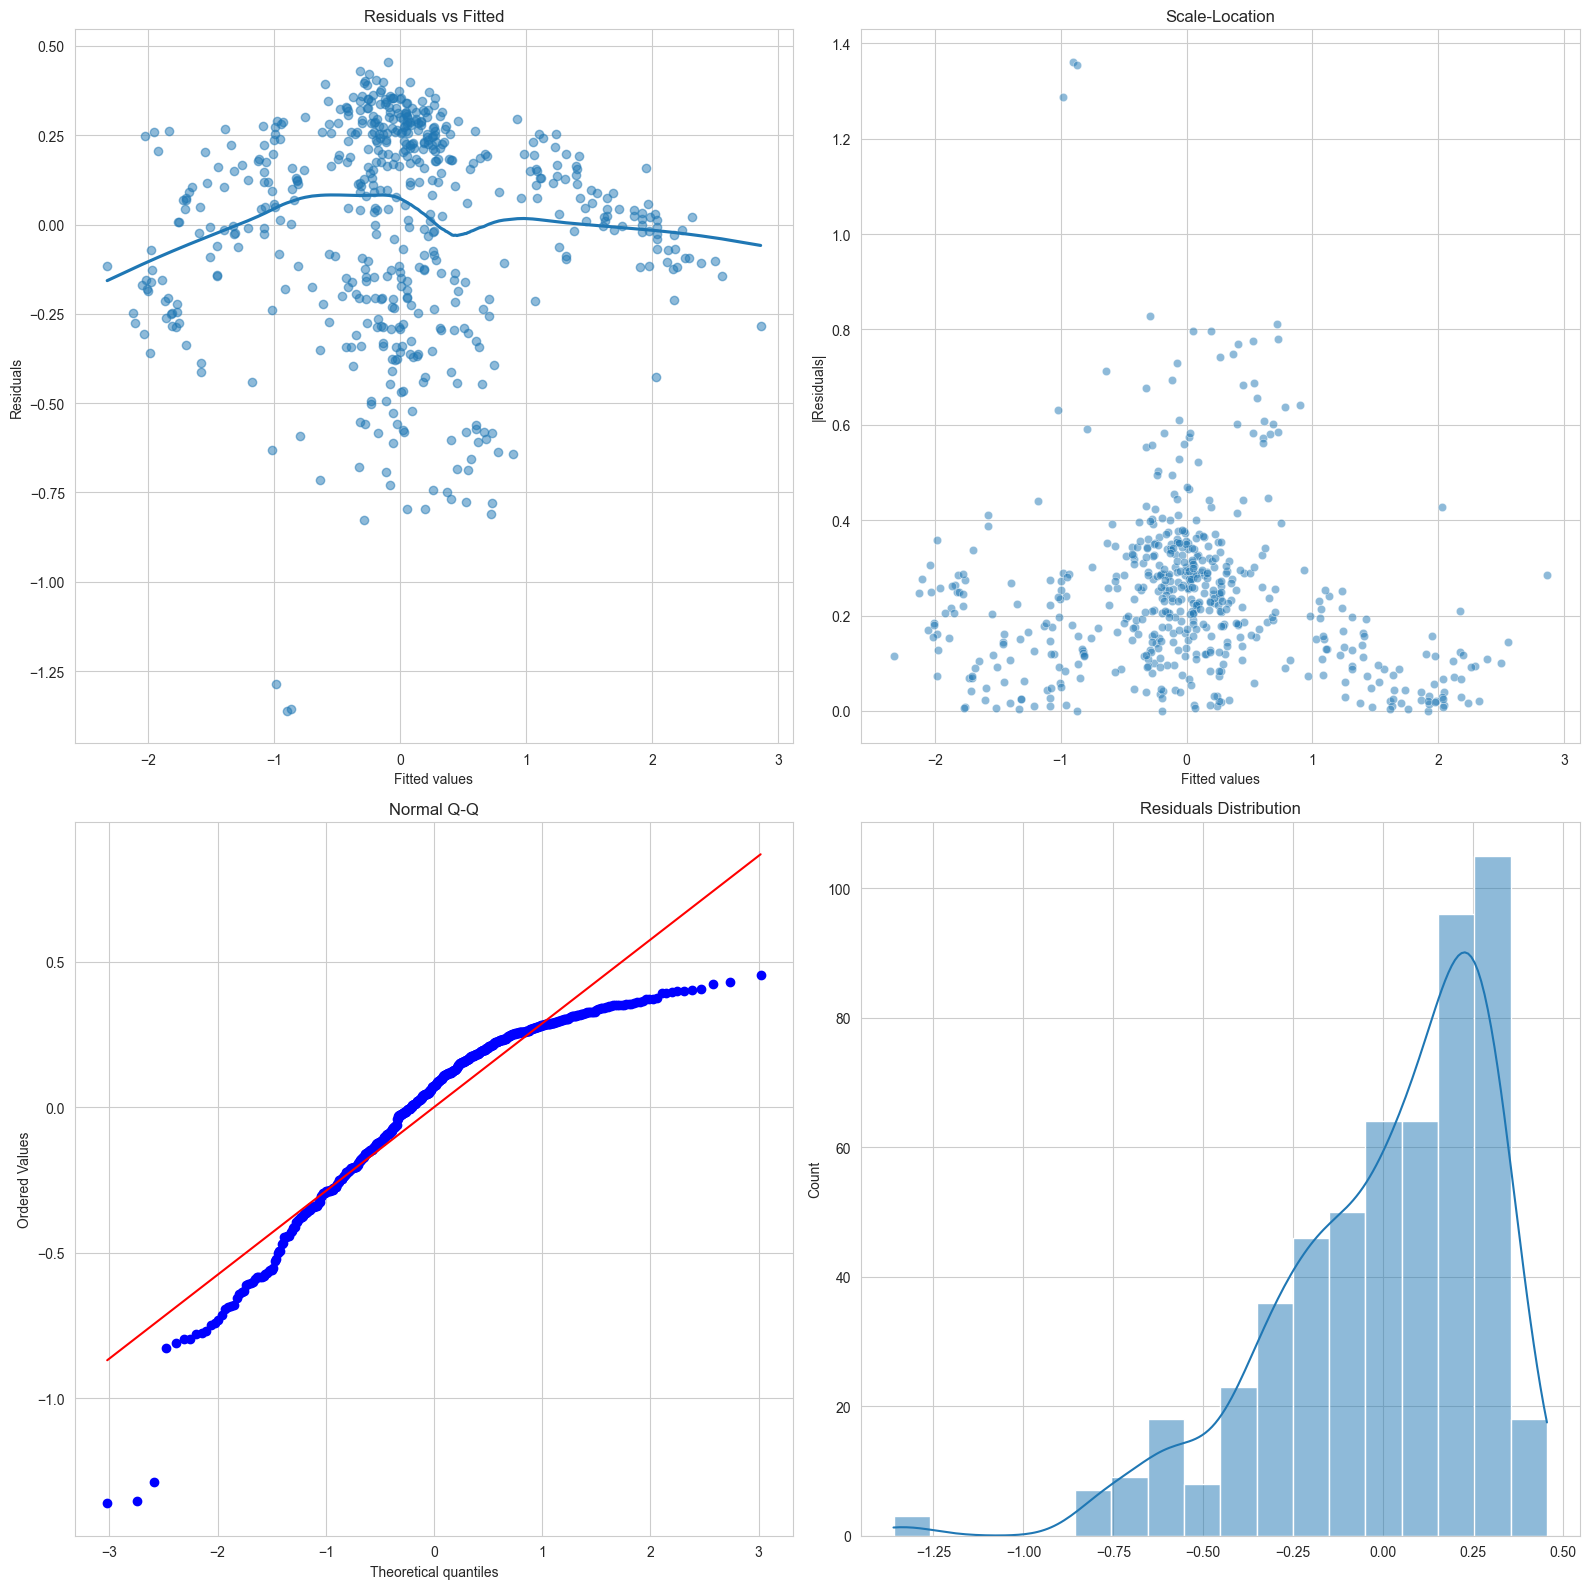

Variance Inflation Factors:
            Feature       VIF
0    remuneration_k  4.285590
1    spending_score  4.632821
2       gender_male  1.929848
3   age_group_25-34  3.070992
4   age_group_35-44  2.977793
5   age_group_45-54  2.226335
6   age_group_55-64  1.445263
7   age_group_65-75  1.569263
8     education_dpl  2.198737
9     education_grd  6.433333
10    education_pgd  3.505630
11    education_phd  3.472141

Assumption Test Results:
Normality: Failed - p-value <= 0.05
  p-value: 4.129462809600481e-17
Homoscedasticity: Passed - p-value > 0.05
  p-value: 0.08981812947873485
Multicollinearity: Passed - All VIF < 10
  Max VIF: 6.43
R-squared: 0.9298341826040417
Mean Squared Error: 130885.76913157613


In [148]:
model, x_train, y_train, r_squared, assumption_results = create_and_evaluate_regression_model(
    features, target, model_type='OLS', target_transformer=pt, model_name='MLR-OLS-Transformed'
)

model, x_train, y_train, r_squared, assumption_results = create_and_evaluate_regression_model(
    features, target, model_type='BLR', target_transformer=pt, model_name='MLR-BLR-Tranformed'
)

## 10.  Decision Trees & Random Forests<a id="10"></a> 

### 10a. No Pruning <a id="10a"></a> 
###### [Return to Top](#top)

Decision Tree
R-squared for DecisionTree: 0.9545154445992926
Mean Squared Error for DecisionTree: 84845.88704545324
Mean Absolute Error: 166.12995003201166


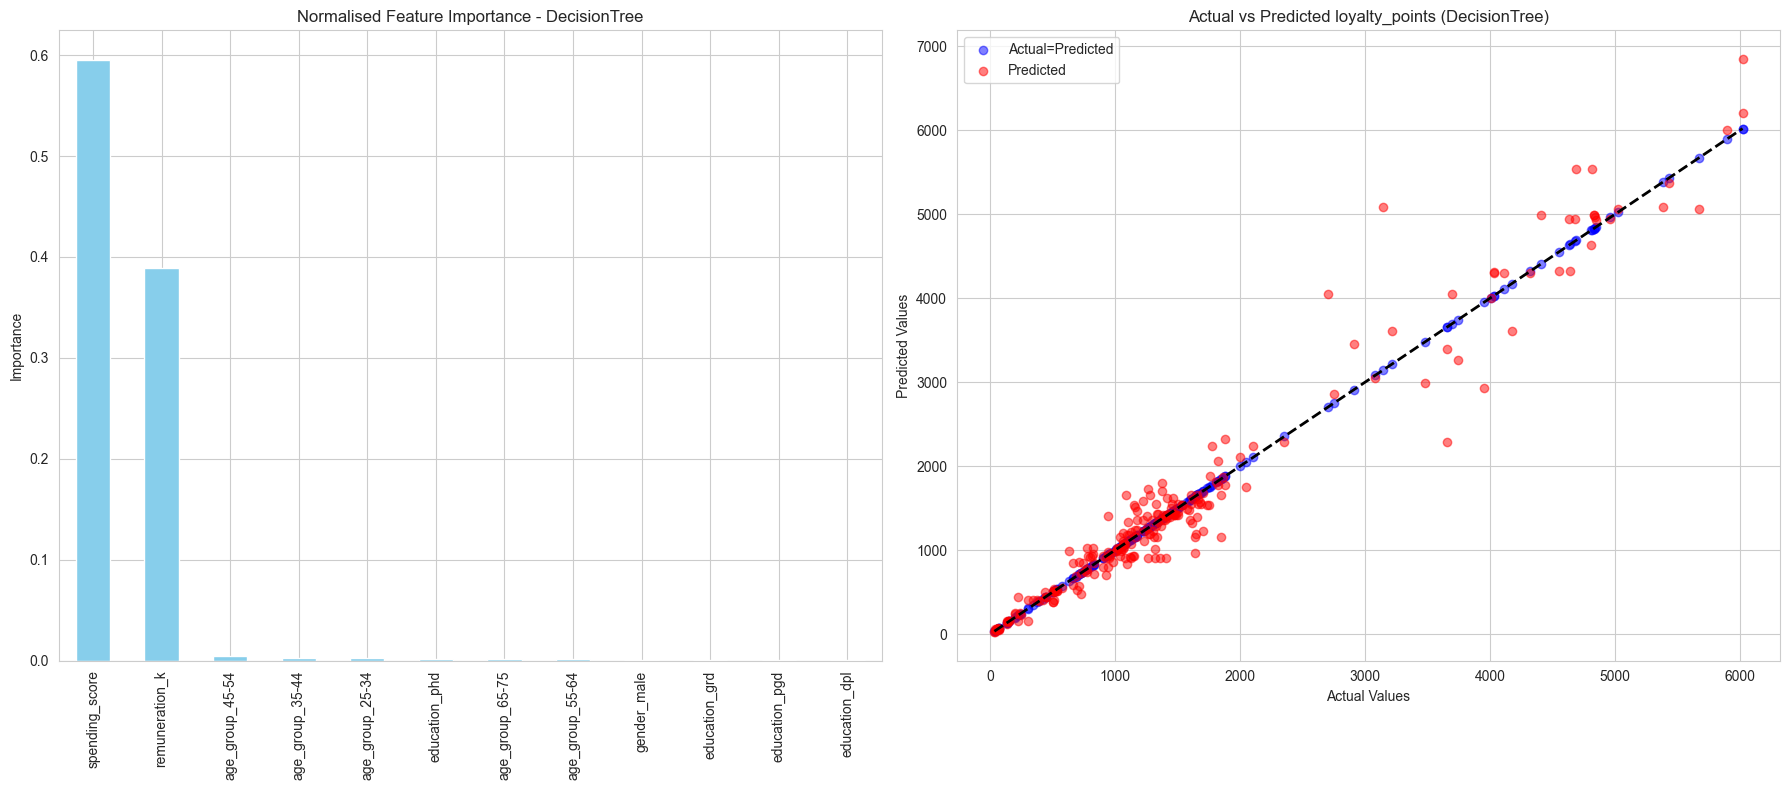

Random Forest
R-squared for RandomForest: 0.9706193779382459
Mean Squared Error for RandomForest: 54805.964767943355
Mean Absolute Error: 126.79301986672854


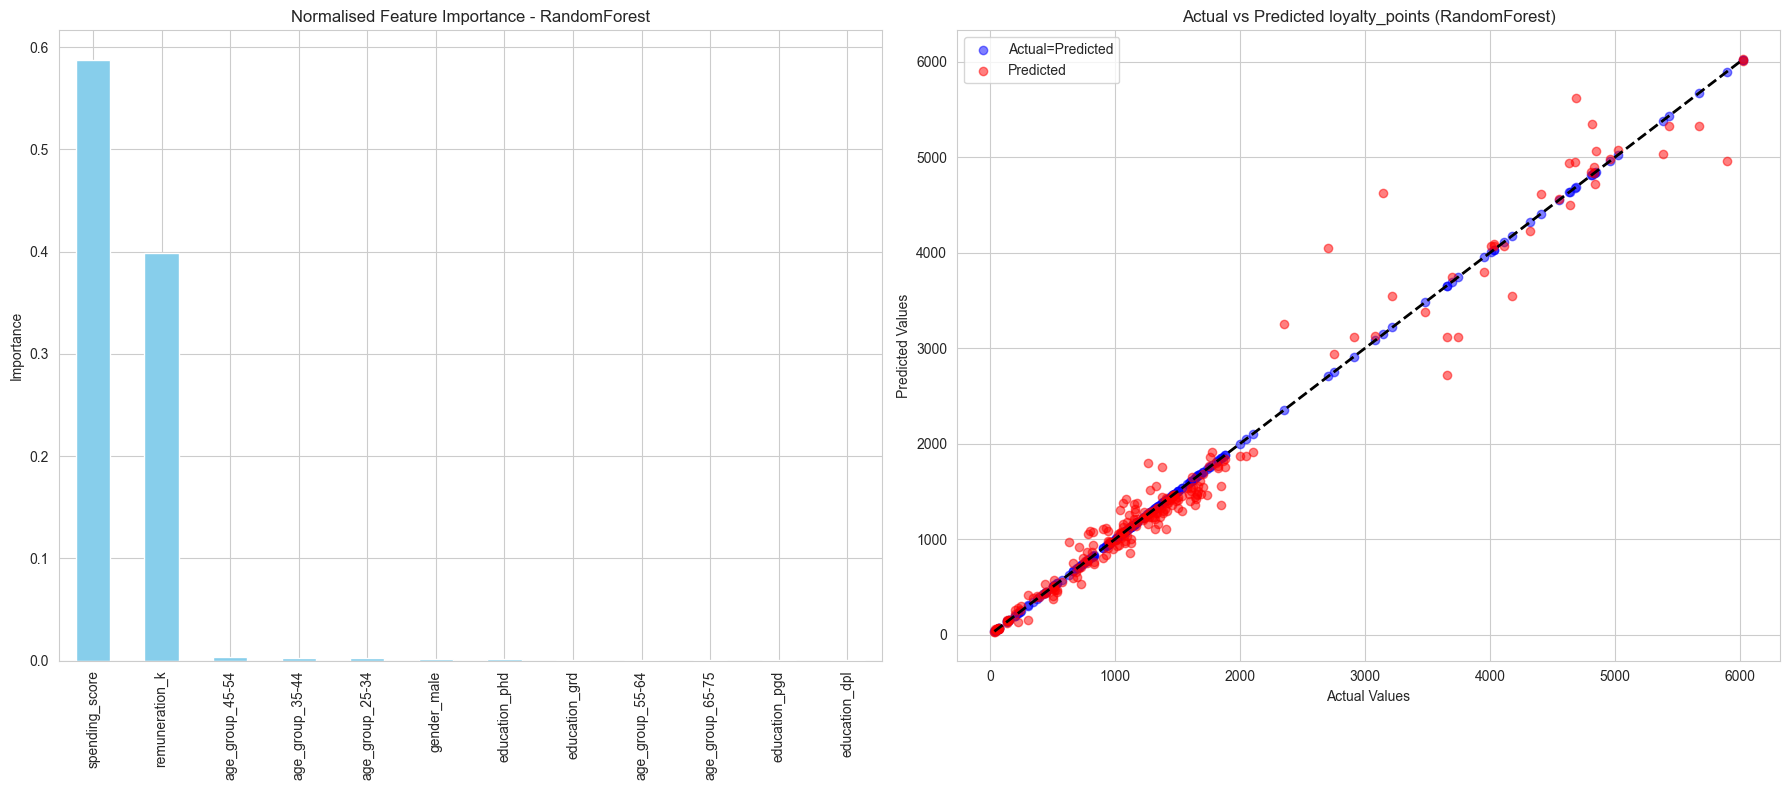

In [149]:
print("Decision Tree")
decision_tree_model = decision_forest_regression_models(features, target, model_type='DecisionTree', max_depth=50, target_transformer=pt, model_name='DecTree')

print("Random Forest")
random_forest_model = decision_forest_regression_models(features, target, model_type='RandomForest', max_depth=50, n_estimators=150, target_transformer=pt, model_name='RandForest')

### Reduced Features, and utilise GridSearchCV for pruning 
### 10b. Decision Tree - updated <a id="10b"></a> 
###### [Return to Top](#top)

In [150]:
# Define the features and target
X = df_cust[['remuneration_k', 'spending_score']]
y = df_cust['loyalty_points']

# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

param_grid_decision_tree = {
    'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Choose model and parameter grid
model_type = 'DecisionTree'
param_grid = param_grid_decision_tree

# Perform grid search with target transformer
grid_search, best_params = perform_grid_search_cv(model_type, X_train, y_train, param_grid, target_transformer=pt)

# Get the best model and evaluate on the test set
best_model = grid_search.best_estimator_
y_train_transformed = pt.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1)).flatten()
y_pred_test_transformed = best_model.predict(X_test)
y_pred_test = pt.inverse_transform(y_pred_test_transformed.reshape(-1, 1)).flatten()
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Store metrics
model_metrics['DecTree-GridSearch-2Var'] = {'R-squared': r2_test, 'MSE': mse_test}

print(f"Test MSE for {model_type}: {mse_test:.2f}")
print(f"Test R-squared for {model_type}: {r2_test:.4f}")

Best parameters found for DecisionTree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Test MSE for DecisionTree: 88666.48
Test R-squared for DecisionTree: 0.9525


### 10c. Random Forest - updated <a id="10c"></a> 

In [151]:
# Define the features and target
features = ['remuneration_k', 'spending_score']
target = 'loyalty_points'

# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(df_cust[features], df_cust[target], test_size=0.3, random_state=SEED)

param_grid_decision_tree = {
    'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Choose model and parameter grid
model_type = 'RandomForest'
param_grid = param_grid_decision_tree

# Perform grid search with target transformer
grid_search, best_params = perform_grid_search_cv(model_type, X_train, y_train, param_grid, target_transformer=pt)

# Get the best model and evaluate on the test set
best_model = grid_search.best_estimator_
y_train_transformed = pt.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1)).flatten()
y_pred_test_transformed = best_model.predict(X_test)
y_pred_test = pt.inverse_transform(y_pred_test_transformed.reshape(-1, 1)).flatten()
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Store metrics
model_metrics['RandForest-GridSearch-2Var'] = {'R-squared': r2_test, 'MSE': mse_test}

print(f"Test MSE for {model_type}: {mse_test:.2f}")
print(f"Test R-squared for {model_type}: {r2_test:.4f}")

Best parameters found for RandomForest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Test MSE for RandomForest: 70477.18
Test R-squared for RandomForest: 0.9622


In [152]:
# Define the features and target
X = df_cust[['remuneration_k', 'spending_score', 'purchase_counts', 'gender_male', 'age_group_25-34', 
            'age_group_35-44', 'age_group_45-54', 'age_group_55-64', 'age_group_65-75', 
            'education_dpl', 'education_grd', 'education_pgd', 'education_phd']]
y = df_cust['loyalty_points']

# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# Define the parameter grid
param_grid_random_forest = {
    'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50, None],
    'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250]
}

# Choose model and parameter grid
model_type = 'RandomForest'
param_grid = param_grid_random_forest

# Perform grid search with target transformer
grid_search, best_params = perform_grid_search_cv(model_type, X_train, y_train, param_grid, target_transformer=pt)

# Get the best model and evaluate on the test set
best_model = grid_search.best_estimator_
y_train_transformed = pt.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1)).flatten()
y_pred_test_transformed = best_model.predict(X_test)
y_pred_test = pt.inverse_transform(y_pred_test_transformed.reshape(-1, 1)).flatten()
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)


# Store metrics
model_metrics['RandForest-GridSearch-6Var'] = {'R-squared': r2_test, 'MSE': mse_test}

print(f"Test MSE for {model_type}: {mse_test:.2f}")
print(f"Test R-squared for {model_type}: {r2_test:.4f}")

Best parameters found for RandomForest: {'max_depth': 20, 'n_estimators': 250}
Test MSE for RandomForest: 52751.62
Test R-squared for RandomForest: 0.9717


## 11. SVR Model <a id="11"></a> 
###### [Return to Top](#top)

Best parameters found for SVR: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Test MSE for SVR: 0.03
Test R-squared for SVR: 0.9679
R-squared: 0.9803830225313952
Mean Squared Error: 36593.07736024512
Mean Absolute Error: 136.53211761237034


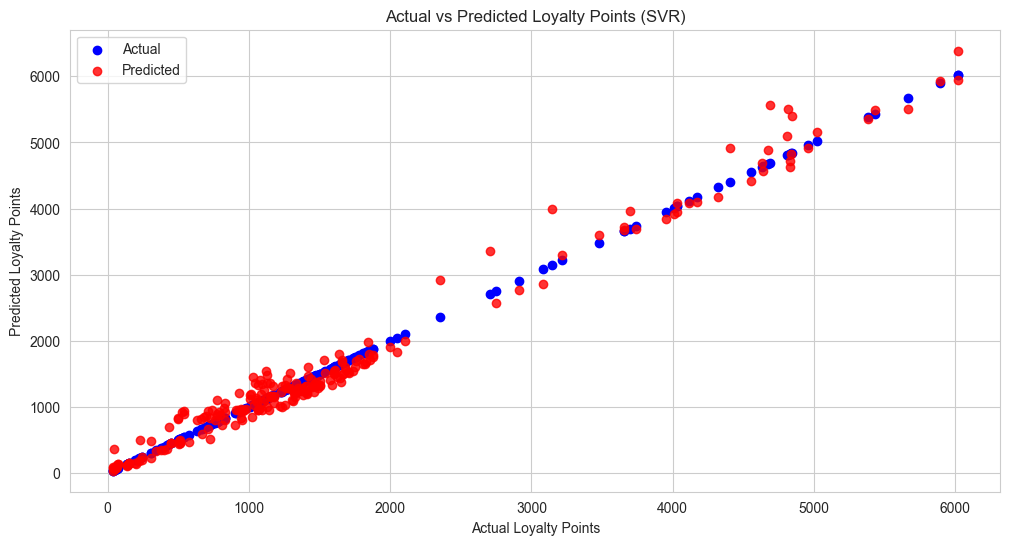

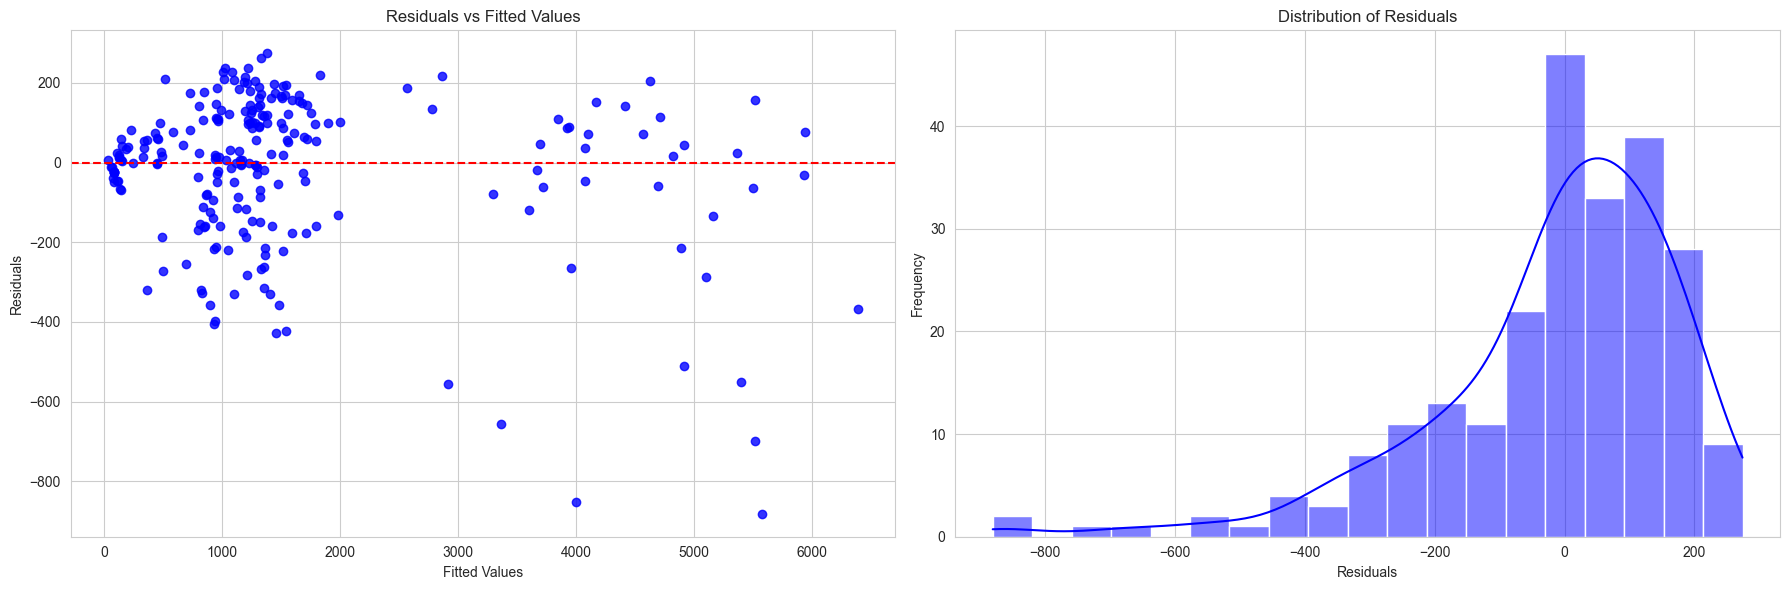

In [153]:
# Define the features and target
X = df_cust[['remuneration_k', 'spending_score', 'gender_male', 'age_group_25-34', 
        'age_group_35-44', 'age_group_45-54', 'age_group_55-64', 'age_group_65-75', 
        'education_dpl', 'education_grd', 'education_pgd', 'education_phd']]
y = df_cust['loyalty_points']

# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# Scale the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Apply Yeo-Johnson transformation to the target
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1)).flatten()

# Initialize the SVR model
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-4, 1e-5],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Perform grid search
model_type = 'SVR'
grid_search, best_params = perform_grid_search_cv(model_type, X_train_scaled, y_train_transformed, param_grid_svr)

# Get the best model and evaluate on the test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test_transformed, y_pred_test)
r2_test = r2_score(y_test_transformed, y_pred_test)

print(f"Test MSE for {model_type}: {mse_test:.2f}")
print(f"Test R-squared for {model_type}: {r2_test:.4f}")

# Inverse transform the scaled predictions to get back to original scale
y_pred_test_original = pt.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_test_original = y_test.values

# Calculate performance metrics on original scale
r_squared = r2_score(y_test_original, y_pred_test_original)
mse = mean_squared_error(y_test_original, y_pred_test_original)
mae = mean_absolute_error(y_test_original, y_pred_test_original)

print(f"R-squared: {r_squared}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Update model metrics
model_metrics['SVR-6Var'] = {'R-squared': r_squared, 'MSE': mse}

# Visualize the results: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.scatter(y_test_original, y_test_original, color='blue', label='Actual')
plt.scatter(y_test_original, y_pred_test_original, color='red', alpha=0.8, label='Predicted')
plt.xlabel('Actual Loyalty Points')
plt.ylabel('Predicted Loyalty Points')
plt.title('Actual vs Predicted Loyalty Points (SVR)')
plt.grid(True)
plt.legend()
plt.show()

# Calculate residuals
residuals = y_test_original - y_pred_test_original

# Create subplots for Residuals vs Fitted Values and Distribution of Residuals
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Residuals vs Fitted Values
axes[0].scatter(y_pred_test_original, residuals, alpha=0.8, color='blue')
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].grid(True)

# Plot Distribution of Residuals
sns.histplot(residuals, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Distribution of Residuals')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Best parameters found for SVR: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Test MSE for SVR: 0.05
Test R-squared for SVR: 0.9490
R-squared: 0.9519147547416577
Mean Squared Error: 89697.15657985263
Mean Absolute Error: 205.17441845578503


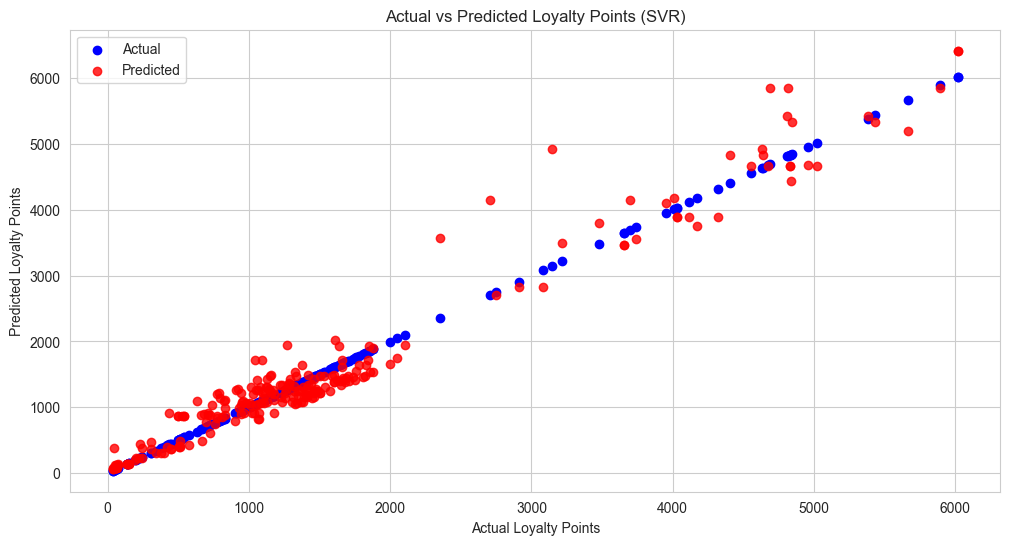

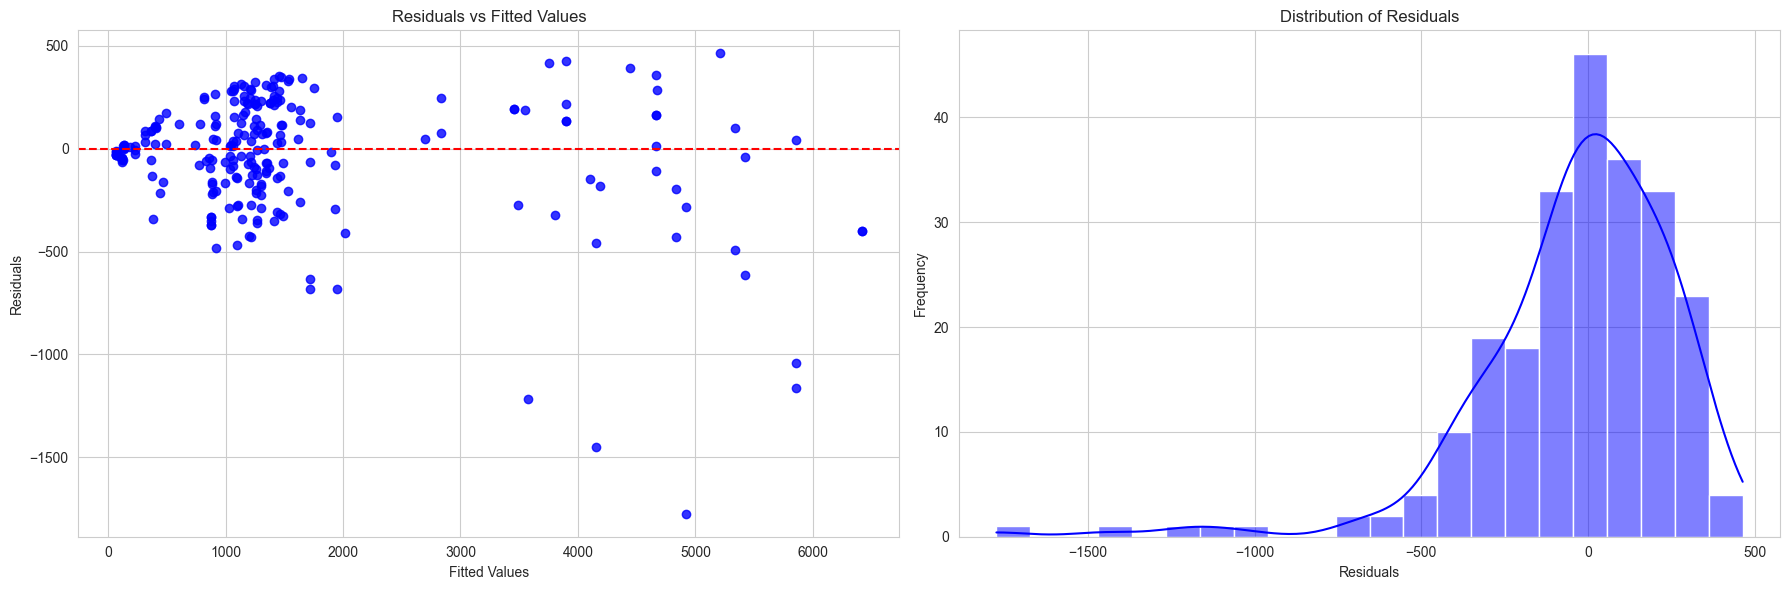

Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
R-squared: 0.9519
Mean Squared Error: 89697.1566
Mean Absolute Error: 205.1744


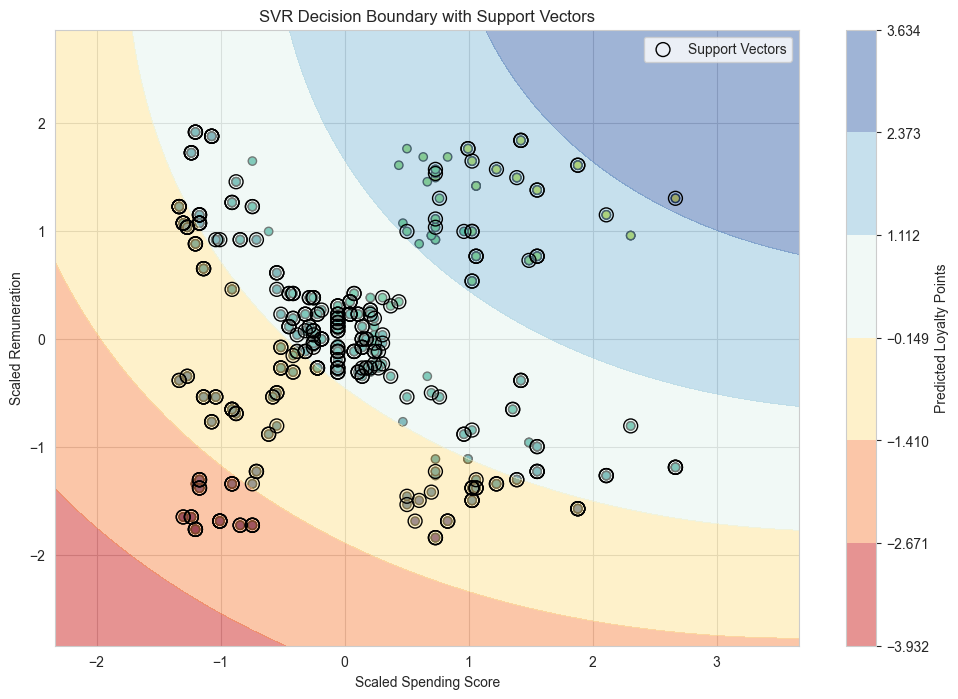

In [154]:
# Define the features and target
X = df_cust[['remuneration_k', 'spending_score']]
y = df_cust['loyalty_points']

# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# Scale the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Apply Yeo-Johnson transformation to the target
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1)).flatten()

# Initialize the SVR model
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-4, 1e-5],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Perform grid search
model_type = 'SVR'
grid_search, best_params = perform_grid_search_cv(model_type, X_train_scaled, y_train_transformed, param_grid_svr)

# Get the best model and evaluate on the test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test_transformed, y_pred_test)
r2_test = r2_score(y_test_transformed, y_pred_test)

print(f"Test MSE for {model_type}: {mse_test:.2f}")
print(f"Test R-squared for {model_type}: {r2_test:.4f}")

# Inverse transform the scaled predictions to get back to original scale
y_pred_test_original = pt.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_test_original = y_test.values

# Calculate performance metrics on original scale
r_squared = r2_score(y_test_original, y_pred_test_original)
mse = mean_squared_error(y_test_original, y_pred_test_original)
mae = mean_absolute_error(y_test_original, y_pred_test_original)

print(f"R-squared: {r_squared}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Update model metrics
model_metrics['SVR-2Var'] = {'R-squared': r_squared, 'MSE': mse}

# Visualize the results: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.scatter(y_test_original, y_test_original, color='blue', label='Actual')
plt.scatter(y_test_original, y_pred_test_original, color='red', alpha=0.8, label='Predicted')
plt.xlabel('Actual Loyalty Points')
plt.ylabel('Predicted Loyalty Points')
plt.title('Actual vs Predicted Loyalty Points (SVR)')
plt.grid(True)
plt.legend()
plt.show()

# Calculate residuals
residuals = y_test_original - y_pred_test_original

# Create subplots for Residuals vs Fitted Values and Distribution of Residuals
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Residuals vs Fitted Values
axes[0].scatter(y_pred_test_original, residuals, alpha=0.8, color='blue')
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].grid(True)

# Plot Distribution of Residuals
sns.histplot(residuals, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Distribution of Residuals')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()
# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"R-squared: {r_squared:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Generate a grid of points to plot the decision boundary
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_transformed, cmap=plt.cm.viridis, edgecolor='black')

# Plot the hyperplane
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), cmap=plt.cm.RdYlBu, alpha=0.5)
plt.colorbar(label='Predicted Loyalty Points')

# Plot the support vectors
plt.scatter(best_model.support_vectors_[:, 0], best_model.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k', label='Support Vectors')

plt.xlabel('Scaled Spending Score')
plt.ylabel('Scaled Remuneration')
plt.title('SVR Decision Boundary with Support Vectors')
plt.legend()
plt.show()

### 12. Gradient Boosting - XGBoost  <a id="12"></a> 
###### [Return to Top](#top)

XGBoost Model Performance:
Mean Squared Error: 38537.94635184787
R-squared: 0.9793404340744019


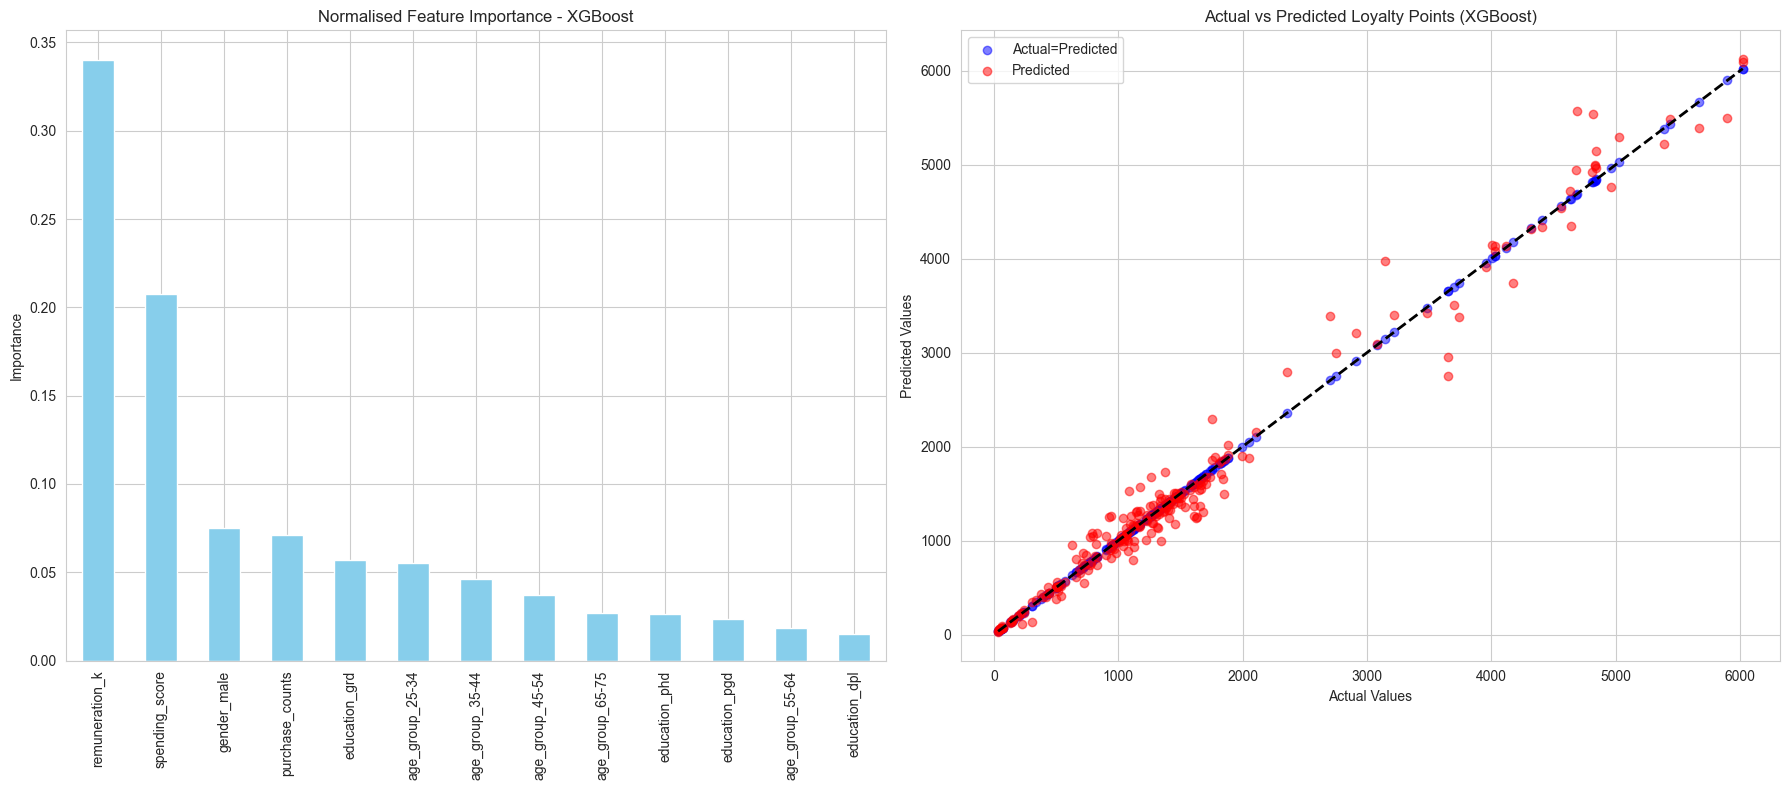

In [155]:
# Define the features and target
X = df_cust[['remuneration_k', 'spending_score', 'purchase_counts', 'gender_male', 'age_group_25-34', 
        'age_group_35-44', 'age_group_45-54', 'age_group_55-64', 'age_group_65-75', 
        'education_dpl', 'education_grd', 'education_pgd', 'education_phd']]
y = df_cust['loyalty_points']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply Yeo-Johnson transformation to the target
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1)).flatten()

# Create DMatrix for XGBoost using transformed y values
dtrain = xgb.DMatrix(X_train, label=y_train_transformed)
dtest = xgb.DMatrix(X_test, label=y_test_transformed)

# Set parameters
params = {
    'max_depth': 15,
    'eta': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Train the model
num_rounds = 150
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on transformed scale
y_pred_transformed = xgb_model.predict(dtest)

# Inverse transform the predictions to get back to original scale
y_pred_original = pt.inverse_transform(y_pred_transformed.reshape(-1, 1)).flatten()

# Calculate performance metrics on the original scale
mse = mean_squared_error(y_test, y_pred_original)
r2 = r2_score(y_test, y_pred_original)

# Store metrics
model_metrics['XGBoost-6Var'] = {'R-squared': r2, 'MSE': mse}

print("XGBoost Model Performance:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plot_feature_importance_and_residuals(xgb_model, X, y_test, y_pred_original, 'XGBoost', 'Loyalty Points', is_xgboost=True)

#### 12a. SHAP Explainer <a id="12a"></a> 

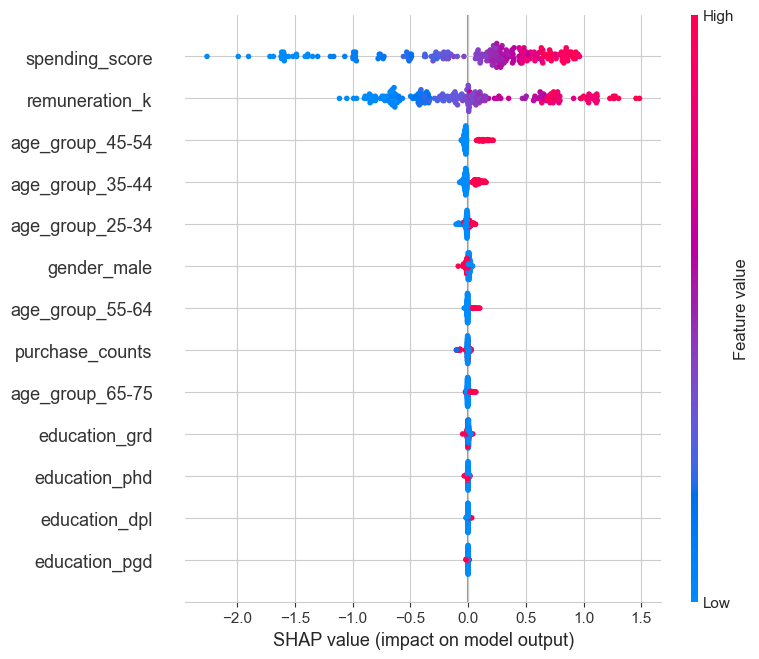

In [156]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test)

In [157]:
# Get feature importances
feature_importance = xgb_model.get_score(importance_type='gain')

# Create a DataFrame with feature names and importances
df_importance = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# Sort by importance
df_importance = df_importance.sort_values('importance', ascending=True)

highlighted_features = ['spending_score', 'remuneration_k']

# Define color schemes
color_scheme = {
    'highlighted': '#1E90FF',  # Dodger Blue
    'normal': '#ADD8E6'  # Light Blue
}

# Create color list
bar_colors = [color_scheme['highlighted'] if feature in highlighted_features else color_scheme['normal'] for feature in df_importance['feature']]

# Create the plot
fig = go.Figure()
fig.add_trace(go.Bar(
    y=df_importance['feature'].tolist(),
    x=df_importance['importance'].tolist(),
    orientation='h',
    marker_color=bar_colors 
))

fig.update_layout(
    title='Feature Importance (XGBoost)',
    xaxis_title='Importance (gain)',
    yaxis=dict(
        title='Feature',
        tickmode='array',
        tickvals=df_importance['feature'].tolist(),
        ticktext=[f'<b>{feature}</b>' 
        if feature in highlighted_features else feature for feature in df_importance['feature']]
    ),
    plot_bgcolor='rgba(224, 228, 212, 0.5)',  # Light sage green background
    paper_bgcolor='rgba(255, 255, 255, 0)',
)

fig.show()

with open('plots/feature_importance_plot.json', 'w') as f:
    json.dump(fig.to_dict(), f, cls=NumpyEncoder)

### 13. Cross - Validation with Partial Dependency Plots & Learning Curves  <a id="13"></a> 
###### [Return to Top](#top)

2-Variable Models:
RandForest-CrossVal-2Var Results:
Training - Mean MSE: 0.03 (+/- 0.01)
Training - Mean R-squared: 0.9666 (+/- 0.0255)
Testing - MSE: 78578.79
Testing - R-squared: 0.9579

XGBoost-CrossVal-2Var Results:
Training - Mean MSE: 0.04 (+/- 0.01)
Training - Mean R-squared: 0.9607 (+/- 0.0324)
Testing - MSE: 89368.60
Testing - R-squared: 0.9521

6-Variable Models:
RandForest-CrossVal-6Var Results:
Training - Mean MSE: 0.02 (+/- 0.01)
Training - Mean R-squared: 0.9755 (+/- 0.0182)
Testing - MSE: 53121.18
Testing - R-squared: 0.9715

XGBoost-CrossVal-6Var Results:
Training - Mean MSE: 0.01 (+/- 0.01)
Training - Mean R-squared: 0.9858 (+/- 0.0129)
Testing - MSE: 33311.50
Testing - R-squared: 0.9821



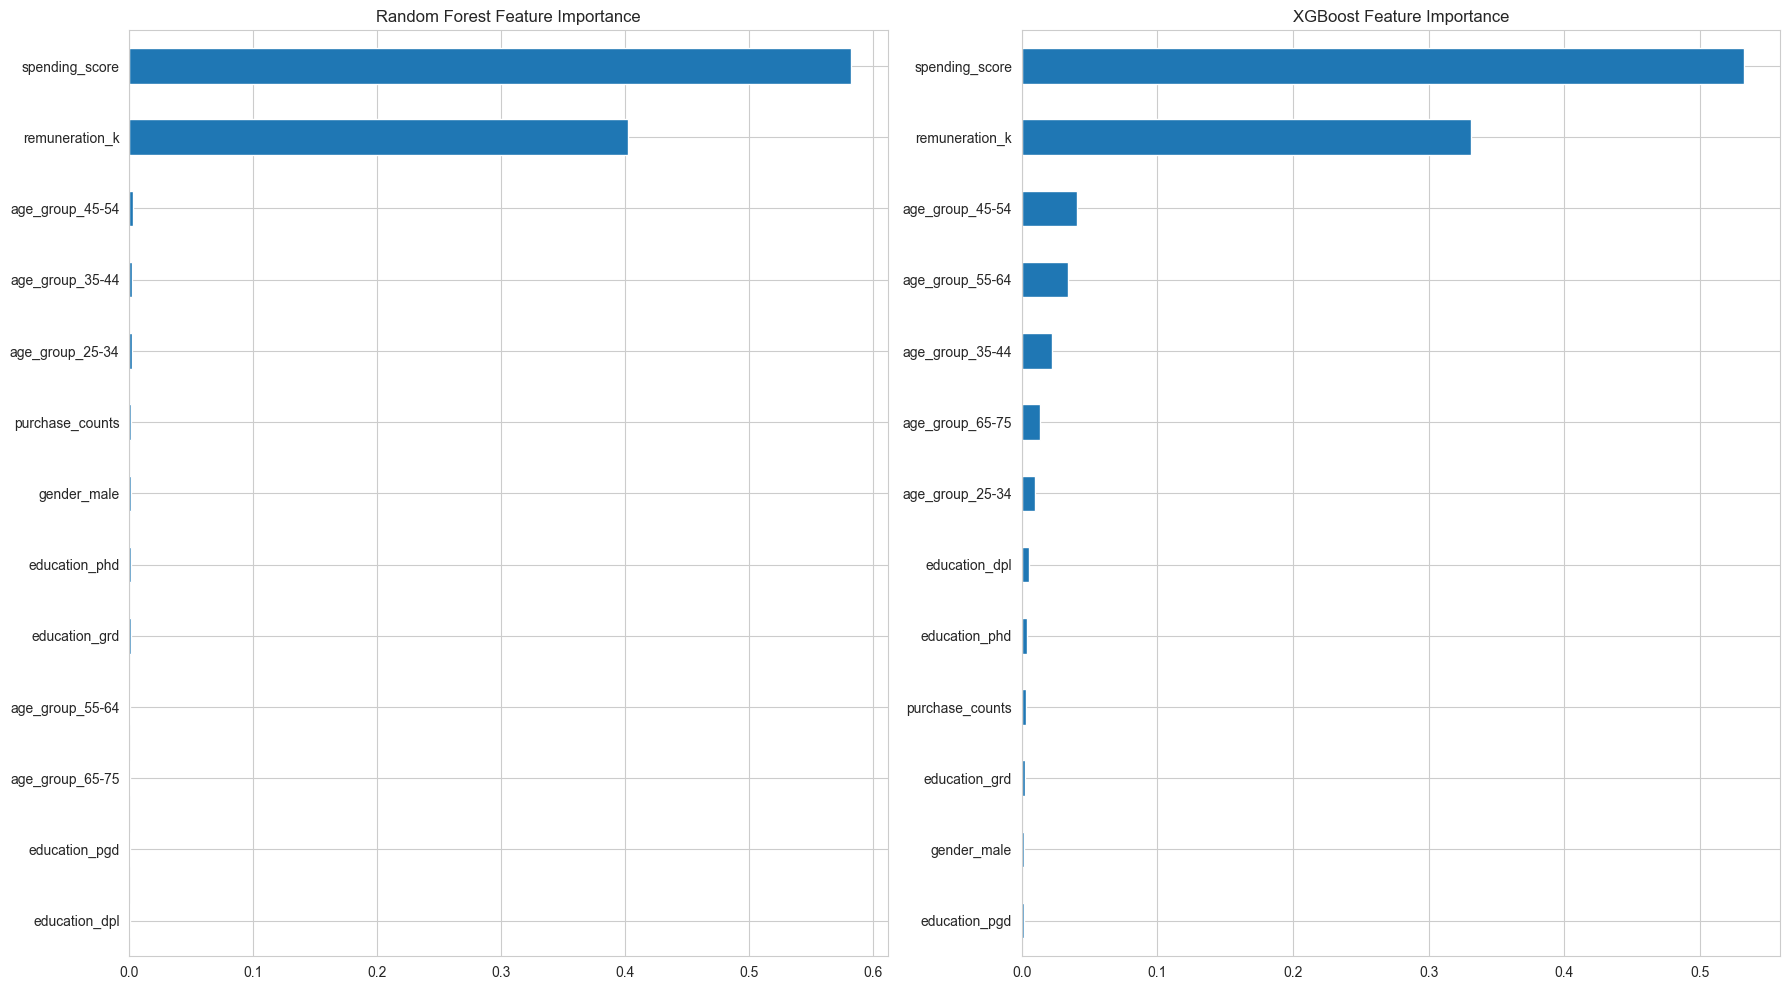

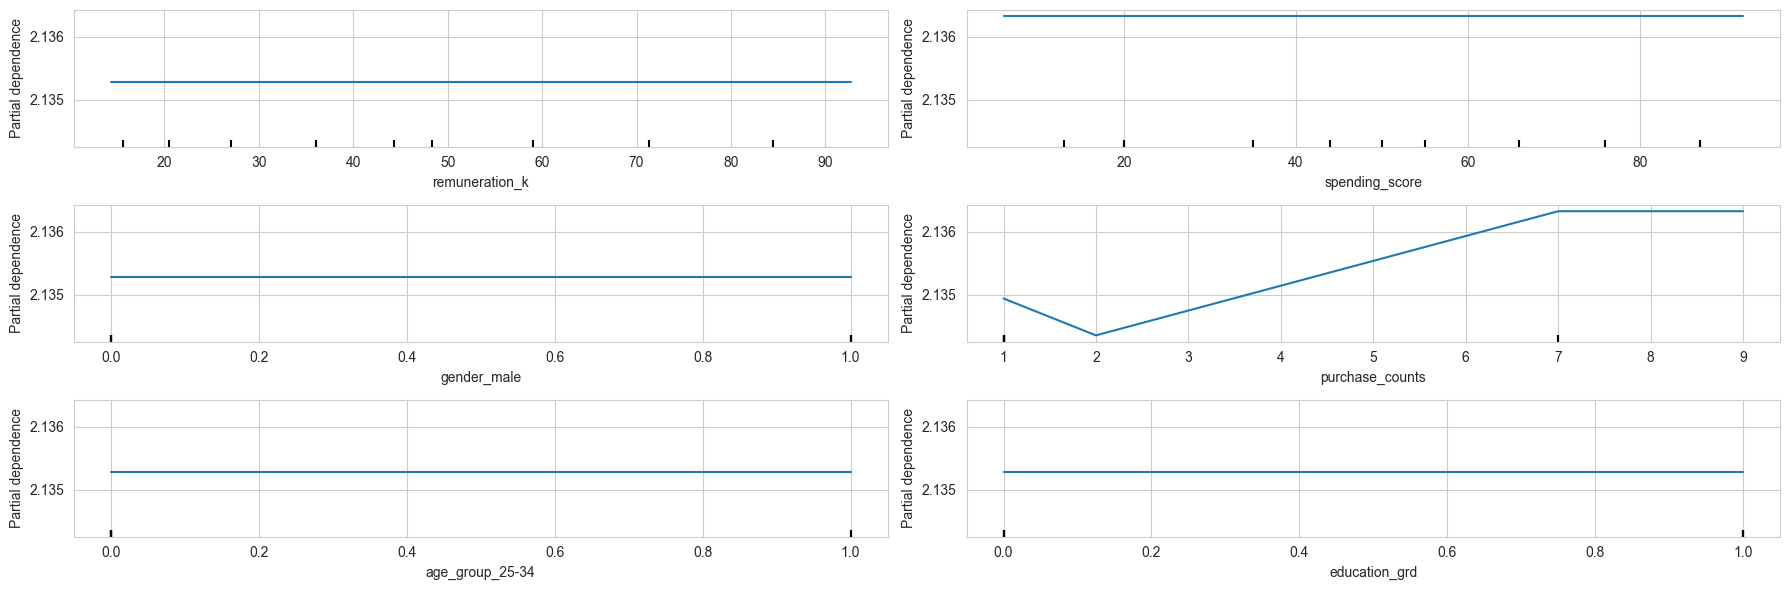

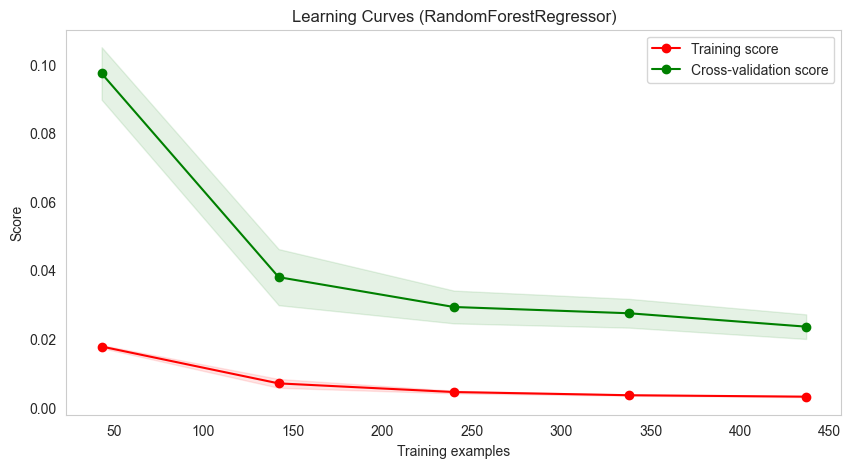

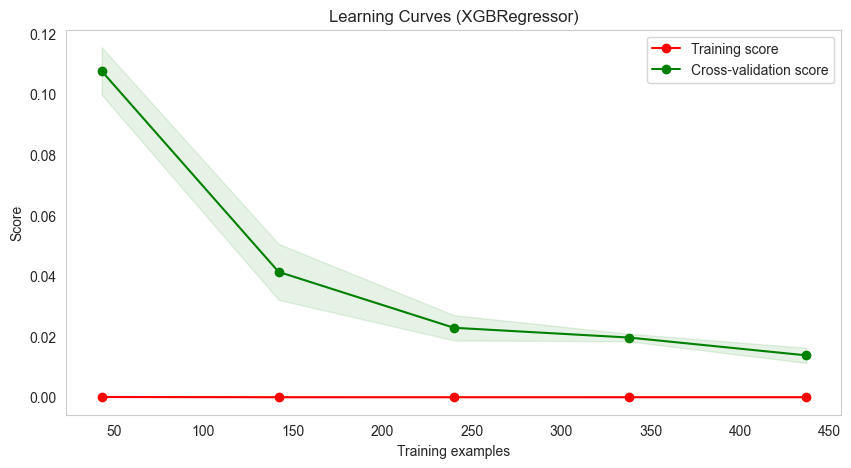

In [158]:
# Define the features and target
X = df_cust[['remuneration_k', 'spending_score', 'gender_male', 'purchase_counts',
             'age_group_25-34', 'age_group_35-44', 'age_group_45-54', 'age_group_55-64', 'age_group_65-75', 
             'education_dpl', 'education_grd', 'education_pgd', 'education_phd']]
y = df_cust['loyalty_points']

# Create and fit the transformer
pt = PowerTransformer(method='yeo-johnson')
y_transformed = pt.fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest models
rf_2var = RandomForestRegressor(n_estimators=150, random_state=42)
rf_6var = RandomForestRegressor(n_estimators=150, random_state=42)

# XGBoost models
xgb_2var = XGBRegressor(n_estimators=150, random_state=42)
xgb_6var = XGBRegressor(n_estimators=150, random_state=42)

# Perform cross-validation
results = []
print("2-Variable Models:")
results.append(perform_cv(rf_2var, X_train_scaled[:, :2], y_train, X_test_scaled[:, :2], y_test, "RandForest-CrossVal-2Var", transformer=pt))
results.append(perform_cv(xgb_2var, X_train_scaled[:, :2], y_train, X_test_scaled[:, :2], y_test, "XGBoost-CrossVal-2Var", transformer=pt))

print("6-Variable Models:")
results.append(perform_cv(rf_6var, X_train_scaled, y_train, X_test_scaled, y_test, "RandForest-CrossVal-6Var", transformer=pt))
results.append(perform_cv(xgb_6var, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost-CrossVal-6Var", transformer=pt))

# Convert results to DataFrame
results_df = pd.DataFrame([r[0] for r in results])

# Feature Importance Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Random Forest Feature Importance
rf_importance = pd.Series(results[2][1].feature_importances_, index=X.columns).sort_values(ascending=True)
rf_importance.plot(kind='barh', ax=ax1)
ax1.set_title('Random Forest Feature Importance')

# XGBoost Feature Importance
xgb_importance = pd.Series(results[3][1].feature_importances_, index=X.columns).sort_values(ascending=True)
xgb_importance.plot(kind='barh', ax=ax2)
ax2.set_title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

# Partial Dependence Plots
features_to_plot = ['remuneration_k', 'spending_score', 'gender_male', 'purchase_counts', 'age_group_25-34', 'education_grd']

n_rows = int(np.ceil(len(features_to_plot) / 2))
fig, ax = plt.subplots(n_rows, 2, figsize=(18, 2 * n_rows))
ax = ax.flatten()

PartialDependenceDisplay.from_estimator(results[3][1], X, features_to_plot, grid_resolution=50, ax=ax)

for i in range(len(features_to_plot), len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

# Plot learning curves
plot_learning_curve(rf_6var, X_train_scaled, y_train)
plt.show()

plot_learning_curve(xgb_6var, X_train_scaled, y_train)
plt.show()

## 14.  All Models Plotted <a id="14"></a> 
###### [Return to Top](#top)

In [159]:
# Convert the dictionary to a DataFrame
df_metrics = pd.DataFrame.from_dict(model_metrics, orient='index').reset_index()
df_metrics.columns = ['Model', 'R-squared', 'MSE']

# Sort the DataFrame by R-squared in ascending order
df_metrics.sort_values(by='R-squared', inplace=True)

# Define colors
light_blue = 'rgba(173, 216, 230, 0.7)'
dark_blue = 'rgba(0, 0, 255, 1)'
light_orange = 'rgba(255, 200, 150, 0.7)'
dark_orange = 'rgba(255, 140, 0, 1)'

# Create color arrays for bars
r_squared_colors = [light_blue] * len(df_metrics)
mse_colors = [light_orange] * len(df_metrics)

# Highlight specific models
highlight_models = ['SVR-6Var', 'XGBoost-CrossVal-6Var']
for i, model in enumerate(df_metrics['Model']):
    if model in highlight_models:
        r_squared_colors[i] = dark_blue
        mse_colors[i] = dark_orange

# Create the plot
fig = go.Figure()

# Add R-squared bars
fig.add_trace(go.Bar(
    x=df_metrics['Model'],
    y=df_metrics['R-squared'],
    name='R-squared',
    marker_color=r_squared_colors,
    yaxis='y',
    offsetgroup=0
))

# Add MSE bars
fig.add_trace(go.Bar(
    x=df_metrics['Model'],
    y=df_metrics['MSE'],
    name='MSE',
    marker_color=mse_colors,
    yaxis='y2',
    offsetgroup=1
))

# Define tick values and labels for both axes
y1_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
y2_ticks = [0, 240000, 480000, 720000, 960000, 1200000]

# Create the layout with aligned dual y-axes and grouped bars
fig.update_layout(
    title={
        'text': 'Model Performance Comparison: R-squared and MSE',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    xaxis=dict(
        title='Model',
        tickangle=-45,
        tickmode='array',
        tickvals=df_metrics['Model'],
        ticktext=[f'<b>{model}</b>' if model in highlight_models else model for model in df_metrics['Model']]
    ),
    yaxis=dict(
        title='R-squared',
        titlefont=dict(color=dark_blue),
        tickfont=dict(color=dark_blue),
        side='left',
        range=[0, 1.0],
        tickmode='array',
        tickvals=y1_ticks,
        ticktext=[f'{x:.0%}' for x in y1_ticks]
    ),
    yaxis2=dict(
        title='MSE',
        titlefont=dict(color=dark_orange),
        tickfont=dict(color=dark_orange),
        overlaying='y',
        side='right',
        range=[0, 1200000],
        tickmode='array',
        tickvals=y2_ticks,
        ticktext=[f'{x:,.0f}' for x in y2_ticks]
    ),
    legend=dict(x=0.5, y=1.15, orientation='h', xanchor='center'),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1,
    height=600,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

# Add gridlines
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Adjust the margins to ensure all labels are visible
fig.update_layout(margin=dict(l=50, r=50, t=100, b=100))

# Show the plot
fig.show()
# Save plot as json
with open('plots/model-comparison-chart.json', 'w') as f:
    json.dump(fig.to_dict(), f, cls=NumpyEncoder)

print("model-comparison-chart plot has been saved as JSON file.")

model-comparison-chart plot has been saved as JSON file.


In [160]:

# Assuming df_cust is your DataFrame
X2 = df_cust[['remuneration_k', 'spending_score']]

def train_kmeans(X):
    ks = range(2, 9)
    kmeans_k = []
    inertias = []
    silhouettes = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        kmeans_k.append(kmeans)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))
    return kmeans_k, inertias, silhouettes, list(ks)

kmeans_k, inertias, silhouettes, ks = train_kmeans(X2)

def plot_kmeans_clusters(X2, kmeans_k, range_n_clusters):
    subplot_titles = []
    for n in range_n_clusters:
        subplot_titles.extend([f'Silhouette plot for k = {n}', f'Cluster plot for k = {n}'])

    fig = make_subplots(rows=len(range_n_clusters), cols=2,
                        subplot_titles=subplot_titles,
                        vertical_spacing=0.1,
                        horizontal_spacing=0.05)

    for row, n_clusters in enumerate(range_n_clusters):
        kmeans = kmeans_k[n_clusters - 2]
        cluster_labels = kmeans.predict(X2)

        silhouette_avg = silhouette_score(X2, cluster_labels)
        sample_silhouette_values = silhouette_samples(X2, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = f'rgba{tuple(int(x*255) for x in cm.nipy_spectral(float(i) / n_clusters)[:3]) + (0.7,)}'
            
            fig.add_trace(go.Scatter(
                y=np.arange(y_lower, y_upper),
                x=ith_cluster_silhouette_values,
                fill='tozerox',
                fillcolor=color,
                line=dict(color='rgba(255,255,255,0)'),
                showlegend=False,
                mode='lines',
                name=f'Cluster {i}'
            ), row=row+1, col=1)

            fig.add_annotation(
                x=-0.05, y=y_lower + 0.5 * size_cluster_i,
                text=str(i),
                showarrow=False,
                xref=f'x{row*2+1}',
                yref=f'y{row*2+1}'
            )

            y_lower = y_upper + 10

        fig.add_vline(x=silhouette_avg, line_dash="dash", line_color="red", row=row+1, col=1)

        colors = [f'rgba{tuple(int(x*255) for x in cm.nipy_spectral(float(label) / n_clusters)[:3]) + (0.7,)}' for label in cluster_labels]
        fig.add_trace(go.Scatter(
            x=X2.iloc[:, 0],
            y=X2.iloc[:, 1],
            mode='markers',
            marker=dict(
                size=5,
                color=colors,
                line=dict(color='rgba(0,0,0,0.3)', width=0.5)
            ),
            showlegend=False
        ), row=row+1, col=2)

        centers = kmeans.cluster_centers_
        fig.add_trace(go.Scatter(
            x=centers[:, 0],
            y=centers[:, 1],
            mode='markers',
            marker=dict(
                color='white',
                size=20,
                line=dict(color='rgba(0,0,0,1)', width=1)
            ),
            showlegend=False
        ), row=row+1, col=2)

        for i, c in enumerate(centers):
            fig.add_annotation(
                x=c[0], y=c[1],
                text=str(i),
                showarrow=False,
                xref=f'x{row*2+2}',
                yref=f'y{row*2+2}'
            )

    fig.update_layout(
        title_text="K-means Clustering Analysis",
        showlegend=False,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        autosize=True,
        margin=dict(l=50, r=50, t=100, b=50),
        height=250 * len(range_n_clusters),  # Adjust base height
    )

    for i in range(len(range_n_clusters)):
        fig.update_xaxes(title_text="Silhouette coefficient values", row=i+1, col=1)
        fig.update_yaxes(title_text="Cluster label", row=i+1, col=1)
        fig.update_xaxes(title_text="Feature 1", row=i+1, col=2)
        fig.update_yaxes(title_text="Feature 2", row=i+1, col=2)

    return fig

# Define range of clusters
range_n_clusters = [3, 4, 5, 6, 7]

# Generate plot for all clusters
fig_all = plot_kmeans_clusters(X2, kmeans_k, range_n_clusters)

# Save the plot as JSON
with open('plots/clustering_analysis_all.json', 'w') as f:
    json.dump(fig_all.to_dict(), f, cls=NumpyEncoder)

print("Main plot has been saved as JSON file.")

# Separate plots for k=5
fig_k5 = make_subplots(rows=1, cols=2, subplot_titles=['Silhouette plot for k = 5', 'Cluster plot for k = 5'])

# Add silhouette plot for k=5
kmeans_5 = kmeans_k[3]  # k=5 is at index 3 (0-based indexing)
cluster_labels_5 = kmeans_5.predict(X2)
silhouette_avg_5 = silhouette_score(X2, cluster_labels_5)
sample_silhouette_values_5 = silhouette_samples(X2, cluster_labels_5)

y_lower = 10
for i in range(5):
    ith_cluster_silhouette_values = sample_silhouette_values_5[cluster_labels_5 == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = f'rgba{tuple(int(x*255) for x in cm.nipy_spectral(float(i) / 5)[:3]) + (0.7,)}'
    
    fig_k5.add_trace(go.Scatter(
        y=np.arange(y_lower, y_upper),
        x=ith_cluster_silhouette_values,
        fill='tozerox',
        fillcolor=color,
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        mode='lines',
        name=f'Cluster {i}'
    ), row=1, col=1)

    fig_k5.add_annotation(
        x=-0.05, y=y_lower + 0.5 * size_cluster_i,
        text=str(i),
        showarrow=False,
        xref='x1',
        yref='y1'
    )

    y_lower = y_upper + 10

fig_k5.add_vline(x=silhouette_avg_5, line_dash="dash", line_color="red", row=1, col=1)

# Add cluster plot for k=5
colors_5 = [f'rgba{tuple(int(x*255) for x in cm.nipy_spectral(float(label) / 5)[:3]) + (0.7,)}' for label in cluster_labels_5]
fig_k5.add_trace(go.Scatter(
    x=X2.iloc[:, 0],
    y=X2.iloc[:, 1],
    mode='markers',
    marker=dict(
        size=5,
        color=colors_5,
        line=dict(color='rgba(0,0,0,0.3)', width=0.5)
    ),
    showlegend=False
), row=1, col=2)

centers_5 = kmeans_5.cluster_centers_
fig_k5.add_trace(go.Scatter(
    x=centers_5[:, 0],
    y=centers_5[:, 1],
    mode='markers',
    marker=dict(
        color='white',
        size=20,
        line=dict(color='rgba(0,0,0,1)', width=1)
    ),
    showlegend=False
), row=1, col=2)

for i, c in enumerate(centers_5):
    fig_k5.add_annotation(
        x=c[0], y=c[1],
        text=str(i),
        showarrow=False,
        xref='x2',
        yref='y2'
    )

fig_k5.update_layout(
    title_text="K-means Clustering Analysis (k=5)",
    showlegend=False,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    autosize=True,
    margin=dict(l=50, r=50, t=100, b=50),
    height=250,  # Adjust base height
)

fig_k5.update_xaxes(title_text="Silhouette coefficient values", row=1, col=1)
fig_k5.update_yaxes(title_text="Cluster label", row=1, col=1)
fig_k5.update_xaxes(title_text="Feature 1", row=1, col=2)
fig_k5.update_yaxes(title_text="Feature 2", row=1, col=2)

fig_all.show()
# Save the k=5 plot as JSON
with open('plots/clustering_analysis_k5.json', 'w') as f:
    json.dump(fig_k5.to_dict(), f, cls=NumpyEncoder)

print("K=5 plot has been saved as JSON file.")
fig_k5.show()


Main plot has been saved as JSON file.


K=5 plot has been saved as JSON file.


# 15. Clustering with *k*-means  <a id="15"></a> 
###### [Return to Top](#top)


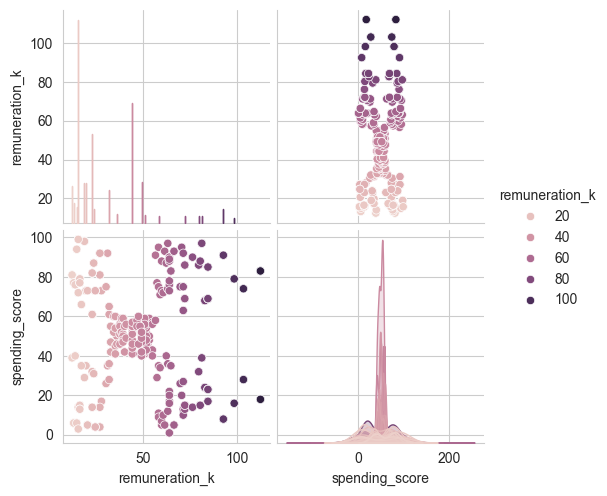

In [161]:
# Extract the relevant features
X2 = df_cust[['remuneration_k', 'spending_score']]
X2

sns.pairplot(df_cust,
             vars=X2,
             hue='remuneration_k',
             diag_kind='kde')


### 15a. Elbow Method  <a id="15a"></a> 

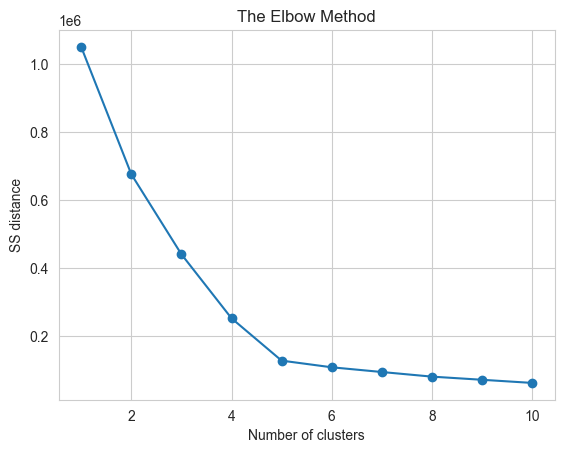

In [162]:
ss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X2)
    ss.append(kmeans.inertia_)

# Plot the elbow method.
plt.plot(range(1, 11),
         ss,
         marker='o')

# Insert labels and title.
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("SS distance")

plt.show()

### 15b. Silouette Method <a id="15b"></a> 

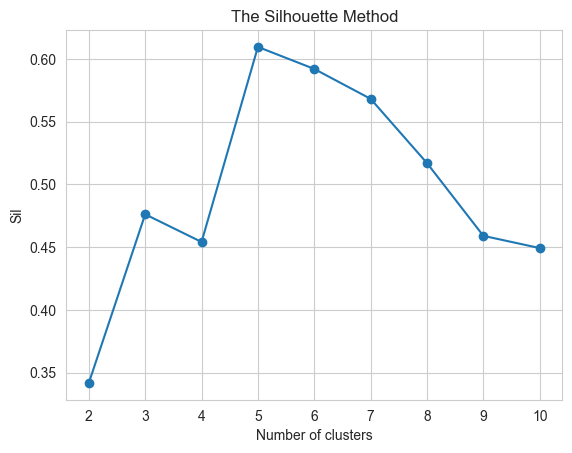

In [163]:
# Find the range of clusters to be used using silhouette method.
sil = []
kmax = 10

for k in range(2, kmax+1):
    kmeans_s = KMeans(n_clusters = k).fit(X2)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(X2,
                                labels,
                                metric = 'euclidean'))

# Plot the silhouette method.
plt.plot(range(2, kmax+1),
         sil,
         marker='o')

plt.title("The Silhouette Method")
plt.xlabel("Number of clusters")
plt.ylabel("Sil")

plt.show()

### 15c. Silouette Plots <a id="15c"></a> 

In [164]:
def plot_kmeans_clusters(X2, kmeans_k, range_n_clusters):
    # Create a single figure with a grid of subplots
    subplot_titles = []
    for n in range_n_clusters:
        subplot_titles.append(f'Silhouette plot for n_clusters = {n}')
    for n in range_n_clusters:
        subplot_titles.append(f'Clustered data for n_clusters = {n}')

    fig = make_subplots(rows=len(range_n_clusters), cols=2,
                        subplot_titles=subplot_titles,
                        vertical_spacing=0.05,
                        horizontal_spacing=0.05)

    for row, n_clusters in enumerate(range_n_clusters):
        # Get the KMeans model and predict cluster labels
        kmeans = kmeans_k[n_clusters - 2]
        cluster_labels = kmeans.predict(X2)

        # Compute the silhouette scores
        silhouette_avg = silhouette_score(X2, cluster_labels)
        sample_silhouette_values = silhouette_samples(X2, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = f'rgba{tuple(int(x*255) for x in cm.nipy_spectral(float(i) / n_clusters)[:3]) + (0.7,)}'
            
            fig.add_trace(go.Scatter(
                y=np.arange(y_lower, y_upper),
                x=ith_cluster_silhouette_values,
                fill='tozerox',
                fillcolor=color,
                line=dict(color='rgba(255,255,255,0)'),
                showlegend=False,
                mode='lines',
                name=f'Cluster {i}'
            ), row=row+1, col=1)

            # Add text label for cluster number
            fig.add_annotation(
                x=-0.05, y=y_lower + 0.5 * size_cluster_i,
                text=str(i),
                showarrow=False,
                xref=f'x{row*2+1}',
                yref=f'y{row*2+1}'
            )

            y_lower = y_upper + 10

        # Add vertical line for average silhouette score
        fig.add_vline(x=silhouette_avg, line_dash="dash", line_color="red", row=row+1, col=1)

        # Clustered data plot
        colors = [f'rgba{tuple(int(x*255) for x in cm.nipy_spectral(float(label) / n_clusters)[:3]) + (0.7,)}' for label in cluster_labels]
        fig.add_trace(go.Scatter(
            x=X2.iloc[:, 0],
            y=X2.iloc[:, 1],
            mode='markers',
            marker=dict(
                size=5,
                color=colors,
                line=dict(color='rgba(0,0,0,0.3)', width=0.5)
            ),
            showlegend=False
        ), row=row+1, col=2)

        # Plot cluster centers
        centers = kmeans.cluster_centers_
        fig.add_trace(go.Scatter(
            x=centers[:, 0],
            y=centers[:, 1],
            mode='markers',
            marker=dict(
                color='white',
                size=20,
                line=dict(color='rgba(0,0,0,1)', width=1)
            ),
            showlegend=False
        ), row=row+1, col=2)

        for i, c in enumerate(centers):
            fig.add_annotation(
                x=c[0], y=c[1],
                text=str(i),
                showarrow=False,
                xref=f'x{row*2+2}',
                yref=f'y{row*2+2}'
            )

    fig.update_layout(
        height=300 * len(range_n_clusters),
        width=1000,
        title_text="K-means Clustering Analysis",
        showlegend=False
    )

    for i in range(len(range_n_clusters)):
        fig.update_xaxes(title_text="Silhouette coefficient values", row=i+1, col=1)
        fig.update_yaxes(title_text="Cluster label", row=i+1, col=1)
        fig.update_xaxes(title_text="Feature 1", row=i+1, col=2, showticklabels=False)
        fig.update_yaxes(title_text="Feature 2", row=i+1, col=2, showticklabels=False)

    return fig

fig.show()

### 15d. Final Cluster Plot   <a id="15d"></a> 

In [165]:
# Prepare the data
X = df_cust[['spending_score', 'remuneration_k']]
y = df_cust['loyalty_points']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Perform K-means clustering on training data
kmeans = KMeans(n_clusters=5)
cluster_labels = kmeans.fit_predict(X_train_scaled)

# Get the cluster centers and sort them to maintain consistency
centroids = kmeans.cluster_centers_
sorted_centroids_indices = np.argsort(centroids[:, 0])  # Sorting based on the first feature
sorted_labels = np.zeros_like(cluster_labels)

# Map the cluster labels to sorted indices
for i, label in enumerate(sorted_centroids_indices):
    sorted_labels[cluster_labels == label] = i

# Transform the target variable
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Train the SVR model
svr = SVR(kernel='rbf', C=100, gamma=0.1)
svr.fit(X_train_scaled, y_train_transformed)

# Create a mesh grid for the first two features
xx, yy = np.meshgrid(np.linspace(X_train_scaled[:, 0].min()-1, X_train_scaled[:, 0].max()+1, 100),
                     np.linspace(X_train_scaled[:, 1].min()-1, X_train_scaled[:, 1].max()+1, 100))

# Get the SVR decision function
Z = svr.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_original = pt.inverse_transform(Z.reshape(-1, 1)).reshape(xx.shape)

# Create the plot
fig = go.Figure()

# Add contour plot for SVR decision boundary
fig.add_trace(go.Contour(
    x=xx[0], y=yy[:, 0], z=Z_original,
    colorscale='RdYlBu', opacity=0.5,
    colorbar=dict(title='Predicted Loyalty Points', y=0.5)
))

# Define colors for each cluster
cluster_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'black', 4: 'orange'}

# Function to create smooth cluster boundary
def smooth_cluster_boundary(points, smoothness=0.2):
    hull = ConvexHull(points)
    boundary = np.concatenate([points[hull.vertices], [points[hull.vertices[0]]]])
    
    x, y = boundary[:, 0], boundary[:, 1]
    tck, u = splprep([x, y], s=0, per=True)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, der=0)
    
    return x_new, y_new

# Plot the data points, colored by K-means cluster
for cluster, color in cluster_colors.items():
    cluster_points = X_train_scaled[sorted_labels == cluster]
    
    # Plot scatter points
    fig.add_trace(go.Scatter(
        x=cluster_points[:, 0], y=cluster_points[:, 1],
        mode='markers',
        marker=dict(color=color, size=8, opacity=0.7),
        name=f'Cluster {cluster}'
    ))
    
    # Add smooth cluster boundary
    x_smooth, y_smooth = smooth_cluster_boundary(cluster_points)
    fig.add_trace(go.Scatter(
        x=x_smooth, y=y_smooth,
        mode='lines',
        line=dict(color=color, width=2, dash='dash'),
        showlegend=False
    ))
    
    # Add cluster title
    centroid = np.mean(cluster_points, axis=0)
    fig.add_annotation(
        x=centroid[0], y=centroid[1],
        text=f'Cluster {cluster}',
        showarrow=False,
        font=dict(color=color, size=14, family='Arial Black'),
        bgcolor='white',
        opacity=0.8
    )

# Update layout
fig.update_layout(
    title='SVR Decision Boundary with K-means Clusters',
    xaxis_title='Scaled Spending Score',
    yaxis_title='Scaled Remuneration',
    legend_title='Customer Clusters',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    height=1400,
)

# Show the plot
fig.show()

# Then, when saving the plot as JSON, use the custom encoder:
fig_dict = fig.to_dict()

# Save the plot as JSON
with open('plots/kmeans_clustering.json', 'w') as f:
    json.dump(fig_dict, f, cls=NumpyEncoder)

# 16. Sentiment Analysis <a id="16"></a> 
###### [Return to Top](#top)

In [166]:
# Initialize the spell checker
spell = Speller(lang='en')
# Initialise stop words
stop_words = set(stopwords.words('english'))

#### 16a. Word Frequency <a id="16a"></a> 

In [167]:
(adv.word_frequency(df['review'],
                    phrase_len=1)
 .head(20)
 .style.bar(subset=['abs_freq'])
 .set_caption('<h3>most frequently used words'))

In [168]:
(adv.word_frequency(df['summary'],
                    phrase_len=1)
 .head(20)
 .style.bar(subset=['abs_freq'])
 .set_caption('<h3>most frequently used words'))

In [169]:
df['cleaned_review'] = df['review'].apply(clean_review)
print(df['cleaned_review'].head())
df['cleaned_summary'] = df['summary'].apply(clean_review)
print(df['cleaned_summary'].head())

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 comes dms screen space screen absolute premium fact 50 space wasted art terribly informative needed art well makes completely useless reason gave 2 stars 1 technically speaking least still stand block notes dice rolls drops ball completely
1                                                                                     

### 16b. VADER & TextBlob Analysis <a id="16b"></a> 
###### [Return to Top](#top)

In [170]:
# Perform sentiment analysis using VADER
analyzer = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score
def get_compound_score(text):
    return analyzer.polarity_scores(text)['compound']

# Apply the function to the review and summary columns
df['VADER_review_compound'] = df['review'].apply(get_compound_score)
df['VADER_summary_compound'] = df['summary'].apply(get_compound_score)

# Perform sentiment analysis on reviews using TextBlob
df['TextBlob_review_polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['TextBlob_review_subjectivity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
# Perform sentiment analysis on reviews using TextBlob
df['TextBlob_summary_polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['TextBlob_summary_subjectivity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


# Print the DataFrame with sentiment scores
print(df)

      gender  age  remuneration_k  spending_score  loyalty_points education  \
0       male   18           12.30              39             210       grd   
1       male   23           12.30              81             524       grd   
2     female   22           13.12               6              40       grd   
3     female   25           13.12              77             562       grd   
4     female   33           13.94              40             366       grd   
...      ...  ...             ...             ...             ...       ...   
1995  female   37             NaN              69            4031       phd   
1996  female   43             NaN               8             539       phd   
1997    male   34             NaN              91            5614       grd   
1998    male   34             NaN              16            1048       phd   
1999    male   32             NaN               8             479       phd   

      product  \
0         453   
1         466   


### 16c. Comparing NLP Outputs <a id="16c"></a> 

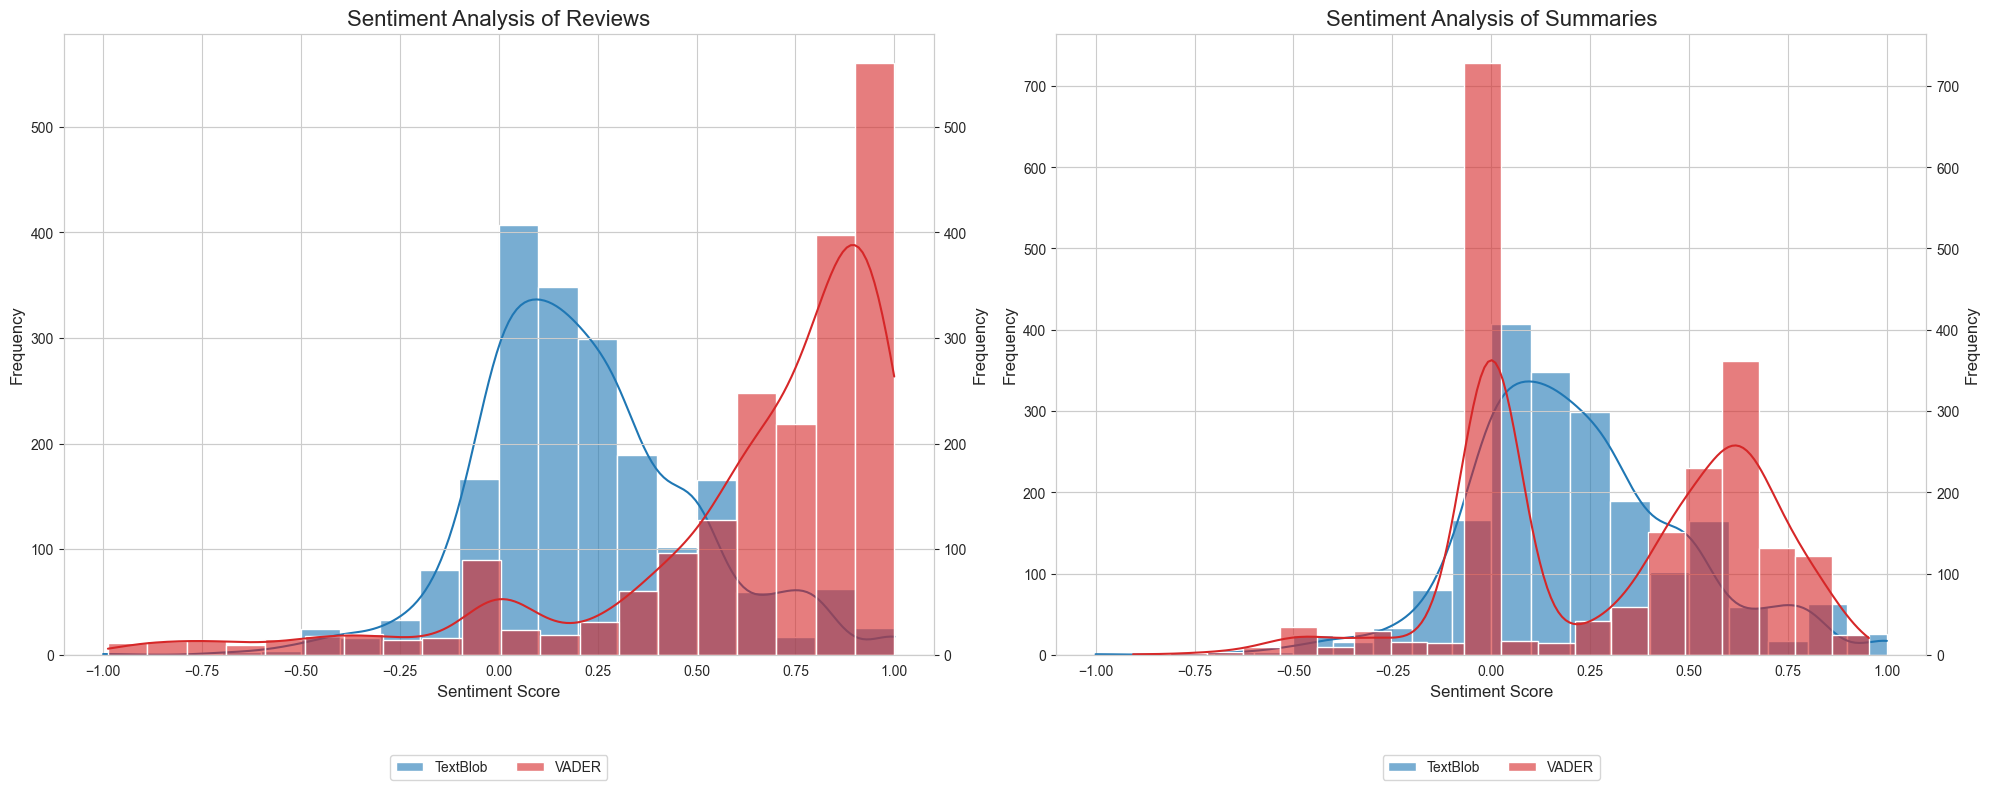

In [171]:
# Create a new figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Define a color palette
colors = ['#1f77b4', '#d62728']

# Plot for Reviews
sns.histplot(df['TextBlob_review_polarity'], bins=20, kde=True, color=colors[0], alpha=0.6, label='TextBlob', ax=ax1)
ax1_twin = ax1.twinx()
sns.histplot(df['VADER_review_compound'], bins=20, kde=True, color=colors[1], alpha=0.6, label='VADER', ax=ax1_twin)

ax1.set_xlabel('Sentiment Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1_twin.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Sentiment Analysis of Reviews', fontsize=16)

# Adjust y-axis limits for review plot
ymax1 = max(ax1.get_ylim()[1], ax1_twin.get_ylim()[1])
ax1.set_ylim(0, ymax1)
ax1_twin.set_ylim(0, ymax1)

# Combine legends for review plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Plot for Summaries
sns.histplot(df['TextBlob_summary_polarity'], bins=20, kde=True, color=colors[0], alpha=0.6, label='TextBlob', ax=ax2)
ax2_twin = ax2.twinx()
sns.histplot(df['VADER_summary_compound'], bins=20, kde=True, color=colors[1], alpha=0.6, label='VADER', ax=ax2_twin)

ax2.set_xlabel('Sentiment Score', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2_twin.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Sentiment Analysis of Summaries', fontsize=16)

# Adjust y-axis limits for summary plot
ymax2 = max(ax2.get_ylim()[1], ax2_twin.get_ylim()[1])
ax2.set_ylim(0, ymax2)
ax2_twin.set_ylim(0, ymax2)

# Combine legends for summary plot
lines3, labels3 = ax2.get_legend_handles_labels()
lines4, labels4 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines3 + lines4, labels3 + labels4, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [172]:
# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Sentiment Analysis of Reviews", "Sentiment Analysis of Summaries"))

# Colors
colors = ['#1f77b4', '#d62728']

# Function to create histogram and smooth density line
def add_hist_and_density(fig, data, name, color, row, col, show_legend):
    # Create histogram
    hist, bin_edges = np.histogram(data, bins=20, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    fig.add_trace(go.Bar(x=bin_centers, y=hist, name=name, marker_color=color, opacity=0.6, 
                         showlegend=show_legend), row=row, col=col)
    
    # Create smooth density line
    kde = gaussian_kde(data)
    x_range = np.linspace(min(data), max(data), 200)
    y_smooth = kde(x_range)
    
    fig.add_trace(go.Scatter(x=x_range, y=y_smooth, mode='lines', line=dict(color=color, width=2), 
                             showlegend=False), row=row, col=col)

# Add traces for Reviews
add_hist_and_density(fig, df['TextBlob_review_polarity'], 'TextBlob', colors[0], 1, 1, True)
add_hist_and_density(fig, df['VADER_review_compound'], 'VADER', colors[1], 1, 1, True)

# Add traces for Summaries
add_hist_and_density(fig, df['TextBlob_summary_polarity'], 'TextBlob', colors[0], 1, 2, False)
add_hist_and_density(fig, df['VADER_summary_compound'], 'VADER', colors[1], 1, 2, False)

# Update layout
fig.update_layout(
    title_text="Sentiment Analysis Comparison",
    barmode='overlay',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend_title_text="Sentiment Analysis Method",
        legend=dict(orientation="h", yanchor="bottom", y=-0.4, xanchor="center", x=0.5)
)

# Update x and y axis labels
fig.update_xaxes(title_text="Sentiment Score", range=[-1, 1], row=1, col=1)
fig.update_xaxes(title_text="Sentiment Score", range=[-1, 1], row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=2)

# Show the plot
fig.show()

# Save the plot as JSON
fig_dict = fig.to_dict()
with open('plots/sentiment_analysis_comparison.json', 'w') as f:
    json.dump(fig_dict, f, cls=NumpyEncoder)

In [173]:
# Assuming your dataframe is named df
correlation, p_value = stats.pearsonr(df['VADER_review_compound'], df['loyalty_points'])

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: -0.019086627848009758
P-value: 0.3935905349895325


In [174]:
# Set display option to show full column content
pd.set_option('display.max_colwidth',120)

# Calculate the absolute difference between VADER and TextBlob sentiment scores
df['Difference'] = abs(df['VADER_review_compound'] - df['TextBlob_review_polarity'])

# Identify the top 20 comments where sentiment scores diverge the most
greatest_divergence = df.nlargest(20, 'Difference')
print("Top 20 comments with greatest divergence between VADER and TextBlob:")
print(greatest_divergence[['review', 'VADER_review_compound', 'TextBlob_review_polarity', 'Difference']])

print("\nTop 20 divergent comments analysis:")
for index, row in greatest_divergence.iterrows():
    print(f"Comment: {row['review']}")
    print(f"VADER Compound: {row['VADER_review_compound']}, TextBlob Polarity: {row['TextBlob_review_polarity']}, Difference: {row['Difference']}")
    print()


Top 20 comments with greatest divergence between VADER and TextBlob:
                                                                                                                       review  \
527   Used with anger-management group and they like it.\nGave them opportunity to share events in their life with\nthe us...   
1058  I like wizards of the coast's game.\nnot bad. I think it's very collectible game.\nrecommend to D&D adventure Board ...   
1339  This expansion makes the base game superior in every way, it opens up the fan of options inmensly, the game transfor...   
1562  This card game is definitely not boring, rather it challenges the mind, with trying to keep track of Who's Who!\nWe ...   
989   If you, like me, used to play D&D, but now you and your friends "growed up" and can't be together because all the re...   
437   This game although it appears to be like Uno and have an easier play method it was still too time consuming and word...   
824                         

In [175]:
# Filter rows with negative VADER scores for review or summary
negative_reviews = df[(df['VADER_review_compound'] < 0) | (df['VADER_summary_compound'] < 0)]
# Adjust column width for review to 80 characters
pd.set_option('display.max_colwidth', 100)

# Print the DataFrame with negative reviews and summaries
negative_reviews[['cust_id', 'review', 'summary' ]]

cust_id  \
0           1   
1           2   
4           5   
9          10   
13         14   
...       ...   
1891      682   
1904      695   
1909      700   
1944      733   
1988      773   

                                                                                                   review  \
0     When it comes to a DM's screen, the space on the screen itself is at an absolute premium. The fa...   
1     An Open Letter to GaleForce9*:\n\nYour unpainted miniatures are very not bad. Your spell cards a...   
4     As my review of GF9's previous screens these were completely unnecessary and nearly useless. Ski...   
9     My review will mirror others in that this kind of misses the mark and there are some lost opport...   
13    This is one of the worst games I have ever played.  You basically have to come up with puns on t...   
...                                                                                                   ...   
1891  This is a family favorite.  Everybody loves it.  The teens even took to it the last time they we...   
1904                       I like it, but my husband won't play anything new, so we always play Scrabble.   
1909                                                                   We really did not enjoy this game.   
1944                                         Bought this for my 9 year old nephew. He didn't like it much   
1988                                                                       not as much fun as I had hoped   

                                                                                               summary  
0     The fact that 50% of this space is wasted on art (and not terribly informative or needed art ...  
1                                            Another worthless Dungeon Master's screen from GaleForce9  
4                                                                                           Money trap  
9                                    Another missed opportunity.  Not a value add to the product line.  
13                                                                                      Very weak game  
...                                                                                                ...  
1891                                                                              Just about worn out.  
1904                                                                                              Fun!  
1909                                                                                          Quiddler  
1944                                                                                 He didn't like it  
1988                                                                                         Two Stars  

[218 rows x 3 columns]

# 17. Recommendations  <a id="17"></a> 
### 17a. Product Score <a id="17a"></a> 
###### [Return to Top](#top)

In [176]:
# Calculate enhanced product scores
product_scores = calculate_product_score(df, df_cust)

# Display top 10 products by enhanced score
print("Top 10 products by product score:")
print(product_scores.sort_values('final_score', ascending=False).head(10))

# Analyze correlation between different score components
correlation_matrix = product_scores[['final_score', 'normalised_sentiment', 'consistency_score', 'normalised_loyalty']].corr()
print("\nCorrelation matrix of score components:")
correlation_matrix

# Check if 'product' column exists, if not, use the index
hover_data = ['product'] if 'product' in product_scores.columns else None

# Create the scatter plot
fig = px.scatter(product_scores, x='normalised_sentiment', y='normalised_loyalty', 
                 color='final_score', hover_data=hover_data,
                 title='Sentiment vs Loyalty Contribution for Products',
                 labels={'normalised_sentiment': 'Sentiment', 
                         'normalised_loyalty': 'Loyalty Contribution',
                         'final_score': 'Final Score'})

# If 'product' column doesn't exist, add index to hover data
if hover_data is None:
    fig.update_traces(hovertemplate='<b>Product ID: %{customdata[0]}</b><br>Sentiment: %{x}<br>Loyalty Contribution: %{y}<br>Final Score: %{marker.color}')
    fig.update_traces(customdata=product_scores.index.values[:, None])

# Update layout for transparent background and other styling
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    height=600,
)

# Update axes
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the plot
fig.show()

# Save the plot as JSON
with open('plots/product_scores_scatter.json', 'w') as f:
    json.dump(fig.to_dict(), f, cls=NumpyEncoder)

Top 10 products by product score:
         final_score  normalised_sentiment  review_count  consistency_score  \
product                                                                       
2795           100.0               68.2390            10           4.769245   
2874            99.5               93.2260            10           8.899434   
2849            99.0               86.6565            10           7.016377   
3403            98.5               88.3825            10           7.932590   
2518            98.0               81.4855            10           5.905207   
4477            97.5               80.0915            10           5.074845   
10232           97.0               86.9480            10           7.313081   
10995           96.5               80.2225            10           5.104227   
8962            96.0               90.7715            10           8.677994   
5510            95.5               78.0845            10           4.350718   

         avg_loya

In [177]:
product_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 107 to 11086
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   final_score           200 non-null    float64
 1   normalised_sentiment  200 non-null    float64
 2   review_count          200 non-null    int64  
 3   consistency_score     200 non-null    float64
 4   avg_loyalty_points    200 non-null    float64
 5   normalised_loyalty    200 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 10.9 KB


### 17b. Provide Recommendations by Cluster  <a id="17b"></a> 

In [178]:
df_cust

gender  age  remuneration_k  spending_score  loyalty_points education  \
0      male   18           12.30            39.0             210       grd   
1      male   23           12.30            81.0             524       grd   
2    female   22           13.12             6.0              40       grd   
3    female   25           13.12            77.0             562       grd   
4    female   33           13.94            40.0             366       grd   
..      ...  ...             ...             ...             ...       ...   
777  female   37           84.46            69.0            4031       phd   
778  female   43           92.66             8.0             539       phd   
779    male   34           92.66            91.0            5614       grd   
780    male   34           98.40            16.0            1048       phd   
781    male   32           92.66             8.0             479       phd   

     product  \
0        453   
1        466   
2        254   
3        263   
4        291   
..       ...   
777      977   
778      979   
779     1012   
780     1031   
781      453   

                                                                                                  review  \
0    When it comes to a DM's screen, the space on the screen itself is at an absolute premium. The fa...   
1    An Open Letter to GaleForce9*:\n\nYour unpainted miniatures are very not bad. Your spell cards a...   
2    Nice art, nice printing.  Why two panels are filled with a general Forgotten Realms map is beyon...   
3                                      Amazing buy! Bought it as a gift for our new dm and it's perfect!   
4    As my review of GF9's previous screens these were completely unnecessary and nearly useless. Ski...   
..                                                                                                   ...   
777  The perfect word game for mixed ages (with Mom, perhaps, giving a little help to the 7 yr old.) ...   
778  Great game.  Did not think I would like it when first received, but has turned out to be a lot o...   
779                                                  Great game for all.........\nKeeps the mind nimble!   
780                                                                                            fun game!   
781                        This game is fun. A lot like scrabble without all those little tiles to lose.   

                                                                                              summary  \
0    The fact that 50% of this space is wasted on art (and not terribly informative or needed art ...   
1                                           Another worthless Dungeon Master's screen from GaleForce9   
2                                                                     pretty, but also pretty useless   
3                                                                                          Five Stars   
4                                                                                          Money trap   
..                                                                                                ...   
777                                                    The perfect word game for mixed ages (with Mom   
778                                                                                         Super fun   
779                                                                                        Great Game   
780                                                                                        Four Stars   
781                                                                                    Love this game   

    age_group  ...  education_dpl  education_grd  education_pgd  \
0       17-24  ...          False           True          False   
1       17-24  ...          False           True          False   
2       17-24  ...          False           True          False   
3       25-34  ...          False           True 

In [182]:

# Prepare the data for clustering
X = df_cust[['remuneration_k', 'spending_score']]  # Adjust features as needed
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train KMeans
kmeans_k, inertias, silhouettes, ks = train_kmeans(X_scaled)

# Choose the optimal number of clusters (for this example, let's use 5)
optimal_k = 5
optimal_kmeans = kmeans_k[optimal_k - 2]  # Adjust index based on your ks array

# Assign cluster labels to df_cust
df_cust['cluster'] = optimal_kmeans.predict(X_scaled)


# Call get_top_products_by_cluster to define top_products
top_products = get_top_products_by_cluster(df_cust, product_scores, n_top=10)  # Adjust n_top as needed

# Create horizontal bar chart for top 10 products
top_10_products = product_scores.sort_values('final_score', ascending=False).head(10)
top_10_products = top_10_products.reset_index()

fig1 = go.Figure(go.Bar(
    y=top_10_products['product'].astype(str),  # Ensure product names are treated as strings
    x=top_10_products['final_score'],
    orientation='h',
    marker_color='skyblue'
))

fig1.update_layout(
    title_text="Top 10 Products by Score",
    xaxis_title="Score",
    yaxis_title="Product",
    height=500,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
        yaxis=dict(
            type='category', 
            categoryorder='total ascending',
            tickfont=dict(size=20)  # Increase font size for Y-axis labels
        )
    )

# Calculate gender splits and average age for each cluster
cluster_stats = df_cust.groupby('cluster').agg({
    'gender': lambda x: f"{(x == 'male').mean()*100:.1f}% M / {(x == 'female').mean()*100:.1f}% F",
    'age': 'mean'
}).reset_index()

# Create figures for cluster recommendations
cluster_figs = []
for cluster in sorted(df_cust['cluster'].unique()):
    recs = get_recommendations(cluster, top_products)
    recs = recs.reset_index()[['product', 'final_score']].head(10)  # Top 10 recommendations
    
    fig = go.Figure(go.Bar(
        y=recs['product'].astype(str),  # Ensure product names are treated as strings
        x=recs['final_score'],
        orientation='h',
        marker_color='lightgreen'
    ))
    
    cluster_info = cluster_stats[cluster_stats['cluster'] == cluster].iloc[0]
    
    fig.update_layout(
        title=dict(
            text=f"Top 10 Recommendations for Cluster {cluster}<br>"
                f"Gender: {cluster_info['gender']} | Avg Age: {cluster_info['age']:.1f}",
            font=dict(size=16)  # Adjust the title font size here
        ),
        xaxis_title="Score",
        yaxis_title="Product",
        height=500,
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        yaxis=dict(
            type='category', 
            categoryorder='total ascending',
            tickfont=dict(size=20)  # This correctly sets the Y-axis label font size
        )
    )
    
    cluster_figs.append(fig)

# Show the plots
fig1.show()
for fig in cluster_figs:
    fig.show()

# Save the plots as JSON
with open('plots/top_10_products.json', 'w') as f:
    json.dump(fig1.to_dict(), f, cls=NumpyEncoder)

for i, fig in enumerate(cluster_figs):
    with open(f'plots/cluster_{i}_recommendations.json', 'w') as f:
        json.dump(fig.to_dict(), f, cls=NumpyEncoder)


# [Return to the Top of the Page](#top)